In [1]:
#-------------------------- arguments ---------------------------#
options(stringsAsFactors=F)
library(glmnet)
library(foreach)
library(genio)
library(Rcpp)

# testing
if (T) {
    args <- c("21", "3")
} 
#args = commandArgs(trailingOnly = TRUE)
chr = as.numeric(args[1])
    

#-------------------------- data import ---------------------------#  


chr = "21"
k = "1"
genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
gtex_dir <- "/gpfs/loomis/project/zhao/zy92/GTEX/" 
glist = dir(paste0(gtex_dir, "adjusted_expr/chr", chr))


# idx 

chr_str <- paste0("chr", chr, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))

gene_idx = which(glist == "ENSG00000184012")
dose_idx = which(startsWith(gene_vec, "ENSG00000184012"))

gene_id <- gene_vec[dose_idx]
g <- glist[gene_idx]
dose_path = paste0(genotype_dir, chr_str, gene_id, "/", gene_id)
Yt = dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/"))
P = length(Yt)
output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 
ntune = 5
if_verbose = T
# loading fast matrix operations 
#sourceCpp("/gpfs/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.
sourceCpp("/gpfs/loomis/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.




bgt_origin = Sys.time()

#-------------------------- functions ---------------------------#  

grad_prep <- function(X, Y){
	## pre-calculate some metrics for gradient
	ll = length(Y)
	P = ncol(X[[1]])
	XY = matrix(0,P,ll)
	for(i in 1:ll){
		XY[,i] = t(X[[i]])%*%Y[[i]]/nrow(X[[i]])
	}
	XY
}

cv_helper <- function(N, fold){
	valid_num = floor(N/fold)
	set.seed(123)
	perm = sample(1:N, size = N)
	idx1 = seq(1,N,valid_num)
	idx2 = c(idx1[-1]-1,N)
	list(perm=perm, idx=cbind(idx1,idx2))
}

minmax_lambda <- function(lst){
	max_lam = max(unlist(lapply(lst, function(x){max(x$lambda)})))
	min_lam = min(unlist(lapply(lst, function(x){min(x$lambda)})))
	c(min_lam, max_lam)
}

elastic_net_mse <- function(lst, X_tune, Y_tune, X_test, Y_test){
	P = length(lst)
	M = ncol(X_tune[[1]])
	lam_V = rep(0, P)
	test_res = list()
	test_beta = matrix(0, M, P)
	for(t in 1:P){
		ncv = length(lst[[t]]$lambda)
		tmp_mse = rep(0, ncv)
		for(k in 1:ncv){
			tmp_mse[k] = mean((Y_tune[[t]] - X_tune[[t]]%*%lst[[t]]$glmnet.fit$beta[,k])^2)
		}
		ss = which.min(tmp_mse)
		test_beta[,t] = lst[[t]]$glmnet.fit$beta[,ss]
		lam_V[t] = lst[[t]]$lambda[ss]
		predicted = X_test[[t]]%*%lst[[t]]$glmnet.fit$beta[,ss]
		test_res[[t]] = cbind(Y_test[[t]], predicted)
	}
	list(lam = lam_V, mse = test_res, est = test_beta)
}

multi_mse <- function(theta_est, X_test, Y_test){
	answer = list()
	P = ncol(theta_est)
	for(t in 1:P){
		predicted = X_test[[t]]%*%theta_est[,t]
		answer[[t]] = cbind(Y_test[[t]], predicted)
	}
	answer
}

avg_perm <- function(mse_lst){
	fd = length(mse_lst)
	P = length(mse_lst[[1]])
	rsq = mse = adj_mse = matrix(0, fd, P)
	for(f in 1:fd){
		for(t in 1:P){
			rsq[f,t] = (cor(mse_lst[[f]][[t]])[1,2])^2
			mse[f,t] = mean((mse_lst[[f]][[t]][,1]-mse_lst[[f]][[t]][,2])^2)
			adj_mse[f,t] = mse[f,t]/var(mse_lst[[f]][[t]][,1])
		}
	}
	cbind(apply(rsq, 2, mean), apply(mse, 2, mean), apply(adj_mse, 2, mean))

	#list(rsq = apply(rsq, 2, mean), mse = apply(mse, 2, mean), adj_mse = apply(adj_mse, 2, mean))
}

## group lasso on data with missing covariates, use validation data for stopping criterion
glasso <- function(X, Y, X1, Y1, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 50, eps = 1e-3, verbose = FALSE){
	Bgt = Sys.time()
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = rep(0,P)
	for(t in 1:P){
		old_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
  if (verbose) {
    cat("Training error: ", old_objV1, '\n')	
  }
	old_objV2 = rep(0,P)
	for(t in 1:P){
		old_objV2[t] = 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
	}
	if (verbose) {
    cat("Testing error: ", old_objV2, '\n')
  }
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("/ysm-gpfs/pi/zhao/from_louise/yh367/GTEX/codes/glasso.so") # change this to the abs path to optim.so
	}
	for(i in 1:maxiter){
		bgt = Sys.time()
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		edt = Sys.time()
		
		new_objV1 = new_objV2 = rep(0,P)
		for(t in 1:P){
			new_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
		}
		if (verbose) {IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))}
		for(t in 1:P){
			new_objV2[t] = 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
		}
		if (verbose) {IRdisplay::display_html(paste0("Testing error: ", new_objV2, '\n'))}
		if(mean(new_objV2) > mean(old_objV2)|mean(new_objV1) > mean(old_objV1)){
			break
		}else{
			old_objV2 = new_objV2
		}
		if(max(abs(new_objV1-old_objV1)) < eps){
			break
		}else{
			old_objV1 = new_objV1
		}
	}
	Edt = Sys.time()
	cat("total training time: ", Edt-Bgt, "\n")
	list(est = theta, avg_tune_err = mean(new_objV2), tune_err=new_objV2)
}

## simpler version of glasso, train model until converges 
glasso_no_early_stopping <- function(X, Y, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 50, eps = 1e-3, verbose = FALSE){
  cat("running glasso_no_early_stopping\n")
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = rep(0,P)
	for(t in 1:P){
		old_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
	if (verbose) {cat("Training error: ", mean(old_objV1), '\n')}
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("optim.so")
	}
	for(i in 1:maxiter){
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		new_objV1 = rep(0,P)
		for(t in 1:P){
			new_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
		}
		if (verbose) {cat("Training error: ", mean(new_objV1), '\n')}
		if(max(abs(new_objV1-old_objV1)) < eps|mean(new_objV1) > mean(old_objV1)){
			break
		}else{
			old_objV1 = new_objV1
		}
	}
	list(est = theta, avg_train_err = mean(new_objV1), train_err = new_objV1)
}

extract_genotype <- function(gene_idx, chr_str, genotype_dir, gene_vec) {
    gene_dir <- paste0(genotype_dir, chr_str, gene_vec[gene_idx], "/", gene_vec[gene_idx])
    genotype_info <- read_plink(gene_dir)
    
    print(paste0("INFO: genotype matrix dimension:", dim(genotype_info$X)[1], " * ", dim(genotype_info$X)[2]))
    return(genotype_info)
}


#-------------------------- main ---------------------------#  




# create dirs
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))

# expr files 
cat("INFO: loading expression files...")
Y = list()
T_idx = c()
for(t in 1:P){
    tmp_exp = read.table(paste0(gtex_dir, "adjusted_expr/chr", chr, "/", g, "/", Yt[t]), header=F)
    # check if the y is constant
    if (!all(tmp_exp[,2] == tmp_exp[1,2])) {
        T_idx = c(T_idx, t)
        Y[[length(T_idx)]] = tmp_exp 
    }
     
}
Yt = Yt[T_idx]
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)
P = T_num

# genotype files 
cat("INFO: loading genotype files...")	
genotype_info <- read_plink(dose_path)
dose = genotype_info$X[1:1000, ]
dose_std = dose

# center the dose
for(j in 1:nrow(dose)){
    dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
    dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
}

# covariance matrix 
n_sample = ncol(dose_std)
tmp = t(as.matrix(dose_std))
XX = eigenMatMult(t(tmp), tmp)/n_sample 
Xnorm = diag(XX)
remove(tmp)
remove(XX)
sub_id = colnames(dose_std)

# number of snps
M = nrow(dose_std)
sub_id_map = list()
sub_id_map_exp = list()

# sample matching 
for(t in 1:T_num){
    #tmp = rep(0, nrow(Y[[t]]))
    exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
    # index of ids that have matched genotypes 
    # exp_id based on order of exp_id
    match_id <- match(exp_id, sub_id)
    sub_id_map[[t]] <- na.omit(match_id)
    sub_id_map_exp[[t]] <- !is.na(match_id)  
}

# cv                                   
fold = 5
#IR                                
IRdisplay::display_html("INFO: CV preparation")
cv_config = cv_helper(n_sample, fold)
cv_perm = cv_config$perm
cv_idx = cv_config$idx

single_res_test = list()
single_lam = matrix(0, fold, T_num)
single_theta_est = list()
	
multi_res_test = list()
multi_lam = matrix(0, fold, 2)
multi_theta_est = list()

multi_res_test2 = list()
multi_lam2 = array(0, dim=c(fold, T_num, 2))
multi_theta_est2 = list()
                                  

res_tune = list()
rec_lamv = matrix(0, fold, ntune)                                 
                                  
for(f in 1:fold){
#for(f in 1:1){
    bgt = Sys.time()
    IRdisplay::display_html(paste0("INFO: fold ", f))
    test_index = cv_perm[cv_idx[f,1]:cv_idx[f,2]]
    test_id = sub_id[test_index]

    # move the tuning idx to another idx block
    tuning_index = cv_perm[cv_idx[f%%fold+1,1]:cv_idx[f%%fold+1,2]]
    tuning_id = sub_id[tuning_index]

    # idx list
    X_test = list()
    Y_test = list()
    X_tune = list()
    Y_tune = list()
    X_train = list()
    Y_train = list()
    for(t in 1:T_num){
        # idx matching  
        id_filter = !(sub_id_map[[t]]%in%c(test_index,tuning_index))
        X_train_tmp = sub_id_map[[t]][id_filter]
        Y_train_tmp = which(sub_id_map_exp[[t]] == T)[id_filter]
        tuning_id_filter = sub_id_map[[t]]%in%tuning_index
        X_tuning_tmp = sub_id_map[[t]][tuning_id_filter]
        Y_tuning_tmp = which(sub_id_map_exp[[t]] == T)[tuning_id_filter]
        testing_id_filter = sub_id_map[[t]]%in%test_index
        X_test_tmp = sub_id_map[[t]][testing_id_filter]
        Y_test_tmp = which(sub_id_map_exp[[t]] == T)[testing_id_filter]
        # training data
        X_train[[t]] = apply(as.matrix(dose_std[,X_train_tmp]),1,as.numeric)
        Y_train[[t]] = Y[[t]][Y_train_tmp, 2]
        X_tune[[t]] = apply(as.matrix(dose_std[,X_tuning_tmp]),1,as.numeric)
        Y_tune[[t]] = Y[[t]][Y_tuning_tmp, 2]
        X_test[[t]] = apply(as.matrix(dose_std[,X_test_tmp]),1,as.numeric)
        Y_test[[t]] = Y[[t]][Y_test_tmp, 2]
        #IRdisplay::display_html(length(X_train_tmp))
        #IRdisplay::display_html(length(Y_train_tmp))
        #IRdisplay::display_html(dim(X_train[[t]]))
        #IRdisplay::display_html(length(Y_train[[t]]))
    }

    ## model training ##	
    ## train elastic net and used average lambda as tuning parameters ##
    single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
    single_summary = list()
    for(t in 1:T_num) {
        #print(Y_train[[t]])
        #print(sum(is.na(X_train[[t]])))
        if (t %% 5 == 0) {
            IRdisplay::display_html(paste0("INFO: glmnet cv tissue", t))
        }
        
        
        tt = cv.glmnet(X_train[[t]], Y_train[[t]], alpha = 0.5, nfolds = 5)
        single_summary[[t]] = tt
        single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
    }
    ## performance of Elastic net on tuning and testing data with various tuning parameters
    els_output = elastic_net_mse(single_summary, X_tune, Y_tune, X_test, Y_test)
    single_res_test[[f]] = els_output$mse
    single_lam[f,] = els_output$lam
    single_theta_est[[f]] = els_output$est
    remove(els_output)

    
    ## use elastic net ests row norm as weights ##
    lam_range = minmax_lambda(single_summary)
    sig_norm = apply(single_initial_est, 1, function(x){sqrt(sum(x^2))})
    sig_norm[sig_norm==0] = rep(min(sig_norm[sig_norm>0]), sum(sig_norm==0))/2
    sig_norm = sig_norm/sum(sig_norm)
    weights2 = 1/sig_norm; weights2 = weights2/sum(weights2);

    tis_norm = apply(single_initial_est, 2, function(x){sum(abs(x))})
    tis_norm[tis_norm==0] = rep(min(tis_norm[tis_norm>0]), sum(tis_norm==0))/2
    tis_norm = tis_norm/sum(tis_norm)
    weights1 = 1/tis_norm; weights1 = weights1/sum(weights1);
    lam_V = seq(lam_range[1], lam_range[2], length.out = ntune)
    
    # initial value
    initial_numeric = as.numeric(single_initial_est)
	remove(single_summary)
    remove(single_initial_est)


    #-------------------------- train - validate - test ---------------------------#
    IRdisplay::display_html('starting train-validate-test\n')
    ## preparation
    XY = grad_prep(X_train, Y_train)
    #bgt = Sys.time()
    XX_train = lapply(X_train, function(x) { eigenMatMult(t(x), x)/nrow(x)})
    #edt = Sys.time()
    #print(edt-bgt)
    
    spsz = unlist(lapply(X_train,nrow))
    #res_tune = rep(0, ntune)
    res_tune[[f]] = array(-1, dim=c(ntune, ntune, T_num))
    #best.lam = 0
    rec_lamv[f,] = lam_V
    for(lam1 in 1:ntune){
        for(lam2 in 1:ntune){
            single_est = matrix(initial_numeric, M, T_num )
            ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[lam1]/spsz, lambda2=lam_V[lam2], theta=single_est, verbose = if_verbose)
            if(sum(ans$est!=0)>0){
                res_tune[[f]][lam1,lam2, ] = ans$tune_err
                if (if_verbose) { cat("lambda1=",lam_V[lam1], "; lambda2=", lam_V[lam2], "; avg tune err=", ans$avg_tune_err, '\n') }
                remove(single_est); remove(ans);
            }else{
                remove(single_est); remove(ans);
                break
            }			
        }
    }
    
    
    #-------------------------- save results on test set for evaluation ---------------------------#
    IRdisplay::display_html("saving cross-validation results for evaluation and analysis\n")
    avg_tune_res = apply(res_tune[[f]], c(1,2), mean)
    best.lam = which(avg_tune_res == min(avg_tune_res[avg_tune_res>=0]), arr.ind = TRUE)[1,]
    single_est = matrix(initial_numeric, M, P)
    ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[best.lam[1]]/spsz, lambda2=lam_V[best.lam[2]], theta=single_est, verbose = if_verbose)
    multi_res_test[[f]] = multi_mse(ans$est, X_test, Y_test)
    multi_lam[f,] = lam_V[best.lam]
    multi_theta_est[[f]] = ans$est
    remove(single_est)
    remove(ans)

    
    edt = Sys.time()
    print(edt-bgt)
} # end of cv loop
edt_origin = Sys.time() 
print("Final Time Cost: ")                                 
print(edt_origin-bgt_origin)
   

Loading required package: Matrix

Loading required package: foreach

Loaded glmnet 2.0-13




INFO: loading expression files...INFO: loading genotype files...

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.bim

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.fam

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.bed



INFO: CV preparation

INFO: fold 1

INFO: glmnet cv tissue5

INFO: glmnet cv tissue10

INFO: glmnet cv tissue15

INFO: glmnet cv tissue20

INFO: glmnet cv tissue25

INFO: glmnet cv tissue30

INFO: glmnet cv tissue35

INFO: glmnet cv tissue40

INFO: glmnet cv tissue45

starting train-validate-test

Training error: 62.9279382125452
Training error: 56.8869874394399
Training error: 0.441865689874106
Training error: 4.82913026651709
Training error: 3.05002031209379
Training error: 50.3529672482256
Training error: 9.54626805083192
Training error: 5.89298160132399
Training error: 0.746500834388313
Training error: 0.125117220549598
Training error: 0.184846156692141
Training error: 0.852306298398947
Training error: 1.95285055784181
Training error: 0.937431127711684
Training error: 1.95008062762237
Training error: 0.27457651308393
Training error: 0.238722555399507
Training error: 0.0887083605170439
Training error: 0.0724762764222976
Training error: 47.8608409470345
Training error: 2.28546768871941
Training error: 19.1180705400458
Training error: 5.94363975007786
Training error: 1.25098203204141
Training error: 3.0979309146779
Training error: 61.1820908319933
Training error: 38.1906331486684
Training error: 2.34011516756573
Training error: 1.34034678562906
Training error: 0.864072736315171
Training error: 0.604345105996506
Training error: 7.88892556371722
Training error: 9671.0963461466
Training error: 1.12645401885088
Training error: 181.59437547402
Training error: 1.81083087227623
Training error: 0.153419809559766
Training error: 1.73648770072387
Training error: 0.948137963627352
Training error: 6.50610287241859
Training error: 15.0395967068263
Training error: 1.43925846522635e+22
Training error: 274.069128230718
Training error: 1831500495.41779
Training error: 0.620255844928189
Training error: 38.7724305752427
Training error: 0.145676230498676
Training error: 2.76581810361034
Training error: 207.35608687674

Testing error: 118.829922074257
Testing error: 39.0517257820728
Testing error: 2.81549479869924
Testing error: 9.81276668042044
Testing error: 25.0769542600105
Testing error: 94.4121168025852
Testing error: 56.0611294710561
Testing error: 24.2014899005561
Testing error: 5.87933193800087
Testing error: 0.526803276231296
Testing error: 1.22836573911036
Testing error: 2.57340342734267
Testing error: 6.52929171885566
Testing error: 8.11755926095714
Testing error: 9.97599258799906
Testing error: 1.69093299984943
Testing error: 3.22153172307088
Testing error: 2.20532615526116
Testing error: 1.50660512881365
Testing error: 135.421674031008
Testing error: 10.2072472422027
Testing error: 269.0823053323
Testing error: 14.4552512488731
Testing error: 4.23530818207945
Testing error: 5.39942296345118
Testing error: 99.0991365774197
Testing error: 88.8066007200615
Testing error: 4.17262497580076
Testing error: 1.877177634214
Testing error: 38.6462342443404
Testing error: 0.828279112370109
Testing error: 14.7411371022658
Testing error: 44350.5171595357
Testing error: 1.21518441023582
Testing error: 346.944692209206
Testing error: 6.24705283129566
Testing error: 0.672888983564453
Testing error: 4.94404632061175
Testing error: 4.62567508626797
Testing error: 8.80163746409245
Testing error: 18.6273697919699
Testing error: 3.43646204737054e+21
Testing error: 518.397100213098
Testing error: 3424027155.178
Testing error: 1.12560960981973
Testing error: 70.8201071700154
Testing error: 5.48085552414023
Testing error: 17.4822471847707
Testing error: 287.875557438193

Training error: 119.339819059519
Training error: 114.632908715948
Training error: 1.70805721302126
Training error: 15.756790911018
Training error: 8.41275216465175
Training error: 115.725822801367
Training error: 21.1120755826437
Training error: 26.4350764857742
Training error: 3.70964058942272
Training error: 0.60762768083493
Training error: 0.808303132606226
Training error: 2.44431192982333
Training error: 5.45943324179713
Training error: 4.38901211432152
Training error: 7.68967115019697
Training error: 1.05215896410428
Training error: 1.85013826219497
Training error: 1.22954072206453
Training error: 0.43383459062277
Training error: 169.110474976567
Training error: 5.21502431668755
Training error: 161.759063603326
Training error: 12.9972665002147
Training error: 2.53441484703365
Training error: 7.07841587046487
Training error: 135.454024704238
Training error: 115.34478407683
Training error: 4.75153069831113
Training error: 2.49412470101527
Training error: 126.992816434242
Training error: 0.612508620949161
Training error: 13.1756693434447
Training error: 12.7498018449236
Training error: 1.90079641569564
Training error: 392.396605249003
Training error: 6.87669672702096
Training error: 0.39873687883474
Training error: 3.35863513820731
Training error: 2.75293579543982
Training error: 12.4635880210325
Training error: 24.5189359576261
Training error: 6.77103833901042
Training error: 890.561891748678
Training error: 122.321474670834
Training error: 1.14518290099268
Training error: 82.9638426620025
Training error: 2.82696713316494
Training error: 19.1022072409438
Training error: 350.671155998579

Testing error: 30.9781524789128
Testing error: 29.6630447994489
Testing error: 1.89080879436361
Testing error: 5.64454985127762
Testing error: 10.3946546906655
Testing error: 9.71269500483227
Testing error: 54.4792127091858
Testing error: 12.4405901435192
Testing error: 0.399868757521138
Testing error: 0.211446361063801
Testing error: 0.166951056451824
Testing error: 0.578363407879928
Testing error: 3.44546559364534
Testing error: 4.83689284240568
Testing error: 5.84088538545272
Testing error: 0.450264900697761
Testing error: 0.310561524826704
Testing error: 1.50652320257173
Testing error: 1.15539405489494
Testing error: 47.9304303308118
Testing error: 7.11169701330744
Testing error: 84.7997809467887
Testing error: 10.51323601323
Testing error: 3.09035831882061
Testing error: 3.66992007785157
Testing error: 18.4813718862659
Testing error: 22.0874141157758
Testing error: 2.36866514114044
Testing error: 1.29136005050065
Testing error: 33.0671720948644
Testing error: 0.185581293546454
Testing error: 10.8205298383931
Testing error: 3.32145305925841
Testing error: 0.333514831274879
Testing error: 55.2860621940442
Testing error: 5.72901715571739
Testing error: 0.488381993509773
Testing error: 2.73913541613399
Testing error: 2.56096310879491
Testing error: 3.48224249666387
Testing error: 3.48690599830165
Testing error: 5.39410049072045
Testing error: 120.455960439706
Testing error: 21.8236063208127
Testing error: 0.786391054835417
Testing error: 12.2521086609196
Testing error: 2.8813091395529
Testing error: 8.03111946015942
Testing error: 223.529743561381

Training error: 67.1855829201951
Training error: 60.127865889328
Training error: 0.743566905710934
Training error: 6.10518089414432
Training error: 4.05255867627752
Training error: 54.0411954416181
Training error: 8.53792660477303
Training error: 7.52506531046809
Training error: 1.30564438035934
Training error: 0.302632106867387
Training error: 0.446450481734407
Training error: 1.31858384593716
Training error: 2.76559718053294
Training error: 1.87301740766051
Training error: 2.46381811198159
Training error: 0.615090557821215
Training error: 0.613683083106689
Training error: 0.376682605014313
Training error: 0.232675975447759
Training error: 53.116723825682
Training error: 3.19215038989764
Training error: 6.31922912746136
Training error: 6.74188627341206
Training error: 1.99010656054585
Training error: 4.05452824758559
Training error: 64.4095287805726
Training error: 42.2697848360748
Training error: 3.35710514884481
Training error: 1.94140252722829
Training error: 1.62126932115097
Training error: 0.377997526116711
Training error: 9.4228912215157
Training error: 5.49121580903041
Training error: 1.48300020814891
Training error: 186.378789301503
Training error: 2.7504192592429
Training error: 0.349381833177347
Training error: 2.51472126215181
Training error: 1.68089661179956
Training error: 7.66888279169245
Training error: 16.454392549897
Training error: 2.36719360116886
Training error: 254.438820333391
Training error: 920112870.068144
Training error: 0.942835592819565
Training error: 41.7800170832832
Training error: 0.772236317065898
Training error: 3.33177744191935
Training error: 214.492839888631

Testing error: 101.123459746917
Testing error: 34.7697314617356
Testing error: 2.26000497254871
Testing error: 7.07364288307872
Testing error: 15.7434238065811
Testing error: 83.6388878107624
Testing error: 57.8782257634683
Testing error: 20.3375998337173
Testing error: 3.27410405429625
Testing error: 0.307713643348208
Testing error: 0.381922502804991
Testing error: 1.13926298264193
Testing error: 5.01100951400301
Testing error: 6.63539185152782
Testing error: 8.57515375733419
Testing error: 0.652170830823848
Testing error: 1.49237087747781
Testing error: 2.03950540312938
Testing error: 1.34031424624345
Testing error: 121.423767079249
Testing error: 8.15977252382857
Testing error: 99.5061433169785
Testing error: 11.9475449136725
Testing error: 3.32844355228922
Testing error: 3.73322717603326
Testing error: 83.1186160397022
Testing error: 83.7891046749135
Testing error: 3.38987117983082
Testing error: 1.43121012487415
Testing error: 35.324318070544
Testing error: 0.345289318697798
Testing error: 12.494346858913
Testing error: 6.62174260620388
Testing error: 0.478372186164757
Testing error: 336.005502760459
Testing error: 4.23879644037528
Testing error: 0.656979079795219
Testing error: 3.06454508948251
Testing error: 3.76645147782541
Testing error: 6.57921341072239
Testing error: 13.1235697642407
Testing error: 9.85666160653283
Testing error: 445.122651630904
Testing error: 1720091016.82782
Testing error: 0.871639615813598
Testing error: 63.8876201073868
Testing error: 5.06600494425439
Testing error: 10.8379397257582
Testing error: 270.918953423629

Training error: 119.339819059519
Training error: 114.632908715948
Training error: 1.70805721302126
Training error: 15.756790911018
Training error: 8.41275216465175
Training error: 115.725822801367
Training error: 21.1120755826437
Training error: 26.4350764857742
Training error: 3.70964058942272
Training error: 0.60762768083493
Training error: 0.808303132606226
Training error: 2.44431192982333
Training error: 5.45943324179713
Training error: 4.38901211432152
Training error: 7.68967115019697
Training error: 1.05215896410428
Training error: 1.85013826219497
Training error: 1.22954072206453
Training error: 0.43383459062277
Training error: 169.110474976567
Training error: 5.21502431668755
Training error: 161.759063603326
Training error: 12.9972665002147
Training error: 2.53441484703365
Training error: 7.07841587046487
Training error: 135.454024704238
Training error: 115.34478407683
Training error: 4.75153069831113
Training error: 2.49412470101527
Training error: 126.992816434242
Training error: 0.612508620949161
Training error: 13.1756693434447
Training error: 12.7498018449236
Training error: 1.90079641569564
Training error: 392.396605249003
Training error: 6.87669672702096
Training error: 0.39873687883474
Training error: 3.35863513820731
Training error: 2.75293579543982
Training error: 12.4635880210325
Training error: 24.5189359576261
Training error: 6.77103833901042
Training error: 890.561891748678
Training error: 122.321474670834
Training error: 1.14518290099268
Training error: 82.9638426620025
Training error: 2.82696713316494
Training error: 19.1022072409438
Training error: 350.671155998579

Testing error: 30.9781524789128
Testing error: 29.6630447994489
Testing error: 1.89080879436361
Testing error: 5.64454985127762
Testing error: 10.3946546906655
Testing error: 9.71269500483227
Testing error: 54.4792127091858
Testing error: 12.4405901435192
Testing error: 0.399868757521138
Testing error: 0.211446361063801
Testing error: 0.166951056451824
Testing error: 0.578363407879928
Testing error: 3.44546559364534
Testing error: 4.83689284240568
Testing error: 5.84088538545272
Testing error: 0.450264900697761
Testing error: 0.310561524826704
Testing error: 1.50652320257173
Testing error: 1.15539405489494
Testing error: 47.9304303308118
Testing error: 7.11169701330744
Testing error: 84.7997809467887
Testing error: 10.51323601323
Testing error: 3.09035831882061
Testing error: 3.66992007785157
Testing error: 18.4813718862659
Testing error: 22.0874141157758
Testing error: 2.36866514114044
Testing error: 1.29136005050065
Testing error: 33.0671720948644
Testing error: 0.185581293546454
Testing error: 10.8205298383931
Testing error: 3.32145305925841
Testing error: 0.333514831274879
Testing error: 55.2860621940442
Testing error: 5.72901715571739
Testing error: 0.488381993509773
Testing error: 2.73913541613399
Testing error: 2.56096310879491
Testing error: 3.48224249666387
Testing error: 3.48690599830165
Testing error: 5.39410049072045
Testing error: 120.455960439706
Testing error: 21.8236063208127
Testing error: 0.786391054835417
Testing error: 12.2521086609196
Testing error: 2.8813091395529
Testing error: 8.03111946015942
Testing error: 223.529743561381

Training error: 72.1867668003897
Training error: 64.1561245182892
Training error: 1.03918903946876
Training error: 7.71328938235773
Training error: 5.24948250648168
Training error: 57.9889093166975
Training error: 10.6678599401458
Training error: 9.27473830602688
Training error: 1.75432691960829
Training error: 0.463682372464682
Training error: 0.656307827176931
Training error: 1.7310531376704
Training error: 3.72663319223981
Training error: 2.88001966436261
Training error: 3.46283072101334
Training error: 0.872482395477029
Training error: 0.880983710338677
Training error: 0.687025674930993
Training error: 0.346057604926247
Training error: 59.5598370184921
Training error: 3.93297487872949
Training error: 8.96940005636111
Training error: 7.99670271396494
Training error: 2.33326216007722
Training error: 5.18537178090073
Training error: 68.1665789161533
Training error: 46.6838931579812
Training error: 3.9767165143185
Training error: 2.17974439886952
Training error: 2.59952351892226
Training error: 0.526610803822073
Training error: 10.7408874253359
Training error: 6.47673759815604
Training error: 1.79911355483394
Training error: 193.058596986894
Training error: 3.69270108824266
Training error: 0.371898947708895
Training error: 2.97302222746431
Training error: 2.22255654862779
Training error: 8.61861663528019
Training error: 17.857676895489
Training error: 3.19409308737806
Training error: 262.481782141327
Training error: 48.3474665444824
Training error: 1.0467310262174
Training error: 44.4953018374022
Training error: 1.35996770121689
Training error: 4.49187136022283
Training error: 224.474011500045

Testing error: 88.3452231844382
Testing error: 34.1080596638794
Testing error: 2.08975741640258
Testing error: 7.03205008314476
Testing error: 13.8305516841341
Testing error: 73.4516050199503
Testing error: 56.4390825668998
Testing error: 18.7337276712334
Testing error: 2.18319877122516
Testing error: 0.250436571405359
Testing error: 0.192444943951411
Testing error: 0.813493528027491
Testing error: 4.35551495146675
Testing error: 5.84794748597208
Testing error: 8.21667146610345
Testing error: 0.547149164596596
Testing error: 0.860189015838467
Testing error: 1.77064516138012
Testing error: 1.24229663377456
Testing error: 112.601119115864
Testing error: 8.03393039390352
Testing error: 97.7712420095733
Testing error: 11.6564351149867
Testing error: 3.05087217487808
Testing error: 3.46471330988157
Testing error: 69.5415247862256
Testing error: 72.668726597004
Testing error: 2.91965372743244
Testing error: 1.39267353798506
Testing error: 38.0168464911431
Testing error: 0.195244897722578
Testing error: 11.7012236728735
Testing error: 7.01911024242208
Testing error: 0.350787363768851
Testing error: 323.699275860641
Testing error: 3.83543792881594
Testing error: 0.553350970164521
Testing error: 2.8296870060876
Testing error: 3.60924815392716
Testing error: 5.20488964785821
Testing error: 9.80252069966099
Testing error: 8.07074527498255
Testing error: 410.522144720274
Testing error: 94.13518801808
Testing error: 0.851103258971445
Testing error: 56.4038034517002
Testing error: 3.89161934568813
Testing error: 7.80226776139626
Testing error: 261.139540807103

Training error: 119.339819059519
Training error: 114.632908715948
Training error: 1.70805721302126
Training error: 15.756790911018
Training error: 8.41275216465175
Training error: 115.725822801367
Training error: 21.1120755826437
Training error: 26.4350764857742
Training error: 3.70964058942272
Training error: 0.60762768083493
Training error: 0.808303132606226
Training error: 2.44431192982333
Training error: 5.45943324179713
Training error: 4.38901211432152
Training error: 7.68967115019697
Training error: 1.05215896410428
Training error: 1.85013826219497
Training error: 1.22954072206453
Training error: 0.43383459062277
Training error: 169.110474976567
Training error: 5.21502431668755
Training error: 161.759063603326
Training error: 12.9972665002147
Training error: 2.53441484703365
Training error: 7.07841587046487
Training error: 135.454024704238
Training error: 115.34478407683
Training error: 4.75153069831113
Training error: 2.49412470101527
Training error: 126.992816434242
Training error: 0.612508620949161
Training error: 13.1756693434447
Training error: 12.7498018449236
Training error: 1.90079641569564
Training error: 392.396605249003
Training error: 6.87669672702096
Training error: 0.39873687883474
Training error: 3.35863513820731
Training error: 2.75293579543982
Training error: 12.4635880210325
Training error: 24.5189359576261
Training error: 6.77103833901042
Training error: 890.561891748678
Training error: 122.321474670834
Training error: 1.14518290099268
Training error: 82.9638426620025
Training error: 2.82696713316494
Training error: 19.1022072409438
Training error: 350.671155998579

Testing error: 30.9781524789128
Testing error: 29.6630447994489
Testing error: 1.89080879436361
Testing error: 5.64454985127762
Testing error: 10.3946546906655
Testing error: 9.71269500483227
Testing error: 54.4792127091858
Testing error: 12.4405901435192
Testing error: 0.399868757521138
Testing error: 0.211446361063801
Testing error: 0.166951056451824
Testing error: 0.578363407879928
Testing error: 3.44546559364534
Testing error: 4.83689284240568
Testing error: 5.84088538545272
Testing error: 0.450264900697761
Testing error: 0.310561524826704
Testing error: 1.50652320257173
Testing error: 1.15539405489494
Testing error: 47.9304303308118
Testing error: 7.11169701330744
Testing error: 84.7997809467887
Testing error: 10.51323601323
Testing error: 3.09035831882061
Testing error: 3.66992007785157
Testing error: 18.4813718862659
Testing error: 22.0874141157758
Testing error: 2.36866514114044
Testing error: 1.29136005050065
Testing error: 33.0671720948644
Testing error: 0.185581293546454
Testing error: 10.8205298383931
Testing error: 3.32145305925841
Testing error: 0.333514831274879
Testing error: 55.2860621940442
Testing error: 5.72901715571739
Testing error: 0.488381993509773
Testing error: 2.73913541613399
Testing error: 2.56096310879491
Testing error: 3.48224249666387
Testing error: 3.48690599830165
Testing error: 5.39410049072045
Testing error: 120.455960439706
Testing error: 21.8236063208127
Testing error: 0.786391054835417
Testing error: 12.2521086609196
Testing error: 2.8813091395529
Testing error: 8.03111946015942
Testing error: 223.529743561381

Training error: 76.5392690039543
Training error: 67.5202333995161
Training error: 1.43689830808695
Training error: 8.67042967355175
Training error: 6.21431679061529
Training error: 61.0732173696964
Training error: 12.4450939972734
Training error: 11.4523447374332
Training error: 2.01391426048479
Training error: 0.576718610172895
Training error: 0.792697172590938
Training error: 2.17337735811147
Training error: 4.22779798817212
Training error: 3.62976462723633
Training error: 4.59802958290662
Training error: 0.959248926203043
Training error: 1.20270800815017
Training error: 0.890772807081059
Training error: 0.409418991839392
Training error: 65.5582374292596
Training error: 4.26551559795292
Training error: 11.7845384110397
Training error: 9.16477764514548
Training error: 2.48192411772056
Training error: 6.00077180028152
Training error: 72.2844335717185
Training error: 50.9881198696541
Training error: 4.29851136858519
Training error: 2.29788919039426
Training error: 3.81277386027932
Training error: 0.608599714615077
Training error: 11.713474270455
Training error: 7.03853804414072
Training error: 1.88840304780192
Training error: 200.681826908189
Training error: 4.57464432156221
Training error: 0.39873687883474
Training error: 3.21395431905875
Training error: 2.50915334325502
Training error: 9.62564054309479
Training error: 18.8155128074342
Training error: 3.79791885081654
Training error: 271.325247658326
Training error: 51.8059136223313
Training error: 1.12048907190298
Training error: 46.4297357600758
Training error: 1.89649165523998
Training error: 5.71862370212147
Training error: 233.727943263326

Testing error: 78.8038589639829
Testing error: 33.3531227449965
Testing error: 1.93304914047984
Testing error: 7.07063077062719
Testing error: 13.9268392800422
Testing error: 63.1993309721184
Testing error: 55.8025957713315
Testing error: 15.9470485185723
Testing error: 1.30052653153424
Testing error: 0.227745852583132
Testing error: 0.17431748305611
Testing error: 0.666454381047967
Testing error: 4.10491095456373
Testing error: 5.25245507366212
Testing error: 7.95943884330289
Testing error: 0.47264871247665
Testing error: 0.483675858259329
Testing error: 1.63182222385466
Testing error: 1.16462364499289
Testing error: 105.024463927396
Testing error: 7.82757796172937
Testing error: 96.5789199895585
Testing error: 11.3072303805713
Testing error: 3.05807629404602
Testing error: 3.72516969415266
Testing error: 62.7262221180972
Testing error: 64.7034981302755
Testing error: 2.83760420092279
Testing error: 1.35520661354164
Testing error: 39.8493193170322
Testing error: 0.181534011908966
Testing error: 11.1643289290066
Testing error: 6.83392150597937
Testing error: 0.337008414565697
Testing error: 311.770339430062
Testing error: 3.66639265144686
Testing error: 0.488381993509773
Testing error: 2.72749680988809
Testing error: 3.24971411847754
Testing error: 4.23209998984778
Testing error: 7.42167236133489
Testing error: 7.29187861859451
Testing error: 370.665847134607
Testing error: 98.7502938128673
Testing error: 0.808747545372036
Testing error: 50.8543343778237
Testing error: 3.54935928640216
Testing error: 7.46738979948409
Testing error: 245.39440134861

Training error: 119.339819059519
Training error: 114.632908715948
Training error: 1.70805721302126
Training error: 15.756790911018
Training error: 8.41275216465175
Training error: 115.725822801367
Training error: 21.1120755826437
Training error: 26.4350764857742
Training error: 3.70964058942272
Training error: 0.60762768083493
Training error: 0.808303132606226
Training error: 2.44431192982333
Training error: 5.45943324179713
Training error: 4.38901211432152
Training error: 7.68967115019697
Training error: 1.05215896410428
Training error: 1.85013826219497
Training error: 1.22954072206453
Training error: 0.43383459062277
Training error: 169.110474976567
Training error: 5.21502431668755
Training error: 161.759063603326
Training error: 12.9972665002147
Training error: 2.53441484703365
Training error: 7.07841587046487
Training error: 135.454024704238
Training error: 115.34478407683
Training error: 4.75153069831113
Training error: 2.49412470101527
Training error: 126.992816434242
Training error: 0.612508620949161
Training error: 13.1756693434447
Training error: 12.7498018449236
Training error: 1.90079641569564
Training error: 392.396605249003
Training error: 6.87669672702096
Training error: 0.39873687883474
Training error: 3.35863513820731
Training error: 2.75293579543982
Training error: 12.4635880210325
Training error: 24.5189359576261
Training error: 6.77103833901042
Training error: 890.561891748678
Training error: 122.321474670834
Training error: 1.14518290099268
Training error: 82.9638426620025
Training error: 2.82696713316494
Training error: 19.1022072409438
Training error: 350.671155998579

Testing error: 30.9781524789128
Testing error: 29.6630447994489
Testing error: 1.89080879436361
Testing error: 5.64454985127762
Testing error: 10.3946546906655
Testing error: 9.71269500483227
Testing error: 54.4792127091858
Testing error: 12.4405901435192
Testing error: 0.399868757521138
Testing error: 0.211446361063801
Testing error: 0.166951056451824
Testing error: 0.578363407879928
Testing error: 3.44546559364534
Testing error: 4.83689284240568
Testing error: 5.84088538545272
Testing error: 0.450264900697761
Testing error: 0.310561524826704
Testing error: 1.50652320257173
Testing error: 1.15539405489494
Testing error: 47.9304303308118
Testing error: 7.11169701330744
Testing error: 84.7997809467887
Testing error: 10.51323601323
Testing error: 3.09035831882061
Testing error: 3.66992007785157
Testing error: 18.4813718862659
Testing error: 22.0874141157758
Testing error: 2.36866514114044
Testing error: 1.29136005050065
Testing error: 33.0671720948644
Testing error: 0.185581293546454
Testing error: 10.8205298383931
Testing error: 3.32145305925841
Testing error: 0.333514831274879
Testing error: 55.2860621940442
Testing error: 5.72901715571739
Testing error: 0.488381993509773
Testing error: 2.73913541613399
Testing error: 2.56096310879491
Testing error: 3.48224249666387
Testing error: 3.48690599830165
Testing error: 5.39410049072045
Testing error: 120.455960439706
Testing error: 21.8236063208127
Testing error: 0.786391054835417
Testing error: 12.2521086609196
Testing error: 2.8813091395529
Testing error: 8.03111946015942
Testing error: 223.529743561381

Training error: 80.2962200716926
Training error: 70.1510312071053
Training error: 1.58109572376585
Training error: 9.50568471745536
Training error: 6.52579008772745
Training error: 64.1765286507987
Training error: 11.2925588772958
Training error: 13.4978348896828
Training error: 2.45396553650856
Training error: 0.602620406675002
Training error: 0.808303132606226
Training error: 2.3142288352193
Training error: 4.69130285084857
Training error: 4.09363435240738
Training error: 5.397990308086
Training error: 1.01796893617343
Training error: 1.57147758306058
Training error: 1.07521697948715
Training error: 0.430548128772355
Training error: 70.7584945271305
Training error: 4.51864452871479
Training error: 15.2262406668432
Training error: 10.0814460290564
Training error: 2.53268159783372
Training error: 6.42999122808876
Training error: 75.9177142134015
Training error: 54.5249526043067
Training error: 4.47993786633489
Training error: 2.37574783406843
Training error: 5.28433434660518
Training error: 0.612508620949161
Training error: 12.0928385454459
Training error: 7.44298916332048
Training error: 1.90079641569564
Training error: 207.545168402259
Training error: 5.12304182206327
Training error: 0.39873687883474
Training error: 3.33321315894613
Training error: 2.59932029672168
Training error: 10.7151788670827
Training error: 19.8774872716368
Training error: 4.32951606547003
Training error: 283.192894680193
Training error: 55.5323742351558
Training error: 1.14518290099268
Training error: 48.4826884805292
Training error: 2.08598136918559
Training error: 6.76588484841251
Training error: 243.007077824822

Testing error: 72.7644690956454
Testing error: 32.6529463218803
Testing error: 1.8783694720507
Testing error: 6.58560872305316
Testing error: 13.9319514710626
Testing error: 55.4005320528861
Testing error: 54.2053567702672
Testing error: 14.2047173901352
Testing error: 0.70763133916116
Testing error: 0.213978908674832
Testing error: 0.166951056451824
Testing error: 0.638323655970455
Testing error: 3.89345036836918
Testing error: 4.87720584915554
Testing error: 7.35929550853778
Testing error: 0.447851366871907
Testing error: 0.3206724145583
Testing error: 1.56233595395128
Testing error: 1.15394931522383
Testing error: 98.1996827266101
Testing error: 7.57533440148566
Testing error: 99.0684586053066
Testing error: 11.2001236743104
Testing error: 3.08869669336578
Testing error: 3.81286121850485
Testing error: 56.8216426610654
Testing error: 60.2821025603661
Testing error: 2.69963543862377
Testing error: 1.32987974894463
Testing error: 45.8487849787557
Testing error: 0.185581293546454
Testing error: 10.8851901695906
Testing error: 5.94853913714534
Testing error: 0.333514831274879
Testing error: 298.253149691261
Testing error: 3.53391909235148
Testing error: 0.488381993509773
Testing error: 2.71602257118327
Testing error: 2.88561667083933
Testing error: 3.67869552456751
Testing error: 5.75411441396484
Testing error: 6.83127030367741
Testing error: 330.411030113882
Testing error: 114.067358848917
Testing error: 0.786391054835417
Testing error: 45.4821763646833
Testing error: 3.55005609782137
Testing error: 8.33108693013278
Testing error: 232.681472305328

Training error: 119.339819059519
Training error: 114.632908715948
Training error: 1.70805721302126
Training error: 15.756790911018
Training error: 8.41275216465175
Training error: 115.725822801367
Training error: 21.1120755826437
Training error: 26.4350764857742
Training error: 3.70964058942272
Training error: 0.60762768083493
Training error: 0.808303132606226
Training error: 2.44431192982333
Training error: 5.45943324179713
Training error: 4.38901211432152
Training error: 7.68967115019697
Training error: 1.05215896410428
Training error: 1.85013826219497
Training error: 1.22954072206453
Training error: 0.43383459062277
Training error: 169.110474976567
Training error: 5.21502431668755
Training error: 161.759063603326
Training error: 12.9972665002147
Training error: 2.53441484703365
Training error: 7.07841587046487
Training error: 135.454024704238
Training error: 115.34478407683
Training error: 4.75153069831113
Training error: 2.49412470101527
Training error: 126.992816434242
Training error: 0.612508620949161
Training error: 13.1756693434447
Training error: 12.7498018449236
Training error: 1.90079641569564
Training error: 392.396605249003
Training error: 6.87669672702096
Training error: 0.39873687883474
Training error: 3.35863513820731
Training error: 2.75293579543982
Training error: 12.4635880210325
Training error: 24.5189359576261
Training error: 6.77103833901042
Training error: 890.561891748678
Training error: 122.321474670834
Training error: 1.14518290099268
Training error: 82.9638426620025
Training error: 2.82696713316494
Training error: 19.1022072409438
Training error: 350.671155998579

Testing error: 30.9781524789128
Testing error: 29.6630447994489
Testing error: 1.89080879436361
Testing error: 5.64454985127762
Testing error: 10.3946546906655
Testing error: 9.71269500483227
Testing error: 54.4792127091858
Testing error: 12.4405901435192
Testing error: 0.399868757521138
Testing error: 0.211446361063801
Testing error: 0.166951056451824
Testing error: 0.578363407879928
Testing error: 3.44546559364534
Testing error: 4.83689284240568
Testing error: 5.84088538545272
Testing error: 0.450264900697761
Testing error: 0.310561524826704
Testing error: 1.50652320257173
Testing error: 1.15539405489494
Testing error: 47.9304303308118
Testing error: 7.11169701330744
Testing error: 84.7997809467887
Testing error: 10.51323601323
Testing error: 3.09035831882061
Testing error: 3.66992007785157
Testing error: 18.4813718862659
Testing error: 22.0874141157758
Testing error: 2.36866514114044
Testing error: 1.29136005050065
Testing error: 33.0671720948644
Testing error: 0.185581293546454
Testing error: 10.8205298383931
Testing error: 3.32145305925841
Testing error: 0.333514831274879
Testing error: 55.2860621940442
Testing error: 5.72901715571739
Testing error: 0.488381993509773
Testing error: 2.73913541613399
Testing error: 2.56096310879491
Testing error: 3.48224249666387
Testing error: 3.48690599830165
Testing error: 5.39410049072045
Testing error: 120.455960439706
Testing error: 21.8236063208127
Testing error: 0.786391054835417
Testing error: 12.2521086609196
Testing error: 2.8813091395529
Testing error: 8.03111946015942
Testing error: 223.529743561381

saving cross-validation results for evaluation and analysis

Training error: 80.2962200716926
Training error: 70.1510312071053
Training error: 1.58109572376585
Training error: 9.50568471745536
Training error: 6.52579008772745
Training error: 64.1765286507987
Training error: 11.2925588772958
Training error: 13.4978348896828
Training error: 2.45396553650856
Training error: 0.602620406675002
Training error: 0.808303132606226
Training error: 2.3142288352193
Training error: 4.69130285084857
Training error: 4.09363435240738
Training error: 5.397990308086
Training error: 1.01796893617343
Training error: 1.57147758306058
Training error: 1.07521697948715
Training error: 0.430548128772355
Training error: 70.7584945271305
Training error: 4.51864452871479
Training error: 15.2262406668432
Training error: 10.0814460290564
Training error: 2.53268159783372
Training error: 6.42999122808876
Training error: 75.9177142134015
Training error: 54.5249526043067
Training error: 4.47993786633489
Training error: 2.37574783406843
Training error: 5.28433434660518
Training error: 0.612508620949161
Training error: 12.0928385454459
Training error: 7.44298916332048
Training error: 1.90079641569564
Training error: 207.545168402259
Training error: 5.12304182206327
Training error: 0.39873687883474
Training error: 3.33321315894613
Training error: 2.59932029672168
Training error: 10.7151788670827
Training error: 19.8774872716368
Training error: 4.32951606547003
Training error: 283.192894680193
Training error: 55.5323742351558
Training error: 1.14518290099268
Training error: 48.4826884805292
Training error: 2.08598136918559
Training error: 6.76588484841251
Training error: 243.007077824822

Testing error: 72.7644690956454
Testing error: 32.6529463218803
Testing error: 1.8783694720507
Testing error: 6.58560872305316
Testing error: 13.9319514710626
Testing error: 55.4005320528861
Testing error: 54.2053567702672
Testing error: 14.2047173901352
Testing error: 0.70763133916116
Testing error: 0.213978908674832
Testing error: 0.166951056451824
Testing error: 0.638323655970455
Testing error: 3.89345036836918
Testing error: 4.87720584915554
Testing error: 7.35929550853778
Testing error: 0.447851366871907
Testing error: 0.3206724145583
Testing error: 1.56233595395128
Testing error: 1.15394931522383
Testing error: 98.1996827266101
Testing error: 7.57533440148566
Testing error: 99.0684586053066
Testing error: 11.2001236743104
Testing error: 3.08869669336578
Testing error: 3.81286121850485
Testing error: 56.8216426610654
Testing error: 60.2821025603661
Testing error: 2.69963543862377
Testing error: 1.32987974894463
Testing error: 45.8487849787557
Testing error: 0.185581293546454
Testing error: 10.8851901695906
Testing error: 5.94853913714534
Testing error: 0.333514831274879
Testing error: 298.253149691261
Testing error: 3.53391909235148
Testing error: 0.488381993509773
Testing error: 2.71602257118327
Testing error: 2.88561667083933
Testing error: 3.67869552456751
Testing error: 5.75411441396484
Testing error: 6.83127030367741
Testing error: 330.411030113882
Testing error: 114.067358848917
Testing error: 0.786391054835417
Testing error: 45.4821763646833
Testing error: 3.55005609782137
Testing error: 8.33108693013278
Testing error: 232.681472305328

INFO: fold 2

INFO: glmnet cv tissue5

INFO: glmnet cv tissue10

INFO: glmnet cv tissue15

INFO: glmnet cv tissue20

INFO: glmnet cv tissue25

INFO: glmnet cv tissue30

INFO: glmnet cv tissue35

INFO: glmnet cv tissue40

INFO: glmnet cv tissue45

starting train-validate-test

Training error: 68.6412093701828
Training error: 61.6462778322049
Training error: 0.67716054973083
Training error: 2.99683466417224
Training error: 2.91350495877397
Training error: 57.8038773496502
Training error: 3.88565174077543
Training error: 6.52606324602567
Training error: 0.646058805225109
Training error: 0.145389579210254
Training error: 0.221424084474444
Training error: 0.867487271851782
Training error: 1.48831685731117
Training error: 1.05380774119429
Training error: 1.53803266174485
Training error: 0.306055095141478
Training error: 0.173537207421734
Training error: 0.326872826685489
Training error: 0.416766293741955
Training error: 73.9627058321916
Training error: 2.73228479330563
Training error: 475830974537879
Training error: 6.05123535086143
Training error: 1.96929173760194
Training error: 3.88609766450192
Training error: 47.0427817835502
Training error: 43.6841833151861
Training error: 4.53047948063615
Training error: 1.17118729255743
Training error: 1.59054871073187
Training error: 0.0703052387708947
Training error: 9.84989230220607
Training error: 4.01008981835521
Training error: 1.35664919974459
Training error: 223.337079721606
Training error: 1.61486279913247
Training error: 0.143983281961636
Training error: 6.61878567637223
Training error: 1.24775146911424
Training error: 6.20099553850945
Training error: 10.8533624732985
Training error: 1.08493883846868
Training error: 272.063444916827
Training error: 9.10200612607891
Training error: 0.575043055554642
Training error: 52.7793616538694
Training error: 0.0935798109081441
Training error: 2.19385009813711
Training error: 170.37818081926

Testing error: 58.4115528419695
Testing error: 67.1028094146487
Testing error: 1.54978574571013
Testing error: 39.3337642316176
Testing error: 9.8670351561026
Testing error: 30.4048523982638
Testing error: 34.6535483438545
Testing error: 54.5156310776714
Testing error: 1.98364945601178
Testing error: 0.316029338771171
Testing error: 0.431758664171236
Testing error: 1.94553392093884
Testing error: 7.17171860540757
Testing error: 5.38406310843393
Testing error: 10.5000856776568
Testing error: 1.22201402252839
Testing error: 0.662970207295218
Testing error: 2.28371188041915
Testing error: 3.1082611730899
Testing error: 73.9741617322136
Testing error: 7.60279734591288
Testing error: 739885836586678
Testing error: 9.45869814080232
Testing error: 3.82703764214126
Testing error: 6.28871188494492
Testing error: 142.038512928575
Testing error: 55.8539204983601
Testing error: 5.18487089014663
Testing error: 2.60889297405543
Testing error: 108.95977882488
Testing error: 1.15992643988419
Testing error: 16.8443252421923
Testing error: 19.0186324900075
Testing error: 0.762596445408897
Testing error: 153.018437564418
Testing error: 12.8506187947909
Testing error: 1.22879224839661
Testing error: 9.49929999410954
Testing error: 1.86439614809662
Testing error: 7.77697044855152
Testing error: 24.7265962912175
Testing error: 15.496638407682
Testing error: 420.586307961452
Testing error: 320.883010447294
Testing error: 1.2612656472354
Testing error: 35.602261703409
Testing error: 4.43307175902964
Testing error: 32.9933711451467
Testing error: 458.933688988391

Training error: 124.82226922974
Training error: 110.307701901248
Training error: 1.88348331390544
Training error: 5.86750502885608
Training error: 8.11856314267812
Training error: 114.226975648593
Training error: 17.6118334921471
Training error: 18.7186045938059
Training error: 3.26109854612536
Training error: 0.556241461051235
Training error: 0.867971186879176
Training error: 2.41312251119594
Training error: 5.15703052330224
Training error: 4.16487922015982
Training error: 6.88586674724066
Training error: 0.973486618420459
Training error: 1.61556231865088
Training error: 2.05003399029541
Training error: 0.935709391018726
Training error: 164.524218925632
Training error: 5.16891127231404
Training error: 295.828323408973
Training error: 14.2335070659008
Training error: 3.5240379062219
Training error: 7.4198267386942
Training error: 112.482158318923
Training error: 117.841354819613
Training error: 8.76396202080276
Training error: 2.43670559210172
Training error: 109.046626481076
Training error: 0.654233339177661
Training error: 16.0165615324494
Training error: 11.8752771322246
Training error: 2.10187316994311
Training error: 391.596822051228
Training error: 6.77820144467218
Training error: 0.506558119638533
Training error: 17.7066914153638
Training error: 3.10876100999387
Training error: 11.5186646164027
Training error: 20.7061872154328
Training error: 7.45164185350293
Training error: 899.286313413319
Training error: 18.5181473562714
Training error: 1.09838671504627
Training error: 98.0103042571013
Training error: 1.39216729876728
Training error: 19.8977771443991
Training error: 288.085172970186

Testing error: 19.8559556705234
Testing error: 23.6395518745568
Testing error: 0.616015538923115
Testing error: 35.0904342572741
Testing error: 4.39113733300824
Testing error: 8.63618910506948
Testing error: 27.8196074037468
Testing error: 29.9002373001226
Testing error: 0.601092451283209
Testing error: 0.0827707016579555
Testing error: 0.177026805268279
Testing error: 0.367434728739255
Testing error: 2.66453376121479
Testing error: 3.03062224703036
Testing error: 4.89762996702423
Testing error: 0.681409225293531
Testing error: 0.245104813713095
Testing error: 1.12452371744828
Testing error: 0.445456256324622
Testing error: 21.019820211717
Testing error: 5.4184416198363
Testing error: 107.130236286111
Testing error: 4.90539912168479
Testing error: 1.61570218611992
Testing error: 3.87645908205325
Testing error: 106.647678633788
Testing error: 17.0344404277917
Testing error: 3.59987599678842
Testing error: 1.48867598227143
Testing error: 17.9061777862922
Testing error: 0.300891769610156
Testing error: 13.4364107425972
Testing error: 8.32685193938365
Testing error: 0.434941051683101
Testing error: 47.6113654122469
Testing error: 5.54439861186619
Testing error: 0.596904794695462
Testing error: 4.73175204242821
Testing error: 1.20253644483891
Testing error: 5.73826098357925
Testing error: 16.4485227474564
Testing error: 5.25842575049307
Testing error: 181.137201943182
Testing error: 305.709111301233
Testing error: 0.770543430280569
Testing error: 12.3673872070201
Testing error: 5.05520424704396
Testing error: 12.4663282507393
Testing error: 450.72526872522

Training error: 71.2456279784965
Training error: 64.1462492434516
Training error: 1.02379125219286
Training error: 4.31101877369467
Training error: 3.84062699779903
Training error: 61.0787280678699
Training error: 4.69341367965416
Training error: 6.66902750852107
Training error: 1.19768223964341
Training error: 0.34422153310138
Training error: 0.510410286134857
Training error: 1.28975458591428
Training error: 2.5022232614511
Training error: 1.90364874413214
Training error: 2.47550012127976
Training error: 0.604297493598056
Training error: 0.607097865722412
Training error: 0.687808057504774
Training error: 0.24062511134544
Training error: 78.0657823662112
Training error: 3.938960358601
Training error: 164118815878.288
Training error: 7.37360236397833
Training error: 2.6760818112003
Training error: 5.09283164998561
Training error: 50.0695829579472
Training error: 47.5470104303045
Training error: 5.81874346617053
Training error: 1.7691344386103
Training error: 0.989722657124452
Training error: 0.363016046762287
Training error: 11.8730182460709
Training error: 4.67282596915319
Training error: 1.71060913066615
Training error: 230.313837539753
Training error: 2.61241268551443
Training error: 0.403445398619999
Training error: 7.79955221823848
Training error: 1.94280688547103
Training error: 7.46526892605385
Training error: 12.4592995368087
Training error: 1.96417711852509
Training error: 279.249451955937
Training error: 10.4987943282172
Training error: 0.877983944984845
Training error: 56.0524761709453
Training error: 0.507837917858342
Training error: 2.99733908240168
Training error: 175.98744877467

Testing error: 47.7917820510154
Testing error: 56.2609482779684
Testing error: 0.71444686935875
Testing error: 36.4520798456444
Testing error: 6.64257062566361
Testing error: 21.3782869100166
Testing error: 31.6815661524253
Testing error: 49.7700968379628
Testing error: 1.20799985645395
Testing error: 0.109714034343015
Testing error: 0.259111570142428
Testing error: 1.12046274255679
Testing error: 3.97404190843272
Testing error: 4.70611137907749
Testing error: 7.67639547630229
Testing error: 0.723611564225284
Testing error: 0.200729034150907
Testing error: 1.35760071088769
Testing error: 0.567341751452396
Testing error: 57.9112774818545
Testing error: 5.51756683348225
Testing error: 255193711553.289
Testing error: 6.19222882536947
Testing error: 2.52016858920314
Testing error: 4.72207361407059
Testing error: 128.075636572094
Testing error: 43.8376479902539
Testing error: 3.59715091043354
Testing error: 1.82955963880007
Testing error: 67.4720411464241
Testing error: 0.28501928700203
Testing error: 15.8157658127918
Testing error: 17.49251095434
Testing error: 0.53980825685478
Testing error: 132.329121434377
Testing error: 9.20062044285862
Testing error: 0.670958796322032
Testing error: 6.34601852635366
Testing error: 1.64099547434488
Testing error: 6.3526622790802
Testing error: 20.1734135303543
Testing error: 10.6813513912189
Testing error: 423.975428160901
Testing error: 312.365693094904
Testing error: 0.926443630923011
Testing error: 26.480829522609
Testing error: 4.2530581916384
Testing error: 24.5991974808777
Testing error: 447.587913981166

Training error: 124.82226922974
Training error: 110.307701901248
Training error: 1.88348331390544
Training error: 5.86750502885608
Training error: 8.11856314267812
Training error: 114.226975648593
Training error: 17.6118334921471
Training error: 18.7186045938059
Training error: 3.26109854612536
Training error: 0.556241461051235
Training error: 0.867971186879176
Training error: 2.41312251119594
Training error: 5.15703052330224
Training error: 4.16487922015982
Training error: 6.88586674724066
Training error: 0.973486618420459
Training error: 1.61556231865088
Training error: 2.05003399029541
Training error: 0.935709391018726
Training error: 164.524218925632
Training error: 5.16891127231404
Training error: 295.828323408973
Training error: 14.2335070659008
Training error: 3.5240379062219
Training error: 7.4198267386942
Training error: 112.482158318923
Training error: 117.841354819613
Training error: 8.76396202080276
Training error: 2.43670559210172
Training error: 109.046626481076
Training error: 0.654233339177661
Training error: 16.0165615324494
Training error: 11.8752771322246
Training error: 2.10187316994311
Training error: 391.596822051228
Training error: 6.77820144467218
Training error: 0.506558119638533
Training error: 17.7066914153638
Training error: 3.10876100999387
Training error: 11.5186646164027
Training error: 20.7061872154328
Training error: 7.45164185350293
Training error: 899.286313413319
Training error: 18.5181473562714
Training error: 1.09838671504627
Training error: 98.0103042571013
Training error: 1.39216729876728
Training error: 19.8977771443991
Training error: 288.085172970186

Testing error: 19.8559556705234
Testing error: 23.6395518745568
Testing error: 0.616015538923115
Testing error: 35.0904342572741
Testing error: 4.39113733300824
Testing error: 8.63618910506948
Testing error: 27.8196074037468
Testing error: 29.9002373001226
Testing error: 0.601092451283209
Testing error: 0.0827707016579555
Testing error: 0.177026805268279
Testing error: 0.367434728739255
Testing error: 2.66453376121479
Testing error: 3.03062224703036
Testing error: 4.89762996702423
Testing error: 0.681409225293531
Testing error: 0.245104813713095
Testing error: 1.12452371744828
Testing error: 0.445456256324622
Testing error: 21.019820211717
Testing error: 5.4184416198363
Testing error: 107.130236286111
Testing error: 4.90539912168479
Testing error: 1.61570218611992
Testing error: 3.87645908205325
Testing error: 106.647678633788
Testing error: 17.0344404277917
Testing error: 3.59987599678842
Testing error: 1.48867598227143
Testing error: 17.9061777862922
Testing error: 0.300891769610156
Testing error: 13.4364107425972
Testing error: 8.32685193938365
Testing error: 0.434941051683101
Testing error: 47.6113654122469
Testing error: 5.54439861186619
Testing error: 0.596904794695462
Testing error: 4.73175204242821
Testing error: 1.20253644483891
Testing error: 5.73826098357925
Testing error: 16.4485227474564
Testing error: 5.25842575049307
Testing error: 181.137201943182
Testing error: 305.709111301233
Testing error: 0.770543430280569
Testing error: 12.3673872070201
Testing error: 5.05520424704396
Testing error: 12.4663282507393
Testing error: 450.72526872522

Training error: 74.4754497108893
Training error: 67.7363171771579
Training error: 1.26312549831753
Training error: 5.21409410577885
Training error: 4.78802343381212
Training error: 64.8766695505331
Training error: 6.69190297962624
Training error: 8.30018351967407
Training error: 1.60100353295672
Training error: 0.502033691621606
Training error: 0.674966424884038
Training error: 1.66358810415288
Training error: 3.43010579702143
Training error: 2.62149605653101
Training error: 3.50591121466036
Training error: 0.838579963499803
Training error: 0.97280067849379
Training error: 1.00804336405852
Training error: 0.463919630950931
Training error: 83.3768116407318
Training error: 4.55606872686984
Training error: 157.270208060121
Training error: 8.91591210833701
Training error: 2.94857277923669
Training error: 6.05716987333927
Training error: 53.3945222436632
Training error: 51.9034331771535
Training error: 6.70184340259867
Training error: 2.08511612418156
Training error: 2.07923566748096
Training error: 0.527835156193892
Training error: 13.2601756332733
Training error: 5.3560643665026
Training error: 2.00543614333598
Training error: 239.681309152622
Training error: 3.58120932905027
Training error: 0.478595876396993
Training error: 8.99346128653901
Training error: 2.43893191909734
Training error: 8.29877259522615
Training error: 13.9360991381146
Training error: 3.10748397493386
Training error: 286.801033019219
Training error: 12.2727760465098
Training error: 0.997896406171048
Training error: 60.50581447543
Training error: 0.964150876587513
Training error: 4.3756707215408
Training error: 183.412069080657

Testing error: 41.5958470260582
Testing error: 47.9119463539882
Testing error: 0.595931860717644
Testing error: 35.8406594766402
Testing error: 6.81474264148174
Testing error: 17.588771142083
Testing error: 36.6677139966538
Testing error: 43.958831875838
Testing error: 1.07653761642882
Testing error: 0.105157298257873
Testing error: 0.203880566034484
Testing error: 0.735629053732597
Testing error: 3.02258109127369
Testing error: 3.76103036345881
Testing error: 8.23467820237455
Testing error: 0.638623118172218
Testing error: 0.202119101575699
Testing error: 1.55425454394815
Testing error: 0.534544621771282
Testing error: 47.1771399402017
Testing error: 5.23128244448034
Testing error: 715.19622326056
Testing error: 5.62650378255239
Testing error: 2.30000272686719
Testing error: 4.07581385938929
Testing error: 121.334285725599
Testing error: 33.0663752361448
Testing error: 3.50097559499392
Testing error: 1.59036669051938
Testing error: 59.0977986439817
Testing error: 0.284661657782416
Testing error: 15.2637021333389
Testing error: 14.8010892280929
Testing error: 0.451429041826291
Testing error: 119.980587044527
Testing error: 7.97454240427279
Testing error: 0.606365770777507
Testing error: 5.03564039277797
Testing error: 1.49750775365065
Testing error: 5.92286179579165
Testing error: 19.4021280079854
Testing error: 8.63696373779929
Testing error: 417.813091789241
Testing error: 315.967829976932
Testing error: 0.804764588732283
Testing error: 20.5225100806078
Testing error: 4.96121913815182
Testing error: 21.0751260706632
Testing error: 440.49921851329

Training error: 124.82226922974
Training error: 110.307701901248
Training error: 1.88348331390544
Training error: 5.86750502885608
Training error: 8.11856314267812
Training error: 114.226975648593
Training error: 17.6118334921471
Training error: 18.7186045938059
Training error: 3.26109854612536
Training error: 0.556241461051235
Training error: 0.867971186879176
Training error: 2.41312251119594
Training error: 5.15703052330224
Training error: 4.16487922015982
Training error: 6.88586674724066
Training error: 0.973486618420459
Training error: 1.61556231865088
Training error: 2.05003399029541
Training error: 0.935709391018726
Training error: 164.524218925632
Training error: 5.16891127231404
Training error: 295.828323408973
Training error: 14.2335070659008
Training error: 3.5240379062219
Training error: 7.4198267386942
Training error: 112.482158318923
Training error: 117.841354819613
Training error: 8.76396202080276
Training error: 2.43670559210172
Training error: 109.046626481076
Training error: 0.654233339177661
Training error: 16.0165615324494
Training error: 11.8752771322246
Training error: 2.10187316994311
Training error: 391.596822051228
Training error: 6.77820144467218
Training error: 0.506558119638533
Training error: 17.7066914153638
Training error: 3.10876100999387
Training error: 11.5186646164027
Training error: 20.7061872154328
Training error: 7.45164185350293
Training error: 899.286313413319
Training error: 18.5181473562714
Training error: 1.09838671504627
Training error: 98.0103042571013
Training error: 1.39216729876728
Training error: 19.8977771443991
Training error: 288.085172970186

Testing error: 19.8559556705234
Testing error: 23.6395518745568
Testing error: 0.616015538923115
Testing error: 35.0904342572741
Testing error: 4.39113733300824
Testing error: 8.63618910506948
Testing error: 27.8196074037468
Testing error: 29.9002373001226
Testing error: 0.601092451283209
Testing error: 0.0827707016579555
Testing error: 0.177026805268279
Testing error: 0.367434728739255
Testing error: 2.66453376121479
Testing error: 3.03062224703036
Testing error: 4.89762996702423
Testing error: 0.681409225293531
Testing error: 0.245104813713095
Testing error: 1.12452371744828
Testing error: 0.445456256324622
Testing error: 21.019820211717
Testing error: 5.4184416198363
Testing error: 107.130236286111
Testing error: 4.90539912168479
Testing error: 1.61570218611992
Testing error: 3.87645908205325
Testing error: 106.647678633788
Testing error: 17.0344404277917
Testing error: 3.59987599678842
Testing error: 1.48867598227143
Testing error: 17.9061777862922
Testing error: 0.300891769610156
Testing error: 13.4364107425972
Testing error: 8.32685193938365
Testing error: 0.434941051683101
Testing error: 47.6113654122469
Testing error: 5.54439861186619
Testing error: 0.596904794695462
Testing error: 4.73175204242821
Testing error: 1.20253644483891
Testing error: 5.73826098357925
Testing error: 16.4485227474564
Testing error: 5.25842575049307
Testing error: 181.137201943182
Testing error: 305.709111301233
Testing error: 0.770543430280569
Testing error: 12.3673872070201
Testing error: 5.05520424704396
Testing error: 12.4663282507393
Testing error: 450.72526872522

Training error: 77.8863852532435
Training error: 71.1969304852264
Training error: 1.58711310266468
Training error: 5.48254667599917
Training error: 5.60415740256704
Training error: 68.0139609721337
Training error: 8.12201187758063
Training error: 10.0447279688109
Training error: 1.86997789694221
Training error: 0.527859679057209
Training error: 0.826090877426635
Training error: 2.06398549318186
Training error: 4.08395355305188
Training error: 3.29956565323207
Training error: 4.17414732795909
Training error: 0.931389349297078
Training error: 1.42051185778515
Training error: 1.2789488813566
Training error: 0.617252845905529
Training error: 87.7473004247357
Training error: 4.82664024299341
Training error: 876.744346720184
Training error: 10.1199765625025
Training error: 3.13754180761713
Training error: 6.61549162830629
Training error: 56.4914750857622
Training error: 55.7931718435155
Training error: 7.474681296102
Training error: 2.23801037634342
Training error: 3.52063243173998
Training error: 0.637183349509474
Training error: 14.1057553601637
Training error: 5.68391992016376
Training error: 2.08635190627349
Training error: 248.011424815869
Training error: 4.13477315732381
Training error: 0.506558119638533
Training error: 10.1434170814711
Training error: 2.66278411357218
Training error: 9.03112294132672
Training error: 14.8580983243104
Training error: 3.87508464389082
Training error: 296.180314718302
Training error: 13.6459228486898
Training error: 1.09320415311963
Training error: 63.9507811811644
Training error: 1.2071159570046
Training error: 5.25677379763815
Training error: 191.363766025561

Testing error: 37.3398107229835
Testing error: 42.7735409116877
Testing error: 0.58082823927341
Testing error: 35.576227050594
Testing error: 6.20894548155534
Testing error: 15.3418627475793
Testing error: 33.2163754665284
Testing error: 39.6863444615163
Testing error: 0.952595162251074
Testing error: 0.0883229407653964
Testing error: 0.189275918967049
Testing error: 0.610563516062085
Testing error: 2.61118545731622
Testing error: 3.19588104837098
Testing error: 8.01456185307693
Testing error: 0.645283089873827
Testing error: 0.213115341816972
Testing error: 1.54300894363229
Testing error: 0.480074670549935
Testing error: 35.8111125850501
Testing error: 5.40078974698007
Testing error: 1860.3077252208
Testing error: 5.79419334919159
Testing error: 2.02699286414867
Testing error: 3.88340524041816
Testing error: 120.728565602865
Testing error: 27.1132468479132
Testing error: 3.54441827550647
Testing error: 1.53441951538118
Testing error: 54.1691549328673
Testing error: 0.296267475501872
Testing error: 14.7304875442779
Testing error: 13.5793839975813
Testing error: 0.433886951575803
Testing error: 107.891050670735
Testing error: 7.30040637486717
Testing error: 0.596904794695462
Testing error: 4.89478917333823
Testing error: 1.39341924953394
Testing error: 5.79010992616344
Testing error: 18.5754834004539
Testing error: 7.55899464700655
Testing error: 399.171383213656
Testing error: 313.96617330952
Testing error: 0.768506390882197
Testing error: 17.7441661707403
Testing error: 5.05506069460361
Testing error: 18.745408305671
Testing error: 437.741242053553

Training error: 124.82226922974
Training error: 110.307701901248
Training error: 1.88348331390544
Training error: 5.86750502885608
Training error: 8.11856314267812
Training error: 114.226975648593
Training error: 17.6118334921471
Training error: 18.7186045938059
Training error: 3.26109854612536
Training error: 0.556241461051235
Training error: 0.867971186879176
Training error: 2.41312251119594
Training error: 5.15703052330224
Training error: 4.16487922015982
Training error: 6.88586674724066
Training error: 0.973486618420459
Training error: 1.61556231865088
Training error: 2.05003399029541
Training error: 0.935709391018726
Training error: 164.524218925632
Training error: 5.16891127231404
Training error: 295.828323408973
Training error: 14.2335070659008
Training error: 3.5240379062219
Training error: 7.4198267386942
Training error: 112.482158318923
Training error: 117.841354819613
Training error: 8.76396202080276
Training error: 2.43670559210172
Training error: 109.046626481076
Training error: 0.654233339177661
Training error: 16.0165615324494
Training error: 11.8752771322246
Training error: 2.10187316994311
Training error: 391.596822051228
Training error: 6.77820144467218
Training error: 0.506558119638533
Training error: 17.7066914153638
Training error: 3.10876100999387
Training error: 11.5186646164027
Training error: 20.7061872154328
Training error: 7.45164185350293
Training error: 899.286313413319
Training error: 18.5181473562714
Training error: 1.09838671504627
Training error: 98.0103042571013
Training error: 1.39216729876728
Training error: 19.8977771443991
Training error: 288.085172970186

Testing error: 19.8559556705234
Testing error: 23.6395518745568
Testing error: 0.616015538923115
Testing error: 35.0904342572741
Testing error: 4.39113733300824
Testing error: 8.63618910506948
Testing error: 27.8196074037468
Testing error: 29.9002373001226
Testing error: 0.601092451283209
Testing error: 0.0827707016579555
Testing error: 0.177026805268279
Testing error: 0.367434728739255
Testing error: 2.66453376121479
Testing error: 3.03062224703036
Testing error: 4.89762996702423
Testing error: 0.681409225293531
Testing error: 0.245104813713095
Testing error: 1.12452371744828
Testing error: 0.445456256324622
Testing error: 21.019820211717
Testing error: 5.4184416198363
Testing error: 107.130236286111
Testing error: 4.90539912168479
Testing error: 1.61570218611992
Testing error: 3.87645908205325
Testing error: 106.647678633788
Testing error: 17.0344404277917
Testing error: 3.59987599678842
Testing error: 1.48867598227143
Testing error: 17.9061777862922
Testing error: 0.300891769610156
Testing error: 13.4364107425972
Testing error: 8.32685193938365
Testing error: 0.434941051683101
Testing error: 47.6113654122469
Testing error: 5.54439861186619
Testing error: 0.596904794695462
Testing error: 4.73175204242821
Testing error: 1.20253644483891
Testing error: 5.73826098357925
Testing error: 16.4485227474564
Testing error: 5.25842575049307
Testing error: 181.137201943182
Testing error: 305.709111301233
Testing error: 0.770543430280569
Testing error: 12.3673872070201
Testing error: 5.05520424704396
Testing error: 12.4663282507393
Testing error: 450.72526872522

Training error: 81.7295044868703
Training error: 74.0362718276832
Training error: 1.78843182667744
Training error: 5.55098740681448
Training error: 6.20240919237985
Training error: 70.4280244996735
Training error: 9.32820986501011
Training error: 11.9436830338022
Training error: 2.3528579850607
Training error: 0.548970036005858
Training error: 0.847779623763348
Training error: 2.2277775781356
Training error: 4.48618176185565
Training error: 3.8041658971591
Training error: 4.75541401690651
Training error: 0.953658761189648
Training error: 1.61556231865088
Training error: 1.58743511866597
Training error: 0.871299909076609
Training error: 91.7547214316691
Training error: 4.93408426276428
Training error: 22.4293455351379
Training error: 10.8590732644036
Training error: 3.30682235414139
Training error: 6.8900196751443
Training error: 58.7647404236818
Training error: 58.906295230301
Training error: 8.05680895544959
Training error: 2.30665352466629
Training error: 5.35295126554845
Training error: 0.654233339177661
Training error: 14.3863118345883
Training error: 6.0514665680095
Training error: 2.10187316994311
Training error: 256.039390854307
Training error: 4.48280508685698
Training error: 0.506558119638533
Training error: 11.3010653560533
Training error: 2.86642670150509
Training error: 9.92137031842673
Training error: 15.8704561851537
Training error: 4.35129501721162
Training error: 308.022389234059
Training error: 14.4753737924821
Training error: 1.09838671504627
Training error: 66.5811261929662
Training error: 1.34429677187001
Training error: 6.06343711879656
Training error: 199.135744230419

Testing error: 35.060481714085
Testing error: 38.05652788443
Testing error: 0.607557974590176
Testing error: 35.397825895651
Testing error: 5.5611761968077
Testing error: 14.601578293398
Testing error: 30.867232321267
Testing error: 37.5423092209332
Testing error: 0.854986229039691
Testing error: 0.0824944887904254
Testing error: 0.180581185064956
Testing error: 0.53520738896148
Testing error: 2.56060161678091
Testing error: 2.97010916154213
Testing error: 7.84018279031853
Testing error: 0.660275668366792
Testing error: 0.245104813713095
Testing error: 1.42453723920957
Testing error: 0.456940180336871
Testing error: 29.1243158817323
Testing error: 5.42659113555252
Testing error: 367.513526674147
Testing error: 5.62103967615725
Testing error: 1.83239914095906
Testing error: 3.79810806599216
Testing error: 122.18849304002
Testing error: 24.071762685394
Testing error: 3.47625348726694
Testing error: 1.50306652380601
Testing error: 50.7367318747291
Testing error: 0.300891769610156
Testing error: 14.2383122045102
Testing error: 12.5396666743448
Testing error: 0.434941051683101
Testing error: 97.115394495663
Testing error: 7.01775090308892
Testing error: 0.596904794695462
Testing error: 5.10700947075023
Testing error: 1.29522356129721
Testing error: 5.74785271931355
Testing error: 17.8846528854125
Testing error: 6.959839289168
Testing error: 385.92854794859
Testing error: 311.688724197646
Testing error: 0.770543430280569
Testing error: 16.6548140291427
Testing error: 5.04619606621233
Testing error: 18.3091772149301
Testing error: 437.458730062119

Training error: 124.82226922974
Training error: 110.307701901248
Training error: 1.88348331390544
Training error: 5.86750502885608
Training error: 8.11856314267812
Training error: 114.226975648593
Training error: 17.6118334921471
Training error: 18.7186045938059
Training error: 3.26109854612536
Training error: 0.556241461051235
Training error: 0.867971186879176
Training error: 2.41312251119594
Training error: 5.15703052330224
Training error: 4.16487922015982
Training error: 6.88586674724066
Training error: 0.973486618420459
Training error: 1.61556231865088
Training error: 2.05003399029541
Training error: 0.935709391018726
Training error: 164.524218925632
Training error: 5.16891127231404
Training error: 295.828323408973
Training error: 14.2335070659008
Training error: 3.5240379062219
Training error: 7.4198267386942
Training error: 112.482158318923
Training error: 117.841354819613
Training error: 8.76396202080276
Training error: 2.43670559210172
Training error: 109.046626481076
Training error: 0.654233339177661
Training error: 16.0165615324494
Training error: 11.8752771322246
Training error: 2.10187316994311
Training error: 391.596822051228
Training error: 6.77820144467218
Training error: 0.506558119638533
Training error: 17.7066914153638
Training error: 3.10876100999387
Training error: 11.5186646164027
Training error: 20.7061872154328
Training error: 7.45164185350293
Training error: 899.286313413319
Training error: 18.5181473562714
Training error: 1.09838671504627
Training error: 98.0103042571013
Training error: 1.39216729876728
Training error: 19.8977771443991
Training error: 288.085172970186

Testing error: 19.8559556705234
Testing error: 23.6395518745568
Testing error: 0.616015538923115
Testing error: 35.0904342572741
Testing error: 4.39113733300824
Testing error: 8.63618910506948
Testing error: 27.8196074037468
Testing error: 29.9002373001226
Testing error: 0.601092451283209
Testing error: 0.0827707016579555
Testing error: 0.177026805268279
Testing error: 0.367434728739255
Testing error: 2.66453376121479
Testing error: 3.03062224703036
Testing error: 4.89762996702423
Testing error: 0.681409225293531
Testing error: 0.245104813713095
Testing error: 1.12452371744828
Testing error: 0.445456256324622
Testing error: 21.019820211717
Testing error: 5.4184416198363
Testing error: 107.130236286111
Testing error: 4.90539912168479
Testing error: 1.61570218611992
Testing error: 3.87645908205325
Testing error: 106.647678633788
Testing error: 17.0344404277917
Testing error: 3.59987599678842
Testing error: 1.48867598227143
Testing error: 17.9061777862922
Testing error: 0.300891769610156
Testing error: 13.4364107425972
Testing error: 8.32685193938365
Testing error: 0.434941051683101
Testing error: 47.6113654122469
Testing error: 5.54439861186619
Testing error: 0.596904794695462
Testing error: 4.73175204242821
Testing error: 1.20253644483891
Testing error: 5.73826098357925
Testing error: 16.4485227474564
Testing error: 5.25842575049307
Testing error: 181.137201943182
Testing error: 305.709111301233
Testing error: 0.770543430280569
Testing error: 12.3673872070201
Testing error: 5.05520424704396
Testing error: 12.4663282507393
Testing error: 450.72526872522

saving cross-validation results for evaluation and analysis

Training error: 81.7295044868703
Training error: 74.0362718276832
Training error: 1.78843182667744
Training error: 5.55098740681448
Training error: 6.20240919237985
Training error: 70.4280244996735
Training error: 9.32820986501011
Training error: 11.9436830338022
Training error: 2.3528579850607
Training error: 0.548970036005858
Training error: 0.847779623763348
Training error: 2.2277775781356
Training error: 4.48618176185565
Training error: 3.8041658971591
Training error: 4.75541401690651
Training error: 0.953658761189648
Training error: 1.61556231865088
Training error: 1.58743511866597
Training error: 0.871299909076609
Training error: 91.7547214316691
Training error: 4.93408426276428
Training error: 22.4293455351379
Training error: 10.8590732644036
Training error: 3.30682235414139
Training error: 6.8900196751443
Training error: 58.7647404236818
Training error: 58.906295230301
Training error: 8.05680895544959
Training error: 2.30665352466629
Training error: 5.35295126554845
Training error: 0.654233339177661
Training error: 14.3863118345883
Training error: 6.0514665680095
Training error: 2.10187316994311
Training error: 256.039390854307
Training error: 4.48280508685698
Training error: 0.506558119638533
Training error: 11.3010653560533
Training error: 2.86642670150509
Training error: 9.92137031842673
Training error: 15.8704561851537
Training error: 4.35129501721162
Training error: 308.022389234059
Training error: 14.4753737924821
Training error: 1.09838671504627
Training error: 66.5811261929662
Training error: 1.34429677187001
Training error: 6.06343711879656
Training error: 199.135744230419

Testing error: 35.060481714085
Testing error: 38.05652788443
Testing error: 0.607557974590176
Testing error: 35.397825895651
Testing error: 5.5611761968077
Testing error: 14.601578293398
Testing error: 30.867232321267
Testing error: 37.5423092209332
Testing error: 0.854986229039691
Testing error: 0.0824944887904254
Testing error: 0.180581185064956
Testing error: 0.53520738896148
Testing error: 2.56060161678091
Testing error: 2.97010916154213
Testing error: 7.84018279031853
Testing error: 0.660275668366792
Testing error: 0.245104813713095
Testing error: 1.42453723920957
Testing error: 0.456940180336871
Testing error: 29.1243158817323
Testing error: 5.42659113555252
Testing error: 367.513526674147
Testing error: 5.62103967615725
Testing error: 1.83239914095906
Testing error: 3.79810806599216
Testing error: 122.18849304002
Testing error: 24.071762685394
Testing error: 3.47625348726694
Testing error: 1.50306652380601
Testing error: 50.7367318747291
Testing error: 0.300891769610156
Testing error: 14.2383122045102
Testing error: 12.5396666743448
Testing error: 0.434941051683101
Testing error: 97.115394495663
Testing error: 7.01775090308892
Testing error: 0.596904794695462
Testing error: 5.10700947075023
Testing error: 1.29522356129721
Testing error: 5.74785271931355
Testing error: 17.8846528854125
Testing error: 6.959839289168
Testing error: 385.92854794859
Testing error: 311.688724197646
Testing error: 0.770543430280569
Testing error: 16.6548140291427
Testing error: 5.04619606621233
Testing error: 18.3091772149301
Testing error: 437.458730062119

INFO: fold 3

INFO: glmnet cv tissue5

INFO: glmnet cv tissue10

INFO: glmnet cv tissue15

INFO: glmnet cv tissue20

INFO: glmnet cv tissue25

INFO: glmnet cv tissue30

INFO: glmnet cv tissue35

INFO: glmnet cv tissue40

INFO: glmnet cv tissue45

starting train-validate-test

Training error: 73.8611705656631
Training error: 42.9218584861272
Training error: 0.762276405694433
Training error: 2.79446212436986
Training error: 1.38469959271158
Training error: 55.9663168061949
Training error: 118.305295473331
Training error: 9.84265490068219
Training error: 0.770058567706592
Training error: 0.101149984867143
Training error: 0.198818756053037
Training error: 0.399698706615946
Training error: 1.81015391192059
Training error: 3.40309620870662
Training error: 8.19670114740267
Training error: 0.344556578680007
Training error: 0.36757717269898
Training error: 0.437570149367412
Training error: 164457.213163859
Training error: 69.3089900703199
Training error: 2.34939332528857
Training error: 10802384536256610304
Training error: 6.39981389730666
Training error: 1.62430888800115
Training error: 2.77860575911707
Training error: 37.8010473035223
Training error: 32.9702175205645
Training error: 3.89823818276739
Training error: 1.15996320209239
Training error: 1.9107163414259
Training error: 0.0403687837974376
Training error: 9.02554970852063
Training error: 1.01358340761835
Training error: 1.32339043757067
Training error: 213.463029924068
Training error: 1.38435493175202
Training error: 0.123071027543192
Training error: 6.29160098216079
Training error: 1.11426706095529
Training error: 5.85008873580706
Training error: 11.780470166501
Training error: 1.73375437772449
Training error: 232.341950078144
Training error: 11.0523247313193
Training error: 0.369721869766645
Training error: 58.3480433914419
Training error: 0.190410275175817
Training error: 1.82903046227378
Training error: 179.956008227833

Testing error: 86.223827237372
Testing error: 124.162497735922
Testing error: 3.25053393376713
Testing error: 7.67204103322997
Testing error: 22.8454529907414
Testing error: 91.0323746165134
Testing error: 172.520050010349
Testing error: 68.3629037709275
Testing error: 3.11132967861367
Testing error: 1.99814778872294
Testing error: 1.20822102608463
Testing error: 5.77657015713061
Testing error: 7.73278816868639
Testing error: 9.17578412045667
Testing error: 34.0606540937067
Testing error: 1.91351866180188
Testing error: 1.63497646647013
Testing error: 1.81914578528298
Testing error: 60666.5307638426
Testing error: 198.544380281051
Testing error: 8.18337162925512
Testing error: 69726286049478844416
Testing error: 11.5277319028356
Testing error: 6.16842085599134
Testing error: 13.1061402559926
Testing error: 211.551163118994
Testing error: 108.675949010599
Testing error: 7.00566027879746
Testing error: 2.33450760823738
Testing error: 31.6383866027845
Testing error: 1.32208200726908
Testing error: 18.2545658125204
Testing error: 28.3511771084235
Testing error: 1.44198192878953
Testing error: 278.327626041289
Testing error: 16.6034821512155
Testing error: 0.54263836921133
Testing error: 7.74974708278021
Testing error: 5.74490209035106
Testing error: 12.460443791494
Testing error: 16.171629106209
Testing error: 5.4704613805981
Testing error: 687.944719700663
Testing error: 25.9068224287237
Testing error: 2.01321884028537
Testing error: 42.7178800283547
Testing error: 5.88846245477145
Testing error: 43.4075304541027
Testing error: 291.026175388349

Training error: 127.269853594316
Training error: 113.567361646035
Training error: 2.17156510004577
Training error: 6.01487148430797
Training error: 6.64275181006048
Training error: 120.997449519165
Training error: 28.9217992922247
Training error: 13.4479511399338
Training error: 3.35752778228411
Training error: 0.603214284458158
Training error: 0.962283678093402
Training error: 1.49369690603941
Training error: 5.23076427118398
Training error: 3.83162927966707
Training error: 6.97698654137387
Training error: 0.948848944659627
Training error: 1.67036753049677
Training error: 2.23438040548017
Training error: 1.27296614643426
Training error: 176.080656140876
Training error: 5.27994713008927
Training error: 274.512934322854
Training error: 16.5182289254428
Training error: 3.25944826994668
Training error: 5.40970082784584
Training error: 112.862317055948
Training error: 118.938756887165
Training error: 7.8157940857598
Training error: 2.36697734543616
Training error: 107.64891558204
Training error: 0.256133218027099
Training error: 14.9702485116516
Training error: 2.84169396565146
Training error: 2.13535749173345
Training error: 376.528949124931
Training error: 6.6767899809268
Training error: 0.597581273371244
Training error: 18.376047996359
Training error: 2.96421421562431
Training error: 11.596547637323
Training error: 20.9054025229025
Training error: 7.44291389832539
Training error: 892.987134516466
Training error: 21.3522649023457
Training error: 0.785547825396686
Training error: 101.614996162267
Training error: 1.73372261975398
Training error: 16.2048557816825
Training error: 286.221046644049

Testing error: 35.8248360473957
Testing error: 33.7629915335166
Testing error: 1.18312593535026
Testing error: 5.31124947938666
Testing error: 13.2804504317306
Testing error: 11.565580044024
Testing error: 22.2036509431938
Testing error: 31.4346350803471
Testing error: 0.292065898756187
Testing error: 0.0990822188047354
Testing error: 0.155332271605438
Testing error: 3.28522001414662
Testing error: 3.35025136398283
Testing error: 5.50162044941462
Testing error: 5.82073908583618
Testing error: 0.56198616242482
Testing error: 0.53715464273468
Testing error: 1.02846528787345
Testing error: 0.245565234930376
Testing error: 44.7036963361298
Testing error: 6.39004368411884
Testing error: 160.926170540071
Testing error: 4.92637026178242
Testing error: 3.91412523046551
Testing error: 10.040492861481
Testing error: 28.9921035794918
Testing error: 28.3755400906757
Testing error: 5.87695007882978
Testing error: 1.70172260015133
Testing error: 13.3315308956077
Testing error: 1.31756412933796
Testing error: 14.3617883734913
Testing error: 27.2510884722511
Testing error: 0.362353456450398
Testing error: 83.3034261477747
Testing error: 6.14831112222354
Testing error: 0.269913910328825
Testing error: 2.05614373491693
Testing error: 2.97962109991366
Testing error: 4.67840113728119
Testing error: 5.88548770724079
Testing error: 5.50860424743785
Testing error: 193.065935266377
Testing error: 13.0292385365848
Testing error: 1.58979227541792
Testing error: 10.7462036742601
Testing error: 1.61951181926726
Testing error: 22.9952716538018
Testing error: 242.93719485907

Training error: 77.9926884892423
Training error: 48.0353045664934
Training error: 1.19196666753336
Training error: 4.52088799845446
Training error: 2.62893695192971
Training error: 60.9497654966294
Training error: 128.707747120227
Training error: 6.23907149210335
Training error: 1.38645356877166
Training error: 0.375558393451542
Training error: 0.555227765030312
Training error: 0.868519123786685
Training error: 2.46985990252543
Training error: 1.846282344309
Training error: 2.61266154416709
Training error: 0.663557042914997
Training error: 0.760767166745892
Training error: 0.884707465258989
Training error: 0.509750762521073
Training error: 72.6874347831854
Training error: 3.50083706283545
Training error: 42032.2077414797
Training error: 8.97200209630521
Training error: 2.53946115491076
Training error: 3.92731328039943
Training error: 40.3551367779806
Training error: 39.4236178578645
Training error: 5.09935029885234
Training error: 1.85377108605247
Training error: 2.56743679588975
Training error: 0.203198767062747
Training error: 10.9451775052437
Training error: 1.56961981530845
Training error: 1.74078974679677
Training error: 221.423278181738
Training error: 2.57877665573766
Training error: 0.464535236349769
Training error: 7.8101599992975
Training error: 1.66766179088426
Training error: 7.1361011506646
Training error: 13.5616259867168
Training error: 2.89952782467281
Training error: 237.026581576205
Training error: 14.5522540741394
Training error: 0.655341792135046
Training error: 63.3364457689051
Training error: 0.690054211219953
Training error: 2.52918283883228
Training error: 184.511960042043

Testing error: 71.5689069408226
Testing error: 112.273080901355
Testing error: 1.83358791900934
Testing error: 6.3805134513192
Testing error: 16.1999395842228
Testing error: 77.1377323207177
Testing error: 168.803181419677
Testing error: 41.9941881729672
Testing error: 1.77413718531502
Testing error: 0.212590082751138
Testing error: 0.315053536245533
Testing error: 3.6972658646216
Testing error: 5.94367398404394
Testing error: 5.930059148558
Testing error: 11.5867446156545
Testing error: 0.694481082628943
Testing error: 0.99136420954839
Testing error: 1.66492742209013
Testing error: 0.825154919243071
Testing error: 180.398526416041
Testing error: 7.33835706468571
Testing error: 271061.947402131
Testing error: 8.36325755897315
Testing error: 4.78612187611107
Testing error: 11.0395687099742
Testing error: 189.25049211052
Testing error: 86.0634525812811
Testing error: 6.640416434208
Testing error: 1.76253937331682
Testing error: 22.8899209772985
Testing error: 1.40432226742057
Testing error: 16.3916230119512
Testing error: 26.496020585556
Testing error: 0.530133447629484
Testing error: 265.41511339038
Testing error: 7.3282473549088
Testing error: 0.396029786327911
Testing error: 7.37864279315492
Testing error: 4.03480856925332
Testing error: 9.29272750673588
Testing error: 11.4576207327359
Testing error: 5.18457876791693
Testing error: 648.166360109562
Testing error: 19.2237615150646
Testing error: 1.67830133968181
Testing error: 37.1726478959469
Testing error: 2.43837216964787
Testing error: 33.4781253599405
Testing error: 281.014141261541

Training error: 127.269853594316
Training error: 113.567361646035
Training error: 2.17156510004577
Training error: 6.01487148430797
Training error: 6.64275181006048
Training error: 120.997449519165
Training error: 28.9217992922247
Training error: 13.4479511399338
Training error: 3.35752778228411
Training error: 0.603214284458158
Training error: 0.962283678093402
Training error: 1.49369690603941
Training error: 5.23076427118398
Training error: 3.83162927966707
Training error: 6.97698654137387
Training error: 0.948848944659627
Training error: 1.67036753049677
Training error: 2.23438040548017
Training error: 1.27296614643426
Training error: 176.080656140876
Training error: 5.27994713008927
Training error: 274.512934322854
Training error: 16.5182289254428
Training error: 3.25944826994668
Training error: 5.40970082784584
Training error: 112.862317055948
Training error: 118.938756887165
Training error: 7.8157940857598
Training error: 2.36697734543616
Training error: 107.64891558204
Training error: 0.256133218027099
Training error: 14.9702485116516
Training error: 2.84169396565146
Training error: 2.13535749173345
Training error: 376.528949124931
Training error: 6.6767899809268
Training error: 0.597581273371244
Training error: 18.376047996359
Training error: 2.96421421562431
Training error: 11.596547637323
Training error: 20.9054025229025
Training error: 7.44291389832539
Training error: 892.987134516466
Training error: 21.3522649023457
Training error: 0.785547825396686
Training error: 101.614996162267
Training error: 1.73372261975398
Training error: 16.2048557816825
Training error: 286.221046644049

Testing error: 35.8248360473957
Testing error: 33.7629915335166
Testing error: 1.18312593535026
Testing error: 5.31124947938666
Testing error: 13.2804504317306
Testing error: 11.565580044024
Testing error: 22.2036509431938
Testing error: 31.4346350803471
Testing error: 0.292065898756187
Testing error: 0.0990822188047354
Testing error: 0.155332271605438
Testing error: 3.28522001414662
Testing error: 3.35025136398283
Testing error: 5.50162044941462
Testing error: 5.82073908583618
Testing error: 0.56198616242482
Testing error: 0.53715464273468
Testing error: 1.02846528787345
Testing error: 0.245565234930376
Testing error: 44.7036963361298
Testing error: 6.39004368411884
Testing error: 160.926170540071
Testing error: 4.92637026178242
Testing error: 3.91412523046551
Testing error: 10.040492861481
Testing error: 28.9921035794918
Testing error: 28.3755400906757
Testing error: 5.87695007882978
Testing error: 1.70172260015133
Testing error: 13.3315308956077
Testing error: 1.31756412933796
Testing error: 14.3617883734913
Testing error: 27.2510884722511
Testing error: 0.362353456450398
Testing error: 83.3034261477747
Testing error: 6.14831112222354
Testing error: 0.269913910328825
Testing error: 2.05614373491693
Testing error: 2.97962109991366
Testing error: 4.67840113728119
Testing error: 5.88548770724079
Testing error: 5.50860424743785
Testing error: 193.065935266377
Testing error: 13.0292385365848
Testing error: 1.58979227541792
Testing error: 10.7462036742601
Testing error: 1.61951181926726
Testing error: 22.9952716538018
Testing error: 242.93719485907

Training error: 83.446766301643
Training error: 53.4546554496448
Training error: 1.53128607529329
Training error: 5.09264596633312
Training error: 4.09412508716747
Training error: 65.4484004902905
Training error: 81.167817473569
Training error: 7.86370809001977
Training error: 1.77328119616022
Training error: 0.577231439400368
Training error: 0.83695266169009
Training error: 1.24794768356082
Training error: 3.40890775501434
Training error: 2.15660552356936
Training error: 3.80475686120641
Training error: 0.870681189150325
Training error: 1.08435717277178
Training error: 1.20973532163892
Training error: 0.718382454758088
Training error: 78.4607132878338
Training error: 4.23626680538719
Training error: 7657.78068183029
Training error: 11.3104268741088
Training error: 2.95386064528786
Training error: 4.52047006385158
Training error: 43.7610286858518
Training error: 46.1855376282325
Training error: 6.24148786861896
Training error: 2.12387647191666
Training error: 4.40784933014969
Training error: 0.231983582488641
Training error: 12.2740574878343
Training error: 2.14636957089169
Training error: 2.10346670659841
Training error: 232.367895487432
Training error: 3.4977838593237
Training error: 0.53369761396906
Training error: 8.99601941083967
Training error: 2.27071455582448
Training error: 7.961717756381
Training error: 14.9571971214394
Training error: 4.53157716607429
Training error: 246.78408207347
Training error: 16.9008939703825
Training error: 0.765345137817432
Training error: 68.7570895216963
Training error: 1.15646318309359
Training error: 3.85803420110206
Training error: 193.159558107276

Testing error: 65.6401657963419
Testing error: 99.7364680957121
Testing error: 1.49582582472043
Testing error: 6.47016055775006
Testing error: 14.7033840126182
Testing error: 64.9109660620042
Testing error: 111.343087151919
Testing error: 39.2936642321476
Testing error: 0.997362060272892
Testing error: 0.0985952832380298
Testing error: 0.148252216780044
Testing error: 3.37324872916725
Testing error: 4.62703922229285
Testing error: 6.09029841725007
Testing error: 8.55879452084848
Testing error: 0.57880230065769
Testing error: 0.685993083012949
Testing error: 1.6242615560838
Testing error: 0.548001479989538
Testing error: 157.500976364791
Testing error: 7.1876996466332
Testing error: 48825.3278944143
Testing error: 6.7530607253486
Testing error: 4.06504986166702
Testing error: 10.5810814293436
Testing error: 170.36425091486
Testing error: 71.4493239608527
Testing error: 6.15906011002465
Testing error: 1.62581210148248
Testing error: 19.7955448699442
Testing error: 1.33928794810072
Testing error: 15.3340727157992
Testing error: 26.3327413399173
Testing error: 0.366212333067509
Testing error: 249.553657257498
Testing error: 7.25555830767005
Testing error: 0.304745258678269
Testing error: 6.72223967303283
Testing error: 3.5352716075786
Testing error: 6.77628903826018
Testing error: 9.59720783081974
Testing error: 4.75555520446619
Testing error: 627.238049070266
Testing error: 16.18666881685
Testing error: 1.60374618202894
Testing error: 34.3693501124911
Testing error: 1.93592936477304
Testing error: 30.0198830892776
Testing error: 275.416686143411

Training error: 127.269853594316
Training error: 113.567361646035
Training error: 2.17156510004577
Training error: 6.01487148430797
Training error: 6.64275181006048
Training error: 120.997449519165
Training error: 28.9217992922247
Training error: 13.4479511399338
Training error: 3.35752778228411
Training error: 0.603214284458158
Training error: 0.962283678093402
Training error: 1.49369690603941
Training error: 5.23076427118398
Training error: 3.83162927966707
Training error: 6.97698654137387
Training error: 0.948848944659627
Training error: 1.67036753049677
Training error: 2.23438040548017
Training error: 1.27296614643426
Training error: 176.080656140876
Training error: 5.27994713008927
Training error: 274.512934322854
Training error: 16.5182289254428
Training error: 3.25944826994668
Training error: 5.40970082784584
Training error: 112.862317055948
Training error: 118.938756887165
Training error: 7.8157940857598
Training error: 2.36697734543616
Training error: 107.64891558204
Training error: 0.256133218027099
Training error: 14.9702485116516
Training error: 2.84169396565146
Training error: 2.13535749173345
Training error: 376.528949124931
Training error: 6.6767899809268
Training error: 0.597581273371244
Training error: 18.376047996359
Training error: 2.96421421562431
Training error: 11.596547637323
Training error: 20.9054025229025
Training error: 7.44291389832539
Training error: 892.987134516466
Training error: 21.3522649023457
Training error: 0.785547825396686
Training error: 101.614996162267
Training error: 1.73372261975398
Training error: 16.2048557816825
Training error: 286.221046644049

Testing error: 35.8248360473957
Testing error: 33.7629915335166
Testing error: 1.18312593535026
Testing error: 5.31124947938666
Testing error: 13.2804504317306
Testing error: 11.565580044024
Testing error: 22.2036509431938
Testing error: 31.4346350803471
Testing error: 0.292065898756187
Testing error: 0.0990822188047354
Testing error: 0.155332271605438
Testing error: 3.28522001414662
Testing error: 3.35025136398283
Testing error: 5.50162044941462
Testing error: 5.82073908583618
Testing error: 0.56198616242482
Testing error: 0.53715464273468
Testing error: 1.02846528787345
Testing error: 0.245565234930376
Testing error: 44.7036963361298
Testing error: 6.39004368411884
Testing error: 160.926170540071
Testing error: 4.92637026178242
Testing error: 3.91412523046551
Testing error: 10.040492861481
Testing error: 28.9921035794918
Testing error: 28.3755400906757
Testing error: 5.87695007882978
Testing error: 1.70172260015133
Testing error: 13.3315308956077
Testing error: 1.31756412933796
Testing error: 14.3617883734913
Testing error: 27.2510884722511
Testing error: 0.362353456450398
Testing error: 83.3034261477747
Testing error: 6.14831112222354
Testing error: 0.269913910328825
Testing error: 2.05614373491693
Testing error: 2.97962109991366
Testing error: 4.67840113728119
Testing error: 5.88548770724079
Testing error: 5.50860424743785
Testing error: 193.065935266377
Testing error: 13.0292385365848
Testing error: 1.58979227541792
Testing error: 10.7462036742601
Testing error: 1.61951181926726
Testing error: 22.9952716538018
Testing error: 242.93719485907

Training error: 87.200000884945
Training error: 58.3101500772427
Training error: 1.93276845487394
Training error: 5.14719803463948
Training error: 4.90084473708325
Training error: 68.5145284935438
Training error: 25.5428618879389
Training error: 9.32852477057477
Training error: 2.26894864263529
Training error: 0.603214284458158
Training error: 0.948143343487376
Training error: 1.47242244334596
Training error: 4.24256484381473
Training error: 2.84792072006102
Training error: 4.93279476099572
Training error: 0.898348193504891
Training error: 1.55789813146504
Training error: 1.58311367632271
Training error: 1.03643178057015
Training error: 85.0921528320173
Training error: 4.73283258438181
Training error: 22196.2532536771
Training error: 13.0342681852349
Training error: 3.15823810465184
Training error: 4.84710729156437
Training error: 45.9317809142627
Training error: 51.5853682638413
Training error: 7.04918523377133
Training error: 2.24913826510915
Training error: 7.21700861473986
Training error: 0.256133218027099
Training error: 13.1199082654378
Training error: 2.49484183920636
Training error: 2.13535749173345
Training error: 241.850727810531
Training error: 3.85446348985296
Training error: 0.588997108982527
Training error: 10.1985053087272
Training error: 2.47469388470909
Training error: 9.11844225430832
Training error: 16.0563901412073
Training error: 5.30797769040716
Training error: 262.748076576461
Training error: 18.2299877198391
Training error: 0.785547825396686
Training error: 71.9745911246758
Training error: 1.45252614066506
Training error: 5.36768369260387
Training error: 205.794796710894

Testing error: 59.2615297203126
Testing error: 89.2200414896627
Testing error: 1.29774575130282
Testing error: 6.34243319133376
Testing error: 13.8183253335069
Testing error: 55.0812218819201
Testing error: 47.5801609858934
Testing error: 39.5150196359063
Testing error: 0.422010066442637
Testing error: 0.0990822188047354
Testing error: 0.150924946615205
Testing error: 3.2779663841577
Testing error: 4.0526985656118
Testing error: 6.20747576786856
Testing error: 7.04984960967061
Testing error: 0.564740802074473
Testing error: 0.566279110787454
Testing error: 1.63091306179564
Testing error: 0.30207980404288
Testing error: 139.35454112967
Testing error: 6.83798969442818
Testing error: 141751.287773208
Testing error: 5.43662497330582
Testing error: 3.97554422957609
Testing error: 10.3791517483772
Testing error: 147.98532101583
Testing error: 62.0649851736282
Testing error: 6.11201901083022
Testing error: 1.64438855125489
Testing error: 18.7733866134223
Testing error: 1.31756412933796
Testing error: 14.6399490439311
Testing error: 26.8848576611603
Testing error: 0.362353456450398
Testing error: 233.997476911195
Testing error: 6.60339286441378
Testing error: 0.275625781796441
Testing error: 5.85263384234353
Testing error: 3.33965915890504
Testing error: 5.31434557402199
Testing error: 8.23497862148552
Testing error: 4.8748639401233
Testing error: 604.299485543785
Testing error: 14.7946838316498
Testing error: 1.58979227541792
Testing error: 30.2311617478821
Testing error: 1.86195164093017
Testing error: 30.3514768913352
Testing error: 273.494912011059

Training error: 127.269853594316
Training error: 113.567361646035
Training error: 2.17156510004577
Training error: 6.01487148430797
Training error: 6.64275181006048
Training error: 120.997449519165
Training error: 28.9217992922247
Training error: 13.4479511399338
Training error: 3.35752778228411
Training error: 0.603214284458158
Training error: 0.962283678093402
Training error: 1.49369690603941
Training error: 5.23076427118398
Training error: 3.83162927966707
Training error: 6.97698654137387
Training error: 0.948848944659627
Training error: 1.67036753049677
Training error: 2.23438040548017
Training error: 1.27296614643426
Training error: 176.080656140876
Training error: 5.27994713008927
Training error: 274.512934322854
Training error: 16.5182289254428
Training error: 3.25944826994668
Training error: 5.40970082784584
Training error: 112.862317055948
Training error: 118.938756887165
Training error: 7.8157940857598
Training error: 2.36697734543616
Training error: 107.64891558204
Training error: 0.256133218027099
Training error: 14.9702485116516
Training error: 2.84169396565146
Training error: 2.13535749173345
Training error: 376.528949124931
Training error: 6.6767899809268
Training error: 0.597581273371244
Training error: 18.376047996359
Training error: 2.96421421562431
Training error: 11.596547637323
Training error: 20.9054025229025
Training error: 7.44291389832539
Training error: 892.987134516466
Training error: 21.3522649023457
Training error: 0.785547825396686
Training error: 101.614996162267
Training error: 1.73372261975398
Training error: 16.2048557816825
Training error: 286.221046644049

Testing error: 35.8248360473957
Testing error: 33.7629915335166
Testing error: 1.18312593535026
Testing error: 5.31124947938666
Testing error: 13.2804504317306
Testing error: 11.565580044024
Testing error: 22.2036509431938
Testing error: 31.4346350803471
Testing error: 0.292065898756187
Testing error: 0.0990822188047354
Testing error: 0.155332271605438
Testing error: 3.28522001414662
Testing error: 3.35025136398283
Testing error: 5.50162044941462
Testing error: 5.82073908583618
Testing error: 0.56198616242482
Testing error: 0.53715464273468
Testing error: 1.02846528787345
Testing error: 0.245565234930376
Testing error: 44.7036963361298
Testing error: 6.39004368411884
Testing error: 160.926170540071
Testing error: 4.92637026178242
Testing error: 3.91412523046551
Testing error: 10.040492861481
Testing error: 28.9921035794918
Testing error: 28.3755400906757
Testing error: 5.87695007882978
Testing error: 1.70172260015133
Testing error: 13.3315308956077
Testing error: 1.31756412933796
Testing error: 14.3617883734913
Testing error: 27.2510884722511
Testing error: 0.362353456450398
Testing error: 83.3034261477747
Testing error: 6.14831112222354
Testing error: 0.269913910328825
Testing error: 2.05614373491693
Testing error: 2.97962109991366
Testing error: 4.67840113728119
Testing error: 5.88548770724079
Testing error: 5.50860424743785
Testing error: 193.065935266377
Testing error: 13.0292385365848
Testing error: 1.58979227541792
Testing error: 10.7462036742601
Testing error: 1.61951181926726
Testing error: 22.9952716538018
Testing error: 242.93719485907

Training error: 90.332436287152
Training error: 62.4112352325648
Training error: 2.11061269080114
Training error: 5.1967569601106
Training error: 5.09242030527241
Training error: 72.0633662436441
Training error: 14.9438627579002
Training error: 10.2237189556685
Training error: 2.95370918209774
Training error: 0.603214284458158
Training error: 0.962283678093402
Training error: 1.49369690603941
Training error: 4.72652930877455
Training error: 3.19943802996685
Training error: 6.00991704655591
Training error: 0.941085047638158
Training error: 1.61745002969178
Training error: 1.82362339179197
Training error: 1.23948360094015
Training error: 90.9637977561285
Training error: 5.12596127438976
Training error: 10579.7659521526
Training error: 14.3205250325393
Training error: 3.23591854917787
Training error: 5.06955221643289
Training error: 48.8759588260621
Training error: 55.8278110883509
Training error: 7.45529580702566
Training error: 2.33627050778874
Training error: 9.81015325973842
Training error: 0.256133218027099
Training error: 13.8255809703965
Training error: 2.7006718310856
Training error: 2.13535749173345
Training error: 249.974064353798
Training error: 4.22310300068538
Training error: 0.597581273371244
Training error: 11.3983844157875
Training error: 2.63632629126671
Training error: 10.7747079387834
Training error: 17.0863437446167
Training error: 5.83986065784007
Training error: 280.519301917646
Training error: 19.0353699016714
Training error: 0.785547825396686
Training error: 74.7687697405705
Training error: 1.58369880109364
Training error: 6.33896812977058
Training error: 215.659154679093

Testing error: 54.0342773593271
Testing error: 77.9681561762468
Testing error: 1.20302603027893
Testing error: 6.14724286669814
Testing error: 13.732698905122
Testing error: 47.385455767452
Testing error: 29.5625641927243
Testing error: 38.9973632534922
Testing error: 0.311973698600074
Testing error: 0.0990822188047354
Testing error: 0.155332271605438
Testing error: 3.28522001414662
Testing error: 3.7148400640215
Testing error: 5.99163417455871
Testing error: 6.27237531301639
Testing error: 0.561935913780855
Testing error: 0.550588296949448
Testing error: 1.37809156276288
Testing error: 0.249550730122977
Testing error: 124.254380824567
Testing error: 6.55597502784852
Testing error: 66519.3273846732
Testing error: 5.20449159225494
Testing error: 3.91783780668253
Testing error: 10.2132268355052
Testing error: 127.891023854251
Testing error: 55.7339968669324
Testing error: 5.99206241630739
Testing error: 1.68549288509886
Testing error: 16.4609017217514
Testing error: 1.31756412933796
Testing error: 14.3268246399718
Testing error: 27.1011009576324
Testing error: 0.362353456450398
Testing error: 214.843093115236
Testing error: 6.15362421926691
Testing error: 0.269913910328825
Testing error: 4.73130305097279
Testing error: 3.2594759906822
Testing error: 4.79511220583255
Testing error: 7.18978628755596
Testing error: 5.09602320704785
Testing error: 580.29807650602
Testing error: 13.7377142322772
Testing error: 1.58979227541792
Testing error: 25.8678878364811
Testing error: 1.76783862945534
Testing error: 28.7246180742992
Testing error: 267.522112175907

Training error: 127.269853594316
Training error: 113.567361646035
Training error: 2.17156510004577
Training error: 6.01487148430797
Training error: 6.64275181006048
Training error: 120.997449519165
Training error: 28.9217992922247
Training error: 13.4479511399338
Training error: 3.35752778228411
Training error: 0.603214284458158
Training error: 0.962283678093402
Training error: 1.49369690603941
Training error: 5.23076427118398
Training error: 3.83162927966707
Training error: 6.97698654137387
Training error: 0.948848944659627
Training error: 1.67036753049677
Training error: 2.23438040548017
Training error: 1.27296614643426
Training error: 176.080656140876
Training error: 5.27994713008927
Training error: 274.512934322854
Training error: 16.5182289254428
Training error: 3.25944826994668
Training error: 5.40970082784584
Training error: 112.862317055948
Training error: 118.938756887165
Training error: 7.8157940857598
Training error: 2.36697734543616
Training error: 107.64891558204
Training error: 0.256133218027099
Training error: 14.9702485116516
Training error: 2.84169396565146
Training error: 2.13535749173345
Training error: 376.528949124931
Training error: 6.6767899809268
Training error: 0.597581273371244
Training error: 18.376047996359
Training error: 2.96421421562431
Training error: 11.596547637323
Training error: 20.9054025229025
Training error: 7.44291389832539
Training error: 892.987134516466
Training error: 21.3522649023457
Training error: 0.785547825396686
Training error: 101.614996162267
Training error: 1.73372261975398
Training error: 16.2048557816825
Training error: 286.221046644049

Testing error: 35.8248360473957
Testing error: 33.7629915335166
Testing error: 1.18312593535026
Testing error: 5.31124947938666
Testing error: 13.2804504317306
Testing error: 11.565580044024
Testing error: 22.2036509431938
Testing error: 31.4346350803471
Testing error: 0.292065898756187
Testing error: 0.0990822188047354
Testing error: 0.155332271605438
Testing error: 3.28522001414662
Testing error: 3.35025136398283
Testing error: 5.50162044941462
Testing error: 5.82073908583618
Testing error: 0.56198616242482
Testing error: 0.53715464273468
Testing error: 1.02846528787345
Testing error: 0.245565234930376
Testing error: 44.7036963361298
Testing error: 6.39004368411884
Testing error: 160.926170540071
Testing error: 4.92637026178242
Testing error: 3.91412523046551
Testing error: 10.040492861481
Testing error: 28.9921035794918
Testing error: 28.3755400906757
Testing error: 5.87695007882978
Testing error: 1.70172260015133
Testing error: 13.3315308956077
Testing error: 1.31756412933796
Testing error: 14.3617883734913
Testing error: 27.2510884722511
Testing error: 0.362353456450398
Testing error: 83.3034261477747
Testing error: 6.14831112222354
Testing error: 0.269913910328825
Testing error: 2.05614373491693
Testing error: 2.97962109991366
Testing error: 4.67840113728119
Testing error: 5.88548770724079
Testing error: 5.50860424743785
Testing error: 193.065935266377
Testing error: 13.0292385365848
Testing error: 1.58979227541792
Testing error: 10.7462036742601
Testing error: 1.61951181926726
Testing error: 22.9952716538018
Testing error: 242.93719485907

saving cross-validation results for evaluation and analysis

Training error: 83.446766301643
Training error: 53.4546554496448
Training error: 1.53128607529329
Training error: 5.09264596633312
Training error: 4.09412508716747
Training error: 65.4484004902905
Training error: 81.167817473569
Training error: 7.86370809001977
Training error: 1.77328119616022
Training error: 0.577231439400368
Training error: 0.83695266169009
Training error: 1.24794768356082
Training error: 3.40890775501434
Training error: 2.15660552356936
Training error: 3.80475686120641
Training error: 0.870681189150325
Training error: 1.08435717277178
Training error: 1.20973532163892
Training error: 0.718382454758088
Training error: 78.4607132878338
Training error: 4.23626680538719
Training error: 7657.78068183029
Training error: 11.3104268741088
Training error: 2.95386064528786
Training error: 4.52047006385158
Training error: 43.7610286858518
Training error: 46.1855376282325
Training error: 6.24148786861896
Training error: 2.12387647191666
Training error: 4.40784933014969
Training error: 0.231983582488641
Training error: 12.2740574878343
Training error: 2.14636957089169
Training error: 2.10346670659841
Training error: 232.367895487432
Training error: 3.4977838593237
Training error: 0.53369761396906
Training error: 8.99601941083967
Training error: 2.27071455582448
Training error: 7.961717756381
Training error: 14.9571971214394
Training error: 4.53157716607429
Training error: 246.78408207347
Training error: 16.9008939703825
Training error: 0.765345137817432
Training error: 68.7570895216963
Training error: 1.15646318309359
Training error: 3.85803420110206
Training error: 193.159558107276

Testing error: 65.6401657963419
Testing error: 99.7364680957121
Testing error: 1.49582582472043
Testing error: 6.47016055775006
Testing error: 14.7033840126182
Testing error: 64.9109660620042
Testing error: 111.343087151919
Testing error: 39.2936642321476
Testing error: 0.997362060272892
Testing error: 0.0985952832380298
Testing error: 0.148252216780044
Testing error: 3.37324872916725
Testing error: 4.62703922229285
Testing error: 6.09029841725007
Testing error: 8.55879452084848
Testing error: 0.57880230065769
Testing error: 0.685993083012949
Testing error: 1.6242615560838
Testing error: 0.548001479989538
Testing error: 157.500976364791
Testing error: 7.1876996466332
Testing error: 48825.3278944143
Testing error: 6.7530607253486
Testing error: 4.06504986166702
Testing error: 10.5810814293436
Testing error: 170.36425091486
Testing error: 71.4493239608527
Testing error: 6.15906011002465
Testing error: 1.62581210148248
Testing error: 19.7955448699442
Testing error: 1.33928794810072
Testing error: 15.3340727157992
Testing error: 26.3327413399173
Testing error: 0.366212333067509
Testing error: 249.553657257498
Testing error: 7.25555830767005
Testing error: 0.304745258678269
Testing error: 6.72223967303283
Testing error: 3.5352716075786
Testing error: 6.77628903826018
Testing error: 9.59720783081974
Testing error: 4.75555520446619
Testing error: 627.238049070266
Testing error: 16.18666881685
Testing error: 1.60374618202894
Testing error: 34.3693501124911
Testing error: 1.93592936477304
Testing error: 30.0198830892776
Testing error: 275.416686143411

INFO: fold 4

INFO: glmnet cv tissue5

INFO: glmnet cv tissue10

INFO: glmnet cv tissue15

INFO: glmnet cv tissue20

INFO: glmnet cv tissue25

INFO: glmnet cv tissue30

INFO: glmnet cv tissue35

INFO: glmnet cv tissue40

INFO: glmnet cv tissue45

starting train-validate-test

Training error: 20.2753152240255
Training error: 16.8715894119619
Training error: 0.428425815033416
Training error: 3.62279997668549
Training error: 1.18618098276615
Training error: 5.95231118482332
Training error: 12.3589000653829
Training error: 3.85422526666507
Training error: 0.120581560152813
Training error: 0.0517439238650339
Training error: 0.102259084942697
Training error: 0.141342095792382
Training error: 1.07962472949794
Training error: 1.04994385068353
Training error: 1.84933820363426
Training error: 0.199599039626033
Training error: 0.0640059018687334
Training error: 0.324569400887958
Training error: 0.469605526053564
Training error: 13.693220237547
Training error: 2.49078164904057
Training error: 6180.39139327994
Training error: 2.99495193115245
Training error: 1.36846405491557
Training error: 2.22584860206633
Training error: 21.1151470275275
Training error: 9.57814435046514
Training error: 3.59171058986076
Training error: 0.698211411267608
Training error: 64.2861426107655
Training error: 6230306540674.95
Training error: 8.48467336447974
Training error: 616418770112.251
Training error: 0.459304496209313
Training error: 25.1636004537513
Training error: 1.47172290620374
Training error: 0.185955197357381
Training error: 5.50596268730121
Training error: 0.496393336261349
Training error: 2.63312794887528
Training error: 4.61842743898007
Training error: 9947.84309921545
Training error: 75.4263711630631
Training error: 23.1238324068033
Training error: 0.246443394392479
Training error: 14.4814873028256
Training error: 0.337544127886877
Training error: 2.09583979417458
Training error: 191.742602670284

Testing error: 305.09065051717
Testing error: 309.57903489065
Testing error: 4.45476783439164
Testing error: 18.7539517405112
Testing error: 10.3778135631993
Testing error: 337.815904340836
Testing error: 135.627758738742
Testing error: 26.4355377412404
Testing error: 9.33943389010793
Testing error: 1.61476784064552
Testing error: 2.28491577346346
Testing error: 2.89625180838235
Testing error: 10.8016972489873
Testing error: 6.14369328059387
Testing error: 17.0825587383941
Testing error: 2.08614507599249
Testing error: 5.04314152698803
Testing error: 3.59436417501483
Testing error: 2.88201872311663
Testing error: 517.227745123471
Testing error: 4.96572859440364
Testing error: 369939.662935564
Testing error: 29.0295947210275
Testing error: 5.901822126725
Testing error: 9.64779040784763
Testing error: 294.898341340621
Testing error: 318.948936992219
Testing error: 11.8860831443394
Testing error: 5.23081448597603
Testing error: 709.160364535835
Testing error: 6162431022481.62
Testing error: 17.0605374444318
Testing error: 3950303854609.87
Testing error: 4.96107659521451
Testing error: 1308.63316515307
Testing error: 12.5394266403198
Testing error: 0.72212989855877
Testing error: 12.9116599877877
Testing error: 6.41437359042098
Testing error: 30.3588127936289
Testing error: 61.4315986746737
Testing error: 68546.3372720781
Testing error: 2404.96993579486
Testing error: 54.9444377204762
Testing error: 1.45811123854522
Testing error: 305.55145592651
Testing error: 2.43046221731521
Testing error: 37.6631796970668
Testing error: 434.49543511373

Training error: 32.3726927828322
Training error: 26.7362097493576
Training error: 1.07835404227583
Training error: 16.0192459841507
Training error: 5.92383855256026
Training error: 10.212357722847
Training error: 33.0006384545637
Training error: 15.0475594803414
Training error: 0.411185619906254
Training error: 0.19349223388686
Training error: 0.291246966037892
Training error: 0.436416220095706
Training error: 2.81298641270632
Training error: 3.40447439407372
Training error: 4.32937621897601
Training error: 0.545926044884839
Training error: 0.235275898239472
Training error: 2.01893523898541
Training error: 1.21258378319387
Training error: 29.5964666639598
Training error: 5.91316080813887
Training error: 200.818035312421
Training error: 7.89458133118664
Training error: 3.03329876864454
Training error: 4.21995721985258
Training error: 48.3207082913503
Training error: 19.4059539259777
Training error: 7.50729811805684
Training error: 1.35361259411715
Training error: 21.7068178386168
Training error: 0.264510836724066
Training error: 15.556122350648
Training error: 5.21204127448859
Training error: 0.620787909482961
Training error: 47.6394138161772
Training error: 5.35236540055948
Training error: 0.68524444777561
Training error: 17.9880488496946
Training error: 2.22545117460801
Training error: 4.03810764488377
Training error: 8.39355083606282
Training error: 5.80977216275623
Training error: 167.974626744387
Training error: 111.877746078765
Training error: 0.732071178438773
Training error: 26.5022725050157
Training error: 3.43636506174776
Training error: 11.1653629203314
Training error: 311.239582531071

Testing error: 297.780019622507
Testing error: 279.770605625783
Testing error: 4.13132054688483
Testing error: 7.06312037966633
Testing error: 6.3827529467107
Testing error: 330.940252055086
Testing error: 15.7878124181564
Testing error: 19.9308426272124
Testing error: 8.8781975636253
Testing error: 1.38970841927089
Testing error: 2.15843489627693
Testing error: 2.97111061386931
Testing error: 9.82450177614347
Testing error: 4.39187795731794
Testing error: 12.5851633837652
Testing error: 1.87972725082145
Testing error: 4.29428602924884
Testing error: 1.64772286350509
Testing error: 0.640165988662551
Testing error: 442.179915759947
Testing error: 3.6242871179385
Testing error: 234.635116258772
Testing error: 29.3406698016146
Testing error: 2.08013431643211
Testing error: 7.28963549245377
Testing error: 255.566012502631
Testing error: 291.927835959343
Testing error: 4.57172323998001
Testing error: 4.36539803846941
Testing error: 326.601082042912
Testing error: 0.278899644713318
Testing error: 11.9611146098807
Testing error: 2.09593861186339
Testing error: 4.74434642235294
Testing error: 1088.44059021357
Testing error: 8.69854393978839
Testing error: 0.343471416586228
Testing error: 3.32848149925742
Testing error: 3.72945832285664
Testing error: 28.7563594334044
Testing error: 53.0609543321297
Testing error: 9.54597622788514
Testing error: 2346.89574114346
Testing error: 29.4947298987894
Testing error: 0.916681066263754
Testing error: 251.106638601489
Testing error: 0.994511015330303
Testing error: 24.1292898185908
Testing error: 370.411147852909

Training error: 32.4738397358758
Training error: 26.7877625337994
Training error: 1.07959012174158
Training error: 16.2282618317719
Training error: 5.9612840034949
Training error: 10.2287337032756
Training error: 33.3043225407544
Training error: 15.0672029981754
Training error: 0.421805942062333
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.84466226022584
Training error: 3.42128904395864
Training error: 4.48124186403559
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22311828327509
Training error: 29.7055082202022
Training error: 5.9200986878359
Training error: 246.061467058542
Training error: 7.90287033461318
Training error: 3.04756139421542
Training error: 4.29398995613817
Training error: 48.4072285240408
Training error: 19.4945708407815
Training error: 7.5397635337854
Training error: 1.36526440642212
Training error: 21.7673451145251
Training error: 0.270556703568197
Training error: 15.5784912325012
Training error: 5.27765981833466
Training error: 0.623028427991645
Training error: 47.729413510672
Training error: 5.433645300335
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.24517127251731
Training error: 4.06453142611156
Training error: 8.40156914509338
Training error: 5.82554502864799
Training error: 169.893874321041
Training error: 112.060713661991
Training error: 0.738169528903473
Training error: 26.5276688517058
Training error: 3.44513526465827
Training error: 11.4292445715543
Training error: 315.173615251176

Testing error: 297.840506612616
Testing error: 279.811841488635
Testing error: 4.13543387334571
Testing error: 7.15119775609424
Testing error: 6.33930404517003
Testing error: 330.975865283643
Testing error: 15.7151833064041
Testing error: 19.8944596889716
Testing error: 8.89825653825885
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.7678227749817
Testing error: 4.39310000364379
Testing error: 12.3515529508
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.621587337357437
Testing error: 442.147386093541
Testing error: 3.60601877638192
Testing error: 206.045150601377
Testing error: 29.3206091963415
Testing error: 2.08690990585603
Testing error: 7.2542565320921
Testing error: 255.291578945277
Testing error: 291.885059858517
Testing error: 4.58922444400639
Testing error: 4.35110675633458
Testing error: 327.465948202168
Testing error: 0.278393574868253
Testing error: 11.8991324824
Testing error: 2.0836307405842
Testing error: 4.74538712027774
Testing error: 1087.97612835758
Testing error: 8.90029963396283
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73916433860958
Testing error: 28.7849410725629
Testing error: 53.0783188273659
Testing error: 9.50559479531522
Testing error: 2350.80468348194
Testing error: 29.5636984345352
Testing error: 0.92723320537335
Testing error: 251.292033851877
Testing error: 0.958929320859204
Testing error: 23.4899231615281
Testing error: 371.962686700274

Training error: 21.9051930871183
Training error: 17.7708521297631
Training error: 0.724674179702393
Training error: 4.26897953032983
Training error: 1.54355870811518
Training error: 6.90432383847251
Training error: 7.79251864427778
Training error: 4.43067201338232
Training error: 0.256934077711099
Training error: 0.131629543666357
Training error: 0.225202776445075
Training error: 0.276442906222428
Training error: 1.18514708093311
Training error: 1.49664202205257
Training error: 1.63831314318206
Training error: 0.383045340927946
Training error: 0.176189197129381
Training error: 0.714236073941711
Training error: 0.254100521161852
Training error: 14.7937277727471
Training error: 3.04445142968209
Training error: 2414.27317693809
Training error: 3.55405239039622
Training error: 1.86653011197367
Training error: 2.66570867863439
Training error: 22.1963856532931
Training error: 10.5557517050582
Training error: 3.97527565765961
Training error: 1.03816863895491
Training error: 17.644247013067
Training error: 0.163442574657099
Training error: 9.45472575389054
Training error: 1.38614834912652
Training error: 0.559844482117394
Training error: 26.7623703400171
Training error: 1.94124740936751
Training error: 0.389584173461942
Training error: 5.8515739474987
Training error: 0.894116734153521
Training error: 3.13587047539673
Training error: 5.29535671981347
Training error: 2.32050853090059
Training error: 77.6325132123755
Training error: 23.6240969168813
Training error: 0.457076950816968
Training error: 15.7205384383624
Training error: 0.712475866579592
Training error: 2.29437189988596
Training error: 194.80110432928

Testing error: 297.751570436301
Testing error: 298.01346539168
Testing error: 4.01331761926899
Testing error: 19.5755592410341
Testing error: 10.6302288984516
Testing error: 331.538781412648
Testing error: 71.5365963867347
Testing error: 22.5838242137078
Testing error: 8.71465325571744
Testing error: 1.33733087578967
Testing error: 2.10528748479307
Testing error: 3.01437402452214
Testing error: 10.1134264530955
Testing error: 5.12059946825374
Testing error: 16.0719817651198
Testing error: 1.80886185257908
Testing error: 4.20439503292165
Testing error: 2.10523195187513
Testing error: 1.08821096675053
Testing error: 494.183431310125
Testing error: 3.93757119644724
Testing error: 152700.351301479
Testing error: 29.9537347527384
Testing error: 3.65650255104423
Testing error: 8.55786376280209
Testing error: 284.567602464596
Testing error: 312.885255709801
Testing error: 9.29656127640628
Testing error: 4.29186983449414
Testing error: 451.925706240441
Testing error: 0.266172437132416
Testing error: 15.5154495876652
Testing error: 3.93428922947196
Testing error: 4.81244453309545
Testing error: 1284.45172219715
Testing error: 11.0074977383619
Testing error: 0.564514815866599
Testing error: 11.1369770609326
Testing error: 4.85967673439001
Testing error: 29.1327861186212
Testing error: 57.9665804860113
Testing error: 12.7543927689261
Testing error: 2418.12592723399
Testing error: 53.3789828059709
Testing error: 0.974471972467524
Testing error: 290.496298482269
Testing error: 1.95539326889756
Testing error: 39.3314596496515
Testing error: 430.718638893388

Training error: 32.3846684966945
Training error: 26.7421959634792
Training error: 1.07901625256815
Training error: 16.0361998667522
Training error: 5.93368322193144
Training error: 10.2152454925043
Training error: 33.0291066067277
Training error: 15.0526719894387
Training error: 0.413590307825966
Training error: 0.194015533096994
Training error: 0.292409939389946
Training error: 0.436776152583108
Training error: 2.8181936070025
Training error: 3.40743541706004
Training error: 4.34218764217893
Training error: 0.546101886844108
Training error: 0.236211512387655
Training error: 2.02090924194435
Training error: 1.21545465349776
Training error: 29.6085758227535
Training error: 5.9154018368052
Training error: 202.349208752943
Training error: 7.89694580001996
Training error: 3.0374129785708
Training error: 4.2281210977011
Training error: 48.3330490176015
Training error: 19.4150929590126
Training error: 7.51280740317507
Training error: 1.35682327601812
Training error: 21.7147011014947
Training error: 0.266496317694126
Training error: 15.56070062548
Training error: 5.2195525409977
Training error: 0.621753359900624
Training error: 47.6489598276884
Training error: 5.36299681734683
Training error: 0.686846070012053
Training error: 17.9903285278037
Training error: 2.229995443653
Training error: 4.04301530190113
Training error: 8.3958759466971
Training error: 5.8132721554816
Training error: 168.113796687421
Training error: 111.914661091884
Training error: 0.733923553762863
Training error: 26.5072825772958
Training error: 3.43880814043533
Training error: 11.1859643122228
Training error: 311.413706125676

Testing error: 297.785302026223
Testing error: 279.754621677303
Testing error: 4.13454381571713
Testing error: 7.06640445536843
Testing error: 6.37015028477047
Testing error: 330.963320395225
Testing error: 15.7710818552341
Testing error: 19.9251651791871
Testing error: 8.8818922971274
Testing error: 1.38842241932313
Testing error: 2.1567392608363
Testing error: 2.97233095089017
Testing error: 9.81320929063554
Testing error: 4.39204402809518
Testing error: 12.5602068519958
Testing error: 1.88060277237518
Testing error: 4.29447018103187
Testing error: 1.65385946721138
Testing error: 0.635504953658487
Testing error: 442.17996994452
Testing error: 3.61808623329334
Testing error: 232.834055799609
Testing error: 29.3361513688986
Testing error: 2.08018599645864
Testing error: 7.28185741116978
Testing error: 255.529558595211
Testing error: 291.926844103337
Testing error: 4.57143183187302
Testing error: 4.36355221950435
Testing error: 326.731978983202
Testing error: 0.27961906536753
Testing error: 11.9493403253227
Testing error: 2.09291266086478
Testing error: 4.74474687765152
Testing error: 1088.40060517335
Testing error: 8.72406967226394
Testing error: 0.343346090348172
Testing error: 3.33429682910157
Testing error: 3.72939647640623
Testing error: 28.7610787031825
Testing error: 53.068758069144
Testing error: 9.53306127681075
Testing error: 2347.28728404552
Testing error: 29.4788671901701
Testing error: 0.918858557947457
Testing error: 251.144713885694
Testing error: 0.983132643541064
Testing error: 24.0605725017562
Testing error: 370.445118027298

Training error: 32.4738397358758
Training error: 26.7877625337994
Training error: 1.07959012174158
Training error: 16.2282618317719
Training error: 5.9612840034949
Training error: 10.2287337032756
Training error: 33.3043225407544
Training error: 15.0672029981754
Training error: 0.421805942062333
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.84466226022584
Training error: 3.42128904395864
Training error: 4.48124186403559
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22311828327509
Training error: 29.7055082202022
Training error: 5.9200986878359
Training error: 246.061467058542
Training error: 7.90287033461318
Training error: 3.04756139421542
Training error: 4.29398995613817
Training error: 48.4072285240408
Training error: 19.4945708407815
Training error: 7.5397635337854
Training error: 1.36526440642212
Training error: 21.7673451145251
Training error: 0.270556703568197
Training error: 15.5784912325012
Training error: 5.27765981833466
Training error: 0.623028427991645
Training error: 47.729413510672
Training error: 5.433645300335
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.24517127251731
Training error: 4.06453142611156
Training error: 8.40156914509338
Training error: 5.82554502864799
Training error: 169.893874321041
Training error: 112.060713661991
Training error: 0.738169528903473
Training error: 26.5276688517058
Training error: 3.44513526465827
Training error: 11.4292445715543
Training error: 315.173615251176

Testing error: 297.840506612616
Testing error: 279.811841488635
Testing error: 4.13543387334571
Testing error: 7.15119775609424
Testing error: 6.33930404517003
Testing error: 330.975865283643
Testing error: 15.7151833064041
Testing error: 19.8944596889716
Testing error: 8.89825653825885
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.7678227749817
Testing error: 4.39310000364379
Testing error: 12.3515529508
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.621587337357437
Testing error: 442.147386093541
Testing error: 3.60601877638192
Testing error: 206.045150601377
Testing error: 29.3206091963415
Testing error: 2.08690990585603
Testing error: 7.2542565320921
Testing error: 255.291578945277
Testing error: 291.885059858517
Testing error: 4.58922444400639
Testing error: 4.35110675633458
Testing error: 327.465948202168
Testing error: 0.278393574868253
Testing error: 11.8991324824
Testing error: 2.0836307405842
Testing error: 4.74538712027774
Testing error: 1087.97612835758
Testing error: 8.90029963396283
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73916433860958
Testing error: 28.7849410725629
Testing error: 53.0783188273659
Testing error: 9.50559479531522
Testing error: 2350.80468348194
Testing error: 29.5636984345352
Testing error: 0.92723320537335
Testing error: 251.292033851877
Testing error: 0.958929320859204
Testing error: 23.4899231615281
Testing error: 371.962686700274

Training error: 24.5055671799369
Training error: 18.9816831349646
Training error: 0.867125651029443
Training error: 5.02845497665986
Training error: 2.09412178744917
Training error: 7.76981700238666
Training error: 7.99360358780318
Training error: 5.42132469813101
Training error: 0.361947207631189
Training error: 0.179368175142167
Training error: 0.264822120540214
Training error: 0.37966861268737
Training error: 1.55752002490226
Training error: 1.88513615761893
Training error: 2.05641231374012
Training error: 0.466768953306953
Training error: 0.210679972473231
Training error: 1.02461731578781
Training error: 0.435055561424339
Training error: 16.1995844859331
Training error: 3.59674409244375
Training error: 912.931893886975
Training error: 4.44008416604529
Training error: 2.29579197014793
Training error: 3.10842261685082
Training error: 23.6348590568469
Training error: 11.864570227609
Training error: 4.48442529777279
Training error: 1.17962474613288
Training error: 1.99218368009473
Training error: 0.203480723691456
Training error: 10.7064717216351
Training error: 1.86343559445655
Training error: 0.596798967223398
Training error: 29.0931244936662
Training error: 2.46214822111862
Training error: 0.511337141285712
Training error: 6.63588537684681
Training error: 1.2000181360583
Training error: 3.51345070103953
Training error: 5.69728196063936
Training error: 2.82848079684755
Training error: 80.0527469111587
Training error: 26.0030355828925
Training error: 0.605387092386449
Training error: 17.5995442575776
Training error: 1.23148025854344
Training error: 3.10685906111301
Training error: 198.330783683599

Testing error: 292.889711376239
Testing error: 288.758905410315
Testing error: 4.16937359279851
Testing error: 19.0857793002392
Testing error: 10.6165343425361
Testing error: 329.117299672182
Testing error: 56.2678900123934
Testing error: 21.731656515398
Testing error: 8.79745548677352
Testing error: 1.39467608282592
Testing error: 2.09942236616124
Testing error: 2.99423042013749
Testing error: 9.83304073375964
Testing error: 4.63911091223721
Testing error: 15.1458930657911
Testing error: 1.83101479157475
Testing error: 4.22899816281024
Testing error: 1.99279447915086
Testing error: 1.2063503519579
Testing error: 474.600953814762
Testing error: 3.92916087242841
Testing error: 62276.396036619
Testing error: 30.6737636991461
Testing error: 2.68872939002687
Testing error: 8.01177069591237
Testing error: 279.209932741824
Testing error: 302.619851818282
Testing error: 8.33137429434785
Testing error: 4.26526750846722
Testing error: 363.135222135157
Testing error: 0.273590231566011
Testing error: 14.0884649706228
Testing error: 3.18838038547737
Testing error: 4.77351547596578
Testing error: 1266.72456209741
Testing error: 9.41087572785266
Testing error: 0.498593666682604
Testing error: 9.88231926206449
Testing error: 4.80262697046705
Testing error: 28.7007573850153
Testing error: 56.8056237045214
Testing error: 12.3132271552295
Testing error: 2428.87102369021
Testing error: 52.6765452714903
Testing error: 0.864087423184431
Testing error: 275.191816493478
Testing error: 1.94157567424866
Testing error: 37.4990531523554
Testing error: 430.89847981583

Training error: 32.3953554732497
Training error: 26.7471435782964
Training error: 1.07959012174158
Training error: 16.051894389823
Training error: 5.94023697592129
Training error: 10.2177581828591
Training error: 33.0457813526206
Training error: 15.0559475596052
Training error: 0.415886289695474
Training error: 0.194108094676491
Training error: 0.293376136179135
Training error: 0.436780127478601
Training error: 2.82314000513819
Training error: 3.41020802538372
Training error: 4.35459870874498
Training error: 0.546124620525916
Training error: 0.236921092177084
Training error: 2.02286806384104
Training error: 1.21802787235521
Training error: 29.6163863304038
Training error: 5.9175654402651
Training error: 203.724768899125
Training error: 7.89876908480238
Training error: 3.04057450459821
Training error: 4.23579269319307
Training error: 48.3426683517216
Training error: 19.4240319046134
Training error: 7.51748450247702
Training error: 1.35986756390736
Training error: 21.7205679119964
Training error: 0.268027073159189
Training error: 15.5645260833969
Training error: 5.22669840836923
Training error: 0.622712580332306
Training error: 47.6573183439607
Training error: 5.37269092373745
Training error: 0.688315870758619
Training error: 17.9925727136536
Training error: 2.23396734906308
Training error: 4.04689518554994
Training error: 8.39820037019595
Training error: 5.81592217025652
Training error: 168.208099552894
Training error: 111.92883633274
Training error: 0.735496924697843
Training error: 26.5120665220696
Training error: 3.44113046729275
Training error: 11.2035498824989
Training error: 311.563952573387

Testing error: 297.79186527175
Testing error: 279.755888007497
Testing error: 4.13543387334571
Testing error: 7.07207665315264
Testing error: 6.35996490948855
Testing error: 330.965994263291
Testing error: 15.7579513644612
Testing error: 19.9165517718574
Testing error: 8.88575792209762
Testing error: 1.38821335682379
Testing error: 2.15647479482081
Testing error: 2.97234214912731
Testing error: 9.80274456950452
Testing error: 4.39210395346054
Testing error: 12.5376265734926
Testing error: 1.88065225608584
Testing error: 4.29516799500981
Testing error: 1.65971979634962
Testing error: 0.63092652697496
Testing error: 442.176397529766
Testing error: 3.61228112880099
Testing error: 231.655150666773
Testing error: 29.3310226475788
Testing error: 2.0806663527679
Testing error: 7.27414213187125
Testing error: 255.489082227005
Testing error: 291.927065017421
Testing error: 4.57262952678742
Testing error: 4.36194917675049
Testing error: 326.821965200312
Testing error: 0.279381036612729
Testing error: 11.9386442108762
Testing error: 2.09085613609763
Testing error: 4.74522300805067
Testing error: 1088.3689096939
Testing error: 8.74896201594547
Testing error: 0.343332277428472
Testing error: 3.34031885224041
Testing error: 3.72973158157649
Testing error: 28.7655055828148
Testing error: 53.0758505623194
Testing error: 9.52363527610926
Testing error: 2347.50173389758
Testing error: 29.4844378288822
Testing error: 0.922030234105656
Testing error: 251.180019654165
Testing error: 0.97287651179145
Testing error: 24.0060729496951
Testing error: 370.49667113302

Training error: 32.4738397358758
Training error: 26.7877625337994
Training error: 1.07959012174158
Training error: 16.2282618317719
Training error: 5.9612840034949
Training error: 10.2287337032756
Training error: 33.3043225407544
Training error: 15.0672029981754
Training error: 0.421805942062333
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.84466226022584
Training error: 3.42128904395864
Training error: 4.48124186403559
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22311828327509
Training error: 29.7055082202022
Training error: 5.9200986878359
Training error: 246.061467058542
Training error: 7.90287033461318
Training error: 3.04756139421542
Training error: 4.29398995613817
Training error: 48.4072285240408
Training error: 19.4945708407815
Training error: 7.5397635337854
Training error: 1.36526440642212
Training error: 21.7673451145251
Training error: 0.270556703568197
Training error: 15.5784912325012
Training error: 5.27765981833466
Training error: 0.623028427991645
Training error: 47.729413510672
Training error: 5.433645300335
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.24517127251731
Training error: 4.06453142611156
Training error: 8.40156914509338
Training error: 5.82554502864799
Training error: 169.893874321041
Training error: 112.060713661991
Training error: 0.738169528903473
Training error: 26.5276688517058
Training error: 3.44513526465827
Training error: 11.4292445715543
Training error: 315.173615251176

Testing error: 297.840506612616
Testing error: 279.811841488635
Testing error: 4.13543387334571
Testing error: 7.15119775609424
Testing error: 6.33930404517003
Testing error: 330.975865283643
Testing error: 15.7151833064041
Testing error: 19.8944596889716
Testing error: 8.89825653825885
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.7678227749817
Testing error: 4.39310000364379
Testing error: 12.3515529508
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.621587337357437
Testing error: 442.147386093541
Testing error: 3.60601877638192
Testing error: 206.045150601377
Testing error: 29.3206091963415
Testing error: 2.08690990585603
Testing error: 7.2542565320921
Testing error: 255.291578945277
Testing error: 291.885059858517
Testing error: 4.58922444400639
Testing error: 4.35110675633458
Testing error: 327.465948202168
Testing error: 0.278393574868253
Testing error: 11.8991324824
Testing error: 2.0836307405842
Testing error: 4.74538712027774
Testing error: 1087.97612835758
Testing error: 8.90029963396283
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73916433860958
Testing error: 28.7849410725629
Testing error: 53.0783188273659
Testing error: 9.50559479531522
Testing error: 2350.80468348194
Testing error: 29.5636984345352
Testing error: 0.92723320537335
Testing error: 251.292033851877
Testing error: 0.958929320859204
Testing error: 23.4899231615281
Testing error: 371.962686700274

Training error: 26.6351706687501
Training error: 20.2280395166941
Training error: 0.929023993727978
Training error: 5.63694711596457
Training error: 2.53099069860575
Training error: 8.31071088035342
Training error: 8.10459584413625
Training error: 6.61870840551929
Training error: 0.389045606703254
Training error: 0.191864958823124
Training error: 0.281838856264732
Training error: 0.413492256901731
Training error: 1.81439350009398
Training error: 2.10338700345393
Training error: 2.45620798588989
Training error: 0.501281275987603
Training error: 0.225718059674335
Training error: 1.23895902280053
Training error: 0.527847933482943
Training error: 17.5520746854819
Training error: 4.10583461640934
Training error: 208.003261903589
Training error: 5.10232020791557
Training error: 2.5309103468087
Training error: 3.47860277327467
Training error: 25.0608815911932
Training error: 12.9923184044948
Training error: 4.97919622777715
Training error: 1.25390876854356
Training error: 2.16619145551439
Training error: 0.244601805829713
Training error: 11.5751261652026
Training error: 2.3597871056375
Training error: 0.613828188741938
Training error: 31.2542194327172
Training error: 3.10475735281233
Training error: 0.567062771544355
Training error: 7.332195879971
Training error: 1.41301280297048
Training error: 3.63920423213942
Training error: 6.0137890828266
Training error: 3.2071344007584
Training error: 82.0024812841347
Training error: 28.2052168011263
Training error: 0.678059593549677
Training error: 19.2101217998968
Training error: 1.58674872565227
Training error: 3.9734204402204
Training error: 201.996202727892

Testing error: 292.841007208174
Testing error: 287.327219347531
Testing error: 4.32234704909165
Testing error: 18.9591454798371
Testing error: 10.4240762028523
Testing error: 330.481322513845
Testing error: 42.9299319127284
Testing error: 20.1525195863797
Testing error: 8.86692266128262
Testing error: 1.38422496240508
Testing error: 2.1372922977224
Testing error: 2.98131969099602
Testing error: 9.63767410446591
Testing error: 4.65211536467981
Testing error: 14.4841490572996
Testing error: 1.80879438471177
Testing error: 4.2632605052531
Testing error: 1.72428181011386
Testing error: 1.03706160480905
Testing error: 462.44407528639
Testing error: 3.88331736299678
Testing error: 15033.003975975
Testing error: 30.0768959098493
Testing error: 2.39980374870555
Testing error: 7.65306564313612
Testing error: 275.990611694077
Testing error: 296.487665571516
Testing error: 7.50771816195166
Testing error: 4.32714280013161
Testing error: 359.571700700997
Testing error: 0.270892179839283
Testing error: 13.3351036678237
Testing error: 3.11156622769096
Testing error: 4.75218762994763
Testing error: 1243.40810894649
Testing error: 8.89942581993488
Testing error: 0.436708151615424
Testing error: 9.43199269854535
Testing error: 4.68095689531809
Testing error: 28.6540955236127
Testing error: 55.984197471799
Testing error: 12.1059176002435
Testing error: 2430.71087397131
Testing error: 51.5315231501567
Testing error: 0.872355626499744
Testing error: 265.516546209096
Testing error: 1.70192928002981
Testing error: 35.685578551057
Testing error: 427.687635886219

Training error: 32.405539689929
Training error: 26.7518183961981
Training error: 1.07959012174158
Training error: 16.0670838901811
Training error: 5.94645659981237
Training error: 10.2202125967592
Training error: 33.0620818170725
Training error: 15.0592139259073
Training error: 0.417915384169438
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.82799530475095
Training error: 3.41288721427791
Training error: 4.36667179895584
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02438362173543
Training error: 1.22054033306321
Training error: 29.6239144599703
Training error: 5.91966966618598
Training error: 205.056127854703
Training error: 7.90053928111027
Training error: 3.04277773556039
Training error: 4.24326715319128
Training error: 48.3518223117164
Training error: 19.4327262447711
Training error: 7.52209340912513
Training error: 1.3621139758326
Training error: 21.7262157984707
Training error: 0.269371946093792
Training error: 15.5683208830268
Training error: 5.23373354885433
Training error: 0.623028427991645
Training error: 47.6654576524222
Training error: 5.38189184611597
Training error: 0.68953053938915
Training error: 17.9947589941012
Training error: 2.23775229374386
Training error: 4.05059896017848
Training error: 8.40025491951783
Training error: 5.81809872790406
Training error: 168.29793261597
Training error: 111.942324644008
Training error: 0.737026848789085
Training error: 26.5166489688191
Training error: 3.44306222556303
Training error: 11.2205729464358
Training error: 311.709191338741

Testing error: 297.798157380374
Testing error: 279.762578529488
Testing error: 4.13543387334571
Testing error: 7.0778037803827
Testing error: 6.35058373563111
Testing error: 330.968232804281
Testing error: 15.7459459036684
Testing error: 19.9086140170476
Testing error: 8.89016595086377
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.79314191693558
Testing error: 4.39224153874943
Testing error: 12.516555379338
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66440609298856
Testing error: 0.626815710543457
Testing error: 442.173141161326
Testing error: 3.60698018484878
Testing error: 230.544322066013
Testing error: 29.3263446696678
Testing error: 2.08263381530969
Testing error: 7.26713180014552
Testing error: 255.451605627018
Testing error: 291.927598061989
Testing error: 4.57396791780508
Testing error: 4.35825643391682
Testing error: 326.906282041439
Testing error: 0.278823840177983
Testing error: 11.9288098620783
Testing error: 2.08920200324025
Testing error: 4.74538712027774
Testing error: 1088.33941204165
Testing error: 8.77245550392388
Testing error: 0.343318010405252
Testing error: 3.34558974515568
Testing error: 3.73019535626277
Testing error: 28.769711846202
Testing error: 53.0796573537694
Testing error: 9.51915606314552
Testing error: 2347.70527699197
Testing error: 29.4897303275165
Testing error: 0.925034605267128
Testing error: 251.212965906401
Testing error: 0.965549840054805
Testing error: 23.9549949664112
Testing error: 370.547672484807

Training error: 32.4118783241226
Training error: 26.763264466713
Training error: 1.07959012174158
Training error: 16.0799919977104
Training error: 5.93819746912834
Training error: 10.2224950975206
Training error: 33.0624805254403
Training error: 15.0616503935749
Training error: 0.417308014437634
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.83017117837785
Training error: 3.41159409639392
Training error: 4.38000970344748
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02439009506972
Training error: 1.22138111112055
Training error: 29.6498327316174
Training error: 5.91953686300221
Training error: 208.499346865633
Training error: 7.90004036406632
Training error: 3.04210675168721
Training error: 4.237763935462
Training error: 48.3604697483155
Training error: 19.4289667042722
Training error: 7.52676045246848
Training error: 1.36168132186744
Training error: 21.7211783797502
Training error: 0.269764721844635
Training error: 15.5669267856803
Training error: 5.24032282256838
Training error: 0.623028427991645
Training error: 47.6568597408765
Training error: 5.38363551931809
Training error: 0.689495001361808
Training error: 17.9947206255496
Training error: 2.239876250043
Training error: 4.04257544446842
Training error: 8.40052554263526
Training error: 5.8209156466372
Training error: 168.095580557085
Training error: 111.896826128463
Training error: 0.736860582108818
Training error: 26.5172239027301
Training error: 3.44227150914713
Training error: 11.2589240988915
Training error: 311.872293943738

Testing error: 297.804002036055
Testing error: 279.778653107665
Testing error: 4.13543387334571
Testing error: 7.09813102929674
Testing error: 6.36320933597841
Testing error: 330.970297110354
Testing error: 15.6792005842518
Testing error: 19.9042788420146
Testing error: 8.8889456068546
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.79795297867001
Testing error: 4.39215613395579
Testing error: 12.5035254737059
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66442891722556
Testing error: 0.625045530790987
Testing error: 442.163202750952
Testing error: 3.60664238548927
Testing error: 225.830912255867
Testing error: 29.3275344429004
Testing error: 2.08201755305685
Testing error: 7.26155323814118
Testing error: 255.469723777334
Testing error: 291.96576061784
Testing error: 4.58031460958406
Testing error: 4.35930623322088
Testing error: 326.831669781509
Testing error: 0.278675285537789
Testing error: 11.9334047917674
Testing error: 2.0854778919654
Testing error: 4.74538712027774
Testing error: 1088.41185725863
Testing error: 8.77840310265163
Testing error: 0.343317382005039
Testing error: 3.34554170387181
Testing error: 3.73349682440727
Testing error: 28.7616782327682
Testing error: 53.0780334709126
Testing error: 9.51373149315478
Testing error: 2347.43715955945
Testing error: 29.523126050752
Testing error: 0.92471228463302
Testing error: 251.210861279117
Testing error: 0.967629738458944
Testing error: 23.9289194532495
Testing error: 370.396168903407

Training error: 32.4738397358758
Training error: 26.7877625337994
Training error: 1.07959012174158
Training error: 16.2282618317719
Training error: 5.9612840034949
Training error: 10.2287337032756
Training error: 33.3043225407544
Training error: 15.0672029981754
Training error: 0.421805942062333
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.84466226022584
Training error: 3.42128904395864
Training error: 4.48124186403559
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22311828327509
Training error: 29.7055082202022
Training error: 5.9200986878359
Training error: 246.061467058542
Training error: 7.90287033461318
Training error: 3.04756139421542
Training error: 4.29398995613817
Training error: 48.4072285240408
Training error: 19.4945708407815
Training error: 7.5397635337854
Training error: 1.36526440642212
Training error: 21.7673451145251
Training error: 0.270556703568197
Training error: 15.5784912325012
Training error: 5.27765981833466
Training error: 0.623028427991645
Training error: 47.729413510672
Training error: 5.433645300335
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.24517127251731
Training error: 4.06453142611156
Training error: 8.40156914509338
Training error: 5.82554502864799
Training error: 169.893874321041
Training error: 112.060713661991
Training error: 0.738169528903473
Training error: 26.5276688517058
Training error: 3.44513526465827
Training error: 11.4292445715543
Training error: 315.173615251176

Testing error: 297.840506612616
Testing error: 279.811841488635
Testing error: 4.13543387334571
Testing error: 7.15119775609424
Testing error: 6.33930404517003
Testing error: 330.975865283643
Testing error: 15.7151833064041
Testing error: 19.8944596889716
Testing error: 8.89825653825885
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.7678227749817
Testing error: 4.39310000364379
Testing error: 12.3515529508
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.621587337357437
Testing error: 442.147386093541
Testing error: 3.60601877638192
Testing error: 206.045150601377
Testing error: 29.3206091963415
Testing error: 2.08690990585603
Testing error: 7.2542565320921
Testing error: 255.291578945277
Testing error: 291.885059858517
Testing error: 4.58922444400639
Testing error: 4.35110675633458
Testing error: 327.465948202168
Testing error: 0.278393574868253
Testing error: 11.8991324824
Testing error: 2.0836307405842
Testing error: 4.74538712027774
Testing error: 1087.97612835758
Testing error: 8.90029963396283
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73916433860958
Testing error: 28.7849410725629
Testing error: 53.0783188273659
Testing error: 9.50559479531522
Testing error: 2350.80468348194
Testing error: 29.5636984345352
Testing error: 0.92723320537335
Testing error: 251.292033851877
Testing error: 0.958929320859204
Testing error: 23.4899231615281
Testing error: 371.962686700274

Training error: 27.9663143283525
Training error: 21.385022949117
Training error: 0.963614800610002
Training error: 6.055341461209
Training error: 2.87373132957108
Training error: 8.69349632089263
Training error: 8.44710758146224
Training error: 7.81229655176265
Training error: 0.398139905800131
Training error: 0.194108094676491
Training error: 0.289710318536832
Training error: 0.433158463761706
Training error: 1.92808910721165
Training error: 2.28575689476734
Training error: 2.77640521891758
Training error: 0.515823714985634
Training error: 0.236928685190325
Training error: 1.46547057123761
Training error: 0.61490237948997
Training error: 19.1710249985935
Training error: 4.44346917523375
Training error: 402.767866239834
Training error: 5.76788686380502
Training error: 2.66528668270793
Training error: 3.68758364950801
Training error: 26.3477665328895
Training error: 14.0688057307726
Training error: 5.51349170358488
Training error: 1.29651966914137
Training error: 2.57103742336704
Training error: 0.265349761805564
Training error: 12.2813416736713
Training error: 2.82871185299267
Training error: 0.622615006694537
Training error: 33.5028237421269
Training error: 3.57041599942741
Training error: 0.605485101421907
Training error: 8.10560512512982
Training error: 1.61340267798631
Training error: 3.73025830655078
Training error: 6.16206560865402
Training error: 3.4725647117497
Training error: 84.2105101551898
Training error: 30.092440749398
Training error: 0.706465442050964
Training error: 20.0096421091
Training error: 1.80934065534194
Training error: 4.70154477858658
Training error: 206.172554951812

Testing error: 292.86061875711
Testing error: 285.33531799026
Testing error: 4.2553405731703
Testing error: 17.5817115569332
Testing error: 10.3685466017964
Testing error: 331.203475016141
Testing error: 33.2922984748918
Testing error: 19.393937110711
Testing error: 8.87169118524148
Testing error: 1.38821335682379
Testing error: 2.15182706094423
Testing error: 2.9826658648658
Testing error: 9.58711533541264
Testing error: 4.48809906826334
Testing error: 14.3206864675071
Testing error: 1.82688941886363
Testing error: 4.29517543100198
Testing error: 1.60077519815116
Testing error: 0.924557831437902
Testing error: 452.074919366252
Testing error: 3.85066169828252
Testing error: 29379.6812647448
Testing error: 29.4951577307991
Testing error: 2.29848062155271
Testing error: 7.43236197400011
Testing error: 273.621322141964
Testing error: 293.292020833174
Testing error: 6.58969674888321
Testing error: 4.32336884285453
Testing error: 360.556551243315
Testing error: 0.277284191893703
Testing error: 12.8766048894991
Testing error: 2.99692885479389
Testing error: 4.74548458205852
Testing error: 1219.05391107547
Testing error: 8.56862341248297
Testing error: 0.400127641924428
Testing error: 9.14425983355306
Testing error: 4.55794602746108
Testing error: 28.6332140082936
Testing error: 56.107582305059
Testing error: 12.0400353985612
Testing error: 2401.33252142655
Testing error: 49.4697904070099
Testing error: 0.895691028557275
Testing error: 261.244480601979
Testing error: 1.50070316949538
Testing error: 33.9964357067781
Testing error: 422.040714736467

Training error: 32.4152369414586
Training error: 26.7563470257623
Training error: 1.07959012174158
Training error: 16.081763313062
Training error: 5.95192899551953
Training error: 10.2226114560438
Training error: 33.0779623633399
Training error: 15.0616440580176
Training error: 0.41987882609004
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.83274055243724
Training error: 3.41546453299903
Training error: 4.37839297572314
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22210708085758
Training error: 29.6311746854463
Training error: 5.9200986878359
Training error: 206.34642579168
Training error: 7.90224810403075
Training error: 3.04489487644619
Training error: 4.25052385302198
Training error: 48.3605295471721
Training error: 19.4411574633109
Training error: 7.52655730242326
Training error: 1.36398597506946
Training error: 21.7316371179292
Training error: 0.270556703568197
Training error: 15.5713148943056
Training error: 5.24063208765812
Training error: 0.623028427991645
Training error: 47.6732327142058
Training error: 5.39062006936966
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.2405193752367
Training error: 4.05412290318478
Training error: 8.40156914509338
Training error: 5.82023420840403
Training error: 168.383510564628
Training error: 111.955124245731
Training error: 0.738169528903473
Training error: 26.5210293416949
Training error: 3.44459306671066
Training error: 11.237037890582
Training error: 311.849632192146

Testing error: 297.804182022062
Testing error: 279.768988136903
Testing error: 4.13543387334571
Testing error: 7.08355201208663
Testing error: 6.34340215556322
Testing error: 330.970401925304
Testing error: 15.7349455204787
Testing error: 19.903865269104
Testing error: 8.89430725375388
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.78433276311498
Testing error: 4.39244032332836
Testing error: 12.4968742531631
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.623573819472997
Testing error: 442.170165134506
Testing error: 3.60601877638192
Testing error: 229.494524937233
Testing error: 29.3220771340146
Testing error: 2.08452563399454
Testing error: 7.26075142142777
Testing error: 255.416911703461
Testing error: 291.928410395275
Testing error: 4.57549127603884
Testing error: 4.35394424109723
Testing error: 326.985253080392
Testing error: 0.278393574868253
Testing error: 11.9200797452412
Testing error: 2.08789187816852
Testing error: 4.74538712027774
Testing error: 1088.30874597371
Testing error: 8.79462753743396
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73233463542215
Testing error: 28.7736981793904
Testing error: 53.0783188273659
Testing error: 9.51500804170851
Testing error: 2347.89859966464
Testing error: 29.4948027070168
Testing error: 0.92723320537335
Testing error: 251.243700676446
Testing error: 0.960322327368389
Testing error: 23.9070946059481
Testing error: 370.597971321645

Training error: 32.4209507584615
Training error: 26.7664484586745
Training error: 1.07959012174158
Training error: 16.0936106287157
Training error: 5.94358408110676
Training error: 10.2241474350741
Training error: 33.079564048702
Training error: 15.0634671603799
Training error: 0.419539013968482
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.83444225358461
Training error: 3.41450714283233
Training error: 4.39066126099474
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22244412064589
Training error: 29.6549697749368
Training error: 5.9200986878359
Training error: 209.694650954881
Training error: 7.90201694821555
Training error: 3.04450735229646
Training error: 4.24527956425127
Training error: 48.3683676387878
Training error: 19.4373936251545
Training error: 7.53056966991192
Training error: 1.36381656753411
Training error: 21.7271051503114
Training error: 0.270556703568197
Training error: 15.5701530545774
Training error: 5.24649825318416
Training error: 0.623028427991645
Training error: 47.6649430963329
Training error: 5.39196274270066
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.24205530321565
Training error: 4.04676103262555
Training error: 8.40156914509338
Training error: 5.82238363942005
Training error: 168.186325521787
Training error: 111.913397595871
Training error: 0.738169528903473
Training error: 26.5213352550882
Training error: 3.4440835816504
Training error: 11.2732695896702
Training error: 312.005441742852

Testing error: 297.809357668072
Testing error: 279.783054159833
Testing error: 4.13543387334571
Testing error: 7.10212410499871
Testing error: 6.35349532832332
Testing error: 330.971781900332
Testing error: 15.67754070561
Testing error: 19.9006590070463
Testing error: 8.89364304715918
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.78748010504243
Testing error: 4.39235365412922
Testing error: 12.4852941562385
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.622903002311755
Testing error: 442.161447579459
Testing error: 3.60601877638192
Testing error: 224.974042749652
Testing error: 29.3225979388674
Testing error: 2.08416987674656
Testing error: 7.25736046145381
Testing error: 255.431186746429
Testing error: 291.959107219194
Testing error: 4.58029776176525
Testing error: 4.35433580036951
Testing error: 326.919783124944
Testing error: 0.278393574868253
Testing error: 11.9234940132271
Testing error: 2.08492431937059
Testing error: 4.74538712027774
Testing error: 1088.35959735174
Testing error: 8.79923483991335
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73460086375761
Testing error: 28.7662645144163
Testing error: 53.0783188273659
Testing error: 9.51105359395304
Testing error: 2347.63206277204
Testing error: 29.5275090233337
Testing error: 0.92723320537335
Testing error: 251.24263122664
Testing error: 0.961643213039093
Testing error: 23.8821705725515
Testing error: 370.453965312306

Training error: 32.4738397358758
Training error: 26.7877625337994
Training error: 1.07959012174158
Training error: 16.2282618317719
Training error: 5.9612840034949
Training error: 10.2287337032756
Training error: 33.3043225407544
Training error: 15.0672029981754
Training error: 0.421805942062333
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.84466226022584
Training error: 3.42128904395864
Training error: 4.48124186403559
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22311828327509
Training error: 29.7055082202022
Training error: 5.9200986878359
Training error: 246.061467058542
Training error: 7.90287033461318
Training error: 3.04756139421542
Training error: 4.29398995613817
Training error: 48.4072285240408
Training error: 19.4945708407815
Training error: 7.5397635337854
Training error: 1.36526440642212
Training error: 21.7673451145251
Training error: 0.270556703568197
Training error: 15.5784912325012
Training error: 5.27765981833466
Training error: 0.623028427991645
Training error: 47.729413510672
Training error: 5.433645300335
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.24517127251731
Training error: 4.06453142611156
Training error: 8.40156914509338
Training error: 5.82554502864799
Training error: 169.893874321041
Training error: 112.060713661991
Training error: 0.738169528903473
Training error: 26.5276688517058
Training error: 3.44513526465827
Training error: 11.4292445715543
Training error: 315.173615251176

Testing error: 297.840506612616
Testing error: 279.811841488635
Testing error: 4.13543387334571
Testing error: 7.15119775609424
Testing error: 6.33930404517003
Testing error: 330.975865283643
Testing error: 15.7151833064041
Testing error: 19.8944596889716
Testing error: 8.89825653825885
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.7678227749817
Testing error: 4.39310000364379
Testing error: 12.3515529508
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.621587337357437
Testing error: 442.147386093541
Testing error: 3.60601877638192
Testing error: 206.045150601377
Testing error: 29.3206091963415
Testing error: 2.08690990585603
Testing error: 7.2542565320921
Testing error: 255.291578945277
Testing error: 291.885059858517
Testing error: 4.58922444400639
Testing error: 4.35110675633458
Testing error: 327.465948202168
Testing error: 0.278393574868253
Testing error: 11.8991324824
Testing error: 2.0836307405842
Testing error: 4.74538712027774
Testing error: 1087.97612835758
Testing error: 8.90029963396283
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73916433860958
Testing error: 28.7849410725629
Testing error: 53.0783188273659
Testing error: 9.50559479531522
Testing error: 2350.80468348194
Testing error: 29.5636984345352
Testing error: 0.92723320537335
Testing error: 251.292033851877
Testing error: 0.958929320859204
Testing error: 23.4899231615281
Testing error: 371.962686700274

saving cross-validation results for evaluation and analysis

Training error: 32.4152369414586
Training error: 26.7563470257623
Training error: 1.07959012174158
Training error: 16.081763313062
Training error: 5.95192899551953
Training error: 10.2226114560438
Training error: 33.0779623633399
Training error: 15.0616440580176
Training error: 0.41987882609004
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.83274055243724
Training error: 3.41546453299903
Training error: 4.37839297572314
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22210708085758
Training error: 29.6311746854463
Training error: 5.9200986878359
Training error: 206.34642579168
Training error: 7.90224810403075
Training error: 3.04489487644619
Training error: 4.25052385302198
Training error: 48.3605295471721
Training error: 19.4411574633109
Training error: 7.52655730242326
Training error: 1.36398597506946
Training error: 21.7316371179292
Training error: 0.270556703568197
Training error: 15.5713148943056
Training error: 5.24063208765812
Training error: 0.623028427991645
Training error: 47.6732327142058
Training error: 5.39062006936966
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.2405193752367
Training error: 4.05412290318478
Training error: 8.40156914509338
Training error: 5.82023420840403
Training error: 168.383510564628
Training error: 111.955124245731
Training error: 0.738169528903473
Training error: 26.5210293416949
Training error: 3.44459306671066
Training error: 11.237037890582
Training error: 311.849632192146

Testing error: 297.804182022062
Testing error: 279.768988136903
Testing error: 4.13543387334571
Testing error: 7.08355201208663
Testing error: 6.34340215556322
Testing error: 330.970401925304
Testing error: 15.7349455204787
Testing error: 19.903865269104
Testing error: 8.89430725375388
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.78433276311498
Testing error: 4.39244032332836
Testing error: 12.4968742531631
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.623573819472997
Testing error: 442.170165134506
Testing error: 3.60601877638192
Testing error: 229.494524937233
Testing error: 29.3220771340146
Testing error: 2.08452563399454
Testing error: 7.26075142142777
Testing error: 255.416911703461
Testing error: 291.928410395275
Testing error: 4.57549127603884
Testing error: 4.35394424109723
Testing error: 326.985253080392
Testing error: 0.278393574868253
Testing error: 11.9200797452412
Testing error: 2.08789187816852
Testing error: 4.74538712027774
Testing error: 1088.30874597371
Testing error: 8.79462753743396
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73233463542215
Testing error: 28.7736981793904
Testing error: 53.0783188273659
Testing error: 9.51500804170851
Testing error: 2347.89859966464
Testing error: 29.4948027070168
Testing error: 0.92723320537335
Testing error: 251.243700676446
Testing error: 0.960322327368389
Testing error: 23.9070946059481
Testing error: 370.597971321645

Training error: 32.4209507584615
Training error: 26.7664484586745
Training error: 1.07959012174158
Training error: 16.0936106287157
Training error: 5.94358408110676
Training error: 10.2241474350741
Training error: 33.079564048702
Training error: 15.0634671603799
Training error: 0.419539013968482
Training error: 0.194108094676491
Training error: 0.293379058893324
Training error: 0.436780127478601
Training error: 2.83444225358461
Training error: 3.41450714283233
Training error: 4.39066126099474
Training error: 0.546124620525916
Training error: 0.236928685190325
Training error: 2.02440289541968
Training error: 1.22244412064589
Training error: 29.6549697749368
Training error: 5.9200986878359
Training error: 209.694650954881
Training error: 7.90201694821555
Training error: 3.04450735229646
Training error: 4.24527956425127
Training error: 48.3683676387878
Training error: 19.4373936251545
Training error: 7.53056966991192
Training error: 1.36381656753411
Training error: 21.7271051503114
Training error: 0.270556703568197
Training error: 15.5701530545774
Training error: 5.24649825318416
Training error: 0.623028427991645
Training error: 47.6649430963329
Training error: 5.39196274270066
Training error: 0.689568372047233
Training error: 17.9956650847579
Training error: 2.24205530321565
Training error: 4.04676103262555
Training error: 8.40156914509338
Training error: 5.82238363942005
Training error: 168.186325521787
Training error: 111.913397595871
Training error: 0.738169528903473
Training error: 26.5213352550882
Training error: 3.4440835816504
Training error: 11.2732695896702
Training error: 312.005441742852

Testing error: 297.809357668072
Testing error: 279.783054159833
Testing error: 4.13543387334571
Testing error: 7.10212410499871
Testing error: 6.35349532832332
Testing error: 330.971781900332
Testing error: 15.67754070561
Testing error: 19.9006590070463
Testing error: 8.89364304715918
Testing error: 1.38821335682379
Testing error: 2.15647815587164
Testing error: 2.97234214912731
Testing error: 9.78748010504243
Testing error: 4.39235365412922
Testing error: 12.4852941562385
Testing error: 1.88065225608584
Testing error: 4.29517543100198
Testing error: 1.66447403169979
Testing error: 0.622903002311755
Testing error: 442.161447579459
Testing error: 3.60601877638192
Testing error: 224.974042749652
Testing error: 29.3225979388674
Testing error: 2.08416987674656
Testing error: 7.25736046145381
Testing error: 255.431186746429
Testing error: 291.959107219194
Testing error: 4.58029776176525
Testing error: 4.35433580036951
Testing error: 326.919783124944
Testing error: 0.278393574868253
Testing error: 11.9234940132271
Testing error: 2.08492431937059
Testing error: 4.74538712027774
Testing error: 1088.35959735174
Testing error: 8.79923483991335
Testing error: 0.343318738885978
Testing error: 3.34663753450087
Testing error: 3.73460086375761
Testing error: 28.7662645144163
Testing error: 53.0783188273659
Testing error: 9.51105359395304
Testing error: 2347.63206277204
Testing error: 29.5275090233337
Testing error: 0.92723320537335
Testing error: 251.24263122664
Testing error: 0.961643213039093
Testing error: 23.8821705725515
Testing error: 370.453965312306

INFO: fold 5

INFO: glmnet cv tissue5

INFO: glmnet cv tissue10

INFO: glmnet cv tissue15

INFO: glmnet cv tissue20

INFO: glmnet cv tissue25

INFO: glmnet cv tissue30

INFO: glmnet cv tissue35

INFO: glmnet cv tissue40

INFO: glmnet cv tissue45

starting train-validate-test

Training error: 18.9732121532446
Training error: 18.0844556071568
Training error: 0.396685512175703
Training error: 3.6052299812197
Training error: 3.02307410079571
Training error: 6.45398136735523
Training error: 4.42811014122829
Training error: 6.56982376477816
Training error: 0.137552620975474
Training error: 0.0438764079026738
Training error: 0.0596958264513123
Training error: 0.394936781680471
Training error: 0.879668040585632
Training error: 1.11904888186526
Training error: 1.36389126120831
Training error: 0.189304239487648
Training error: 0.093963630139226
Training error: 0.262042888587735
Training error: 0.146023125802845
Training error: 20.6322886940876
Training error: 2.79319360191474
Training error: 4.52282861523694
Training error: 3.39255693818383
Training error: 1.43020833951368
Training error: 2.95507859897901
Training error: 22.6323524955809
Training error: 12.0556083800053
Training error: 2.22412458992816
Training error: 0.744625178311379
Training error: 0.747605090622831
Training error: 11552098971187.2
Training error: 8.27272045800494
Training error: 170.77881703932
Training error: 0.261961511880421
Training error: 35.8022589527811
Training error: 0.901159676949019
Training error: 0.445513849638567
Training error: 1.52622752670359
Training error: 0.623619371055706
Training error: 3.00448780012288
Training error: 5.24280502202872
Training error: 3.09444157534815
Training error: 49.11388471308
Training error: 158.486566184255
Training error: 0.535611027856033
Training error: 6.8291407659507
Training error: 0.319247301312273
Training error: 3.1665278652412
Training error: 174.382124185807

Testing error: 53.5230226689722
Testing error: 39.7447349543366
Testing error: 1.54268252201069
Testing error: 14.6731961256482
Testing error: 10.4785473196059
Testing error: 17.0451786399524
Testing error: 44.1016354200932
Testing error: 23.1952800735799
Testing error: 0.675661899292503
Testing error: 0.325675833518094
Testing error: 0.531998757372944
Testing error: 2.02507912388847
Testing error: 3.93577560637618
Testing error: 7.40763131278466
Testing error: 4.86774975814151
Testing error: 1.24758221120712
Testing error: 0.839901659258956
Testing error: 3.60320760446838
Testing error: 1.50537375408133
Testing error: 39.8935445672409
Testing error: 7.70714714470193
Testing error: 528.851742349861
Testing error: 10.1450613481898
Testing error: 5.58295184320892
Testing error: 9.82822524350902
Testing error: 20.1864302777009
Testing error: 23.1855439220424
Testing error: 16.3794486595064
Testing error: 1.8540746838922
Testing error: 51.5043032136419
Testing error: 7373152283736.94
Testing error: 25.0607603957811
Testing error: 2590.38820158016
Testing error: 1.26202314114184
Testing error: 53.3499721303129
Testing error: 14.1661219032928
Testing error: 1.60051794397649
Testing error: 50.6341524695334
Testing error: 5.84797640916302
Testing error: 4.16158120685238
Testing error: 6.80860098214805
Testing error: 22.9350955230736
Testing error: 510.271095548185
Testing error: 255.609179958736
Testing error: 1.00729021393828
Testing error: 58.5322989307486
Testing error: 4.72613282632686
Testing error: 48.9392697884016
Testing error: 332.337387819649

Training error: 29.0631355069846
Training error: 29.1239388972411
Training error: 1.15722410381738
Training error: 15.5580532587753
Training error: 9.48944411813592
Training error: 9.98521033081789
Training error: 36.5721737275537
Training error: 22.6590989555143
Training error: 0.410412443981555
Training error: 0.135309137484641
Training error: 0.164443945671581
Training error: 1.55234436891118
Training error: 3.16007102597267
Training error: 4.50190288613618
Training error: 5.51877156986342
Training error: 0.548775013876397
Training error: 0.385874750605615
Training error: 1.21109240496179
Training error: 0.566677781695389
Training error: 37.2667017234821
Training error: 6.33331504852966
Training error: 114.043240718068
Training error: 6.66609061327524
Training error: 2.81306914442858
Training error: 5.93212843485062
Training error: 50.3003951730488
Training error: 22.4367378900169
Training error: 4.0481310487298
Training error: 1.50817715010931
Training error: 22.5677761838138
Training error: 0.620887441801763
Training error: 12.8827060921921
Training error: 14.6751101732574
Training error: 0.37564010442332
Training error: 60.8769291806736
Training error: 5.6718348680536
Training error: 0.438266833020688
Training error: 3.15560307747577
Training error: 2.36893090522804
Training error: 4.63702465855889
Training error: 8.8576597519556
Training error: 5.36964046934939
Training error: 163.338597033802
Training error: 113.797528713648
Training error: 1.09092035104283
Training error: 11.6984889662385
Training error: 3.45362865549879
Training error: 13.4610884229156
Training error: 305.798400775129

Testing error: 45.3602345607972
Testing error: 27.1948264348002
Testing error: 0.929963535715833
Testing error: 5.06717530545288
Testing error: 3.99841857758084
Testing error: 12.216862665793
Testing error: 15.3951440128743
Testing error: 9.15272135228765
Testing error: 0.323065579485637
Testing error: 0.233786570925857
Testing error: 0.484375166909832
Testing error: 0.31776679737736
Testing error: 2.45208813685809
Testing error: 2.88669921497254
Testing error: 3.06622012567227
Testing error: 0.546437167271642
Testing error: 0.174841132043501
Testing error: 3.23710790051464
Testing error: 2.10917137180553
Testing error: 22.8731649021662
Testing error: 5.23505077943048
Testing error: 514.88396724307
Testing error: 8.43876325804347
Testing error: 4.57000721368039
Testing error: 5.18980524610807
Testing error: 14.5745825671936
Testing error: 19.8748855090088
Testing error: 15.55461160431
Testing error: 1.30944489395272
Testing error: 14.5890973199352
Testing error: 0.275595759474253
Testing error: 22.5531765173082
Testing error: 3.5691247806476
Testing error: 1.08185076135546
Testing error: 40.828742236497
Testing error: 5.07170546176462
Testing error: 0.878429302368702
Testing error: 52.5862705927205
Testing error: 2.70232668496909
Testing error: 3.01401379312173
Testing error: 4.23050697680467
Testing error: 7.10016208358783
Testing error: 206.993931420968
Testing error: 12.6537599452028
Testing error: 0.662624554598726
Testing error: 54.480559063701
Testing error: 1.67740463724406
Testing error: 12.7134653396953
Testing error: 256.92388221281

Training error: 29.1594136195598
Training error: 29.3432821104903
Training error: 1.16546280198149
Training error: 15.6077642388776
Training error: 9.50340367698428
Training error: 10.0229518622573
Training error: 36.7049434031755
Training error: 22.767061245219
Training error: 0.410779979092619
Training error: 0.136011483763115
Training error: 0.165131783663012
Training error: 1.55893384242338
Training error: 3.17246461746899
Training error: 4.50929497530022
Training error: 5.53596797431411
Training error: 0.552782274321648
Training error: 0.393750003909037
Training error: 1.21831266565378
Training error: 0.568280251794498
Training error: 37.9556204215458
Training error: 6.34487612294259
Training error: 117.141979577132
Training error: 6.66779345798585
Training error: 2.8376091712985
Training error: 5.93646525293678
Training error: 50.7530210217093
Training error: 22.4808256648059
Training error: 4.05368541806617
Training error: 1.50918721865981
Training error: 22.5981814425157
Training error: 0.628936513273961
Training error: 12.898443682554
Training error: 14.7034762809771
Training error: 0.376540265066214
Training error: 61.2571426918254
Training error: 5.79280803116407
Training error: 0.439452807702363
Training error: 3.16181148748694
Training error: 2.37410644716569
Training error: 4.64099682954699
Training error: 8.88503441589484
Training error: 5.38150954929212
Training error: 164.815902029058
Training error: 113.927214888406
Training error: 1.09444758072907
Training error: 11.7707033562842
Training error: 3.47676945387872
Training error: 13.7587874319871
Training error: 307.28689045226

Testing error: 45.3016330259712
Testing error: 26.9960724019903
Testing error: 0.923764914854567
Testing error: 5.13714805645717
Testing error: 4.00575497987077
Testing error: 12.2620158424035
Testing error: 15.3704004078277
Testing error: 9.1239886497668
Testing error: 0.324029743876592
Testing error: 0.232620712636887
Testing error: 0.483991035105374
Testing error: 0.32375653960321
Testing error: 2.48409491457671
Testing error: 2.87852735180279
Testing error: 3.07091744118146
Testing error: 0.544748530677347
Testing error: 0.175571164355439
Testing error: 3.22744694163779
Testing error: 2.10864288674259
Testing error: 22.7690814016881
Testing error: 5.23518702416176
Testing error: 526.096673178757
Testing error: 8.43179915692844
Testing error: 4.57134071643849
Testing error: 5.18792136034444
Testing error: 14.6288814046135
Testing error: 19.842653205132
Testing error: 15.5697850310969
Testing error: 1.30821592568598
Testing error: 14.5639581280982
Testing error: 0.279118900927135
Testing error: 22.5631692653431
Testing error: 3.58228847253134
Testing error: 1.0812772649829
Testing error: 40.7961634792622
Testing error: 5.05389421111446
Testing error: 0.88137406415145
Testing error: 52.5991652819687
Testing error: 2.68345191532796
Testing error: 3.00862374621696
Testing error: 4.23919653912033
Testing error: 7.10117034793397
Testing error: 207.019652881618
Testing error: 12.4648581688158
Testing error: 0.662828488975184
Testing error: 54.4252952163706
Testing error: 1.64209958940259
Testing error: 12.8290488956323
Testing error: 257.724651521893

Training error: 19.8813785606597
Training error: 18.3930809583104
Training error: 0.549069389628155
Training error: 3.86050576076642
Training error: 3.03723740573138
Training error: 6.81431415059443
Training error: 4.31401756309411
Training error: 7.17663898720488
Training error: 0.212250003413032
Training error: 0.0856423915087031
Training error: 0.110269700765179
Training error: 0.525170765783255
Training error: 1.05974583356708
Training error: 1.26079978375656
Training error: 1.51413802489315
Training error: 0.291176410367556
Training error: 0.198475919466577
Training error: 0.401945535316556
Training error: 0.171262163908542
Training error: 20.9911850421618
Training error: 3.15500149360879
Training error: 3.8918846681639
Training error: 3.69568205882961
Training error: 1.65976985437938
Training error: 3.1500887464711
Training error: 23.3980555942486
Training error: 12.5957734961416
Training error: 2.53009098304288
Training error: 0.923446570090582
Training error: 0.988639125037253
Training error: 0.230286647693691
Training error: 8.80854484424585
Training error: 4.31737474487439
Training error: 0.331004931224471
Training error: 36.5174401577607
Training error: 1.01975045423361
Training error: 0.24237865239747
Training error: 1.86549493140818
Training error: 0.83653945969843
Training error: 3.2772137909141
Training error: 5.60439998654299
Training error: 1.26137887598804
Training error: 48.753398341994
Training error: 53.9080867816884
Training error: 0.731101476853143
Training error: 7.27284423227048
Training error: 0.41395947753741
Training error: 2.50762511629059
Training error: 176.502420539462

Testing error: 52.3575062706982
Testing error: 38.4672476986066
Testing error: 1.31661648704525
Testing error: 12.2519784398611
Testing error: 8.54012547795296
Testing error: 15.7751333502993
Testing error: 36.074694471146
Testing error: 19.1117811877532
Testing error: 0.455724262195565
Testing error: 0.268651058047257
Testing error: 0.499772593270298
Testing error: 1.47344390961567
Testing error: 3.07276226277946
Testing error: 5.77521110571971
Testing error: 4.79540946283758
Testing error: 0.824093556502871
Testing error: 0.362821982864965
Testing error: 3.36842583344864
Testing error: 2.40925125187782
Testing error: 36.5670916422169
Testing error: 6.86544393117044
Testing error: 518.997265607355
Testing error: 9.20823529311679
Testing error: 5.23182975585049
Testing error: 8.31721619932188
Testing error: 20.1208141645119
Testing error: 21.6446345012339
Testing error: 15.9863651900327
Testing error: 1.47571980773542
Testing error: 36.2395375336076
Testing error: 0.423455993046931
Testing error: 24.7139986369817
Testing error: 17.2367355978763
Testing error: 1.14307758962007
Testing error: 50.0214337445085
Testing error: 12.001360603772
Testing error: 0.90114418991745
Testing error: 50.2424771280718
Testing error: 4.1481661604669
Testing error: 3.8368405789069
Testing error: 6.20179513141653
Testing error: 9.93291344967456
Testing error: 508.401385298535
Testing error: 109.055613174165
Testing error: 0.777369826916581
Testing error: 58.9610761205406
Testing error: 2.9297315205522
Testing error: 33.4987071977091
Testing error: 323.500904488913

Training error: 29.0786391657633
Training error: 29.1524715542845
Training error: 1.1589253155766
Training error: 15.5667537620503
Training error: 9.49648615710366
Training error: 9.99586144560689
Training error: 36.5929203669258
Training error: 22.668545449145
Training error: 0.410604098362499
Training error: 0.135681878587202
Training error: 0.164779900204681
Training error: 1.55387021545124
Training error: 3.16269256176554
Training error: 4.50390126680676
Training error: 5.52335032693077
Training error: 0.549898010339157
Training error: 0.387493971282389
Training error: 1.21355195079955
Training error: 0.567431306786499
Training error: 37.3424705447986
Training error: 6.33763956944023
Training error: 114.458663106103
Training error: 6.66670057223475
Training error: 2.81748838846155
Training error: 5.93332635228943
Training error: 50.3671137848692
Training error: 22.4437506379193
Training error: 4.04986225158217
Training error: 1.50878695481754
Training error: 22.5738609664454
Training error: 0.622715375533893
Training error: 12.8895216138338
Training error: 14.680404635597
Training error: 0.376077450694926
Training error: 60.924102242377
Training error: 5.6860095558235
Training error: 0.438782277718358
Training error: 3.15815335224082
Training error: 2.37042401364439
Training error: 4.63821306176829
Training error: 8.86499566655125
Training error: 5.37556416165503
Training error: 163.58371610304
Training error: 113.818566651996
Training error: 1.09194807669761
Training error: 11.7114413620345
Training error: 3.45946847461947
Training error: 13.497042826022
Training error: 306.173919134714

Testing error: 45.358146356928
Testing error: 27.1593298909533
Testing error: 0.92836441841698
Testing error: 5.0755451985169
Testing error: 3.99872133531326
Testing error: 12.2257241934934
Testing error: 15.3933918435324
Testing error: 9.15369014191749
Testing error: 0.323465194099447
Testing error: 0.2332379099873
Testing error: 0.484145609962007
Testing error: 0.318807500395785
Testing error: 2.4591951779589
Testing error: 2.88515800954732
Testing error: 3.06511478549117
Testing error: 0.54616427761611
Testing error: 0.174589041615847
Testing error: 3.23506652170588
Testing error: 2.10816941778746
Testing error: 22.8683040654303
Testing error: 5.23503259083199
Testing error: 515.526054772592
Testing error: 8.43573602736291
Testing error: 4.56814549455371
Testing error: 5.19024704480301
Testing error: 14.5771620149058
Testing error: 19.8676707228751
Testing error: 15.5565812541015
Testing error: 1.30870667491674
Testing error: 14.5872565677878
Testing error: 0.276356165805999
Testing error: 22.5558988882802
Testing error: 3.5681020245974
Testing error: 1.0818582829992
Testing error: 40.8232188559418
Testing error: 5.06850428161174
Testing error: 0.87946371375031
Testing error: 52.5928967541411
Testing error: 2.69865896722527
Testing error: 3.0125404365563
Testing error: 4.22773038853127
Testing error: 7.10234978470179
Testing error: 207.007580712287
Testing error: 12.6246368975519
Testing error: 0.66230244871883
Testing error: 54.4739522438424
Testing error: 1.67071858422517
Testing error: 12.7412707969297
Testing error: 256.918051600599

Training error: 29.1594136195598
Training error: 29.3432821104903
Training error: 1.16546280198149
Training error: 15.6077642388776
Training error: 9.50340367698428
Training error: 10.0229518622573
Training error: 36.7049434031755
Training error: 22.767061245219
Training error: 0.410779979092619
Training error: 0.136011483763115
Training error: 0.165131783663012
Training error: 1.55893384242338
Training error: 3.17246461746899
Training error: 4.50929497530022
Training error: 5.53596797431411
Training error: 0.552782274321648
Training error: 0.393750003909037
Training error: 1.21831266565378
Training error: 0.568280251794498
Training error: 37.9556204215458
Training error: 6.34487612294259
Training error: 117.141979577132
Training error: 6.66779345798585
Training error: 2.8376091712985
Training error: 5.93646525293678
Training error: 50.7530210217093
Training error: 22.4808256648059
Training error: 4.05368541806617
Training error: 1.50918721865981
Training error: 22.5981814425157
Training error: 0.628936513273961
Training error: 12.898443682554
Training error: 14.7034762809771
Training error: 0.376540265066214
Training error: 61.2571426918254
Training error: 5.79280803116407
Training error: 0.439452807702363
Training error: 3.16181148748694
Training error: 2.37410644716569
Training error: 4.64099682954699
Training error: 8.88503441589484
Training error: 5.38150954929212
Training error: 164.815902029058
Training error: 113.927214888406
Training error: 1.09444758072907
Training error: 11.7707033562842
Training error: 3.47676945387872
Training error: 13.7587874319871
Training error: 307.28689045226

Testing error: 45.3016330259712
Testing error: 26.9960724019903
Testing error: 0.923764914854567
Testing error: 5.13714805645717
Testing error: 4.00575497987077
Testing error: 12.2620158424035
Testing error: 15.3704004078277
Testing error: 9.1239886497668
Testing error: 0.324029743876592
Testing error: 0.232620712636887
Testing error: 0.483991035105374
Testing error: 0.32375653960321
Testing error: 2.48409491457671
Testing error: 2.87852735180279
Testing error: 3.07091744118146
Testing error: 0.544748530677347
Testing error: 0.175571164355439
Testing error: 3.22744694163779
Testing error: 2.10864288674259
Testing error: 22.7690814016881
Testing error: 5.23518702416176
Testing error: 526.096673178757
Testing error: 8.43179915692844
Testing error: 4.57134071643849
Testing error: 5.18792136034444
Testing error: 14.6288814046135
Testing error: 19.842653205132
Testing error: 15.5697850310969
Testing error: 1.30821592568598
Testing error: 14.5639581280982
Testing error: 0.279118900927135
Testing error: 22.5631692653431
Testing error: 3.58228847253134
Testing error: 1.0812772649829
Testing error: 40.7961634792622
Testing error: 5.05389421111446
Testing error: 0.88137406415145
Testing error: 52.5991652819687
Testing error: 2.68345191532796
Testing error: 3.00862374621696
Testing error: 4.23919653912033
Testing error: 7.10117034793397
Testing error: 207.019652881618
Testing error: 12.4648581688158
Testing error: 0.662828488975184
Testing error: 54.4252952163706
Testing error: 1.64209958940259
Testing error: 12.8290488956323
Testing error: 257.724651521893

Training error: 20.8978699112185
Training error: 18.8443399156102
Training error: 0.652723418889225
Training error: 4.33530457593128
Training error: 3.23235737904756
Training error: 7.22102649287277
Training error: 4.69341001799565
Training error: 7.86453924180803
Training error: 0.307272181261053
Training error: 0.0960608080428747
Training error: 0.138569121294037
Training error: 0.652906154151503
Training error: 1.41065561448837
Training error: 1.47751132306811
Training error: 1.82848848657441
Training error: 0.386713619779539
Training error: 0.27027615306959
Training error: 0.582805331459596
Training error: 0.272489739071617
Training error: 21.8109460808245
Training error: 3.5837554245691
Training error: 3.61201277459525
Training error: 4.16260367249042
Training error: 1.96418626103983
Training error: 3.36354503154823
Training error: 24.2036550067429
Training error: 13.375952236662
Training error: 2.85192497701643
Training error: 1.11783780182813
Training error: 1.21032552046351
Training error: 0.316254578246859
Training error: 9.42200509044214
Training error: 4.60440304736048
Training error: 0.359603466466669
Training error: 37.4750479146212
Training error: 1.35186080847321
Training error: 0.32901198109016
Training error: 2.18465160892007
Training error: 1.0673461026608
Training error: 3.56640888588769
Training error: 5.94199480207322
Training error: 1.51393024115296
Training error: 49.7813635162709
Training error: 34.5791685976142
Training error: 0.845020209389806
Training error: 7.77698027671025
Training error: 0.597215043876051
Training error: 2.4113056569815
Training error: 178.937867840254

Testing error: 51.3106092985262
Testing error: 36.8809670507005
Testing error: 1.17384499331255
Testing error: 10.5796492128677
Testing error: 6.97852589851189
Testing error: 15.2845957785939
Testing error: 34.8485099930188
Testing error: 16.8972454659851
Testing error: 0.412755605776376
Testing error: 0.262642847763773
Testing error: 0.491949237206898
Testing error: 1.19199462310297
Testing error: 2.55732880669017
Testing error: 5.11676080289469
Testing error: 4.69016161387685
Testing error: 0.716147489588661
Testing error: 0.285552225397872
Testing error: 3.40166087907252
Testing error: 2.7425552491935
Testing error: 33.4520818001242
Testing error: 6.3519806567995
Testing error: 498.634655082284
Testing error: 8.91511890986484
Testing error: 4.98009542699011
Testing error: 7.40424323128944
Testing error: 19.3004661437093
Testing error: 20.8611736498237
Testing error: 16.1481425266605
Testing error: 1.38231928299226
Testing error: 28.0277392813995
Testing error: 0.315217576630815
Testing error: 24.6312205418319
Testing error: 13.2974789724328
Testing error: 1.11969847765152
Testing error: 47.7662117826446
Testing error: 10.2413367754275
Testing error: 0.892691965610727
Testing error: 50.4126419246059
Testing error: 3.3024794939854
Testing error: 3.6144856027991
Testing error: 5.96042754810228
Testing error: 8.84156972566318
Testing error: 505.490779453169
Testing error: 56.3712484318282
Testing error: 0.743543259376492
Testing error: 57.9228166811021
Testing error: 2.98348279258049
Testing error: 28.3009239801698
Testing error: 316.865224714348

Training error: 29.0902169264168
Training error: 29.1831575770404
Training error: 1.16064965108912
Training error: 15.5741797181133
Training error: 9.50244015586652
Training error: 10.0061981779013
Training error: 36.6126619635051
Training error: 22.6757476573237
Training error: 0.410736395837664
Training error: 0.135924985898291
Training error: 0.165049873630434
Training error: 1.55527812486526
Training error: 3.16495412001235
Training error: 4.50543494249894
Training error: 5.52741729733243
Training error: 0.550846011839045
Training error: 0.388700417056645
Training error: 1.21553683461977
Training error: 0.567944313646797
Training error: 37.4089834755693
Training error: 6.34153293517404
Training error: 114.870750947888
Training error: 6.66719240927261
Training error: 2.82143042823535
Training error: 5.93427673721907
Training error: 50.444970614144
Training error: 22.4511428144566
Training error: 4.05128722038273
Training error: 1.50918721865981
Training error: 22.5786769491782
Training error: 0.624211732452767
Training error: 12.8954943707579
Training error: 14.6837103766845
Training error: 0.376401778310173
Training error: 60.968961325251
Training error: 5.6988417043798
Training error: 0.439139104393279
Training error: 3.16022203165253
Training error: 2.37178112452351
Training error: 4.63920264445188
Training error: 8.87218934158245
Training error: 5.38085145533539
Training error: 163.808694740295
Training error: 113.838315233121
Training error: 1.09266381870115
Training error: 11.7237852163037
Training error: 3.46523944300116
Training error: 13.5374294544499
Training error: 306.501238917821

Testing error: 45.3546699798913
Testing error: 27.1204160819854
Testing error: 0.926964557097275
Testing error: 5.08534775899263
Testing error: 4.00216434668439
Testing error: 12.2348900574886
Testing error: 15.391459352117
Testing error: 9.15306313342175
Testing error: 0.323868363261262
Testing error: 0.232777474775125
Testing error: 0.484117638696461
Testing error: 0.319951765000296
Testing error: 2.4653555471954
Testing error: 2.88357627852671
Testing error: 3.0644227420658
Testing error: 0.545744898021731
Testing error: 0.174601171930634
Testing error: 3.23324537596367
Testing error: 2.10803345744732
Testing error: 22.8611616134936
Testing error: 5.23519424560738
Testing error: 516.164215907944
Testing error: 8.43345541294269
Testing error: 4.56701658486567
Testing error: 5.19051521162462
Testing error: 14.5819266056984
Testing error: 19.8598559213169
Testing error: 15.5586749256386
Testing error: 1.30821592568598
Testing error: 14.586435353647
Testing error: 0.276943716852613
Testing error: 22.5574175515505
Testing error: 3.56924150889694
Testing error: 1.08163122253494
Testing error: 40.8195116325969
Testing error: 5.06648509206953
Testing error: 0.880394835588743
Testing error: 52.5989769103518
Testing error: 2.69462345006461
Testing error: 3.01131230877509
Testing error: 4.22652830162626
Testing error: 7.10204787523233
Testing error: 207.062222187414
Testing error: 12.5976079796886
Testing error: 0.662222488546415
Testing error: 54.467318144463
Testing error: 1.66406643169601
Testing error: 12.7715341900046
Testing error: 256.967672740164

Training error: 29.1594136195598
Training error: 29.3432821104903
Training error: 1.16546280198149
Training error: 15.6077642388776
Training error: 9.50340367698428
Training error: 10.0229518622573
Training error: 36.7049434031755
Training error: 22.767061245219
Training error: 0.410779979092619
Training error: 0.136011483763115
Training error: 0.165131783663012
Training error: 1.55893384242338
Training error: 3.17246461746899
Training error: 4.50929497530022
Training error: 5.53596797431411
Training error: 0.552782274321648
Training error: 0.393750003909037
Training error: 1.21831266565378
Training error: 0.568280251794498
Training error: 37.9556204215458
Training error: 6.34487612294259
Training error: 117.141979577132
Training error: 6.66779345798585
Training error: 2.8376091712985
Training error: 5.93646525293678
Training error: 50.7530210217093
Training error: 22.4808256648059
Training error: 4.05368541806617
Training error: 1.50918721865981
Training error: 22.5981814425157
Training error: 0.628936513273961
Training error: 12.898443682554
Training error: 14.7034762809771
Training error: 0.376540265066214
Training error: 61.2571426918254
Training error: 5.79280803116407
Training error: 0.439452807702363
Training error: 3.16181148748694
Training error: 2.37410644716569
Training error: 4.64099682954699
Training error: 8.88503441589484
Training error: 5.38150954929212
Training error: 164.815902029058
Training error: 113.927214888406
Training error: 1.09444758072907
Training error: 11.7707033562842
Training error: 3.47676945387872
Training error: 13.7587874319871
Training error: 307.28689045226

Testing error: 45.3016330259712
Testing error: 26.9960724019903
Testing error: 0.923764914854567
Testing error: 5.13714805645717
Testing error: 4.00575497987077
Testing error: 12.2620158424035
Testing error: 15.3704004078277
Testing error: 9.1239886497668
Testing error: 0.324029743876592
Testing error: 0.232620712636887
Testing error: 0.483991035105374
Testing error: 0.32375653960321
Testing error: 2.48409491457671
Testing error: 2.87852735180279
Testing error: 3.07091744118146
Testing error: 0.544748530677347
Testing error: 0.175571164355439
Testing error: 3.22744694163779
Testing error: 2.10864288674259
Testing error: 22.7690814016881
Testing error: 5.23518702416176
Testing error: 526.096673178757
Testing error: 8.43179915692844
Testing error: 4.57134071643849
Testing error: 5.18792136034444
Testing error: 14.6288814046135
Testing error: 19.842653205132
Testing error: 15.5697850310969
Testing error: 1.30821592568598
Testing error: 14.5639581280982
Testing error: 0.279118900927135
Testing error: 22.5631692653431
Testing error: 3.58228847253134
Testing error: 1.0812772649829
Testing error: 40.7961634792622
Testing error: 5.05389421111446
Testing error: 0.88137406415145
Testing error: 52.5991652819687
Testing error: 2.68345191532796
Testing error: 3.00862374621696
Testing error: 4.23919653912033
Testing error: 7.10117034793397
Testing error: 207.019652881618
Testing error: 12.4648581688158
Testing error: 0.662828488975184
Testing error: 54.4252952163706
Testing error: 1.64209958940259
Testing error: 12.8290488956323
Testing error: 257.724651521893

Training error: 21.7888810900455
Training error: 19.471147627892
Training error: 0.725735829202468
Training error: 4.90685977568543
Training error: 3.51902395552173
Training error: 7.55599310273295
Training error: 5.11667351136957
Training error: 8.63021333330729
Training error: 0.361843579710156
Training error: 0.111243722824379
Training error: 0.156759447679998
Training error: 0.764422889926545
Training error: 1.68938766393127
Training error: 1.83564511300125
Training error: 2.08464543398702
Training error: 0.43793611652639
Training error: 0.30049012623153
Training error: 0.717233425496023
Training error: 0.346906198800846
Training error: 22.7765962380135
Training error: 3.95487867188053
Training error: 3.34625155404813
Training error: 4.5006169364282
Training error: 2.18587188111767
Training error: 3.64334983137614
Training error: 25.0645281560577
Training error: 14.2353186750361
Training error: 3.16538615584891
Training error: 1.22711811203335
Training error: 1.43483239934483
Training error: 0.377237934170118
Training error: 9.88004237733476
Training error: 4.85647857082499
Training error: 0.371318416057521
Training error: 38.4647299525983
Training error: 1.75446793655726
Training error: 0.38485566856553
Training error: 2.36659024175154
Training error: 1.29312528317722
Training error: 3.79454695231918
Training error: 6.15013910033822
Training error: 1.8350922430421
Training error: 51.2657515236448
Training error: 33.6028454277827
Training error: 0.898369100044318
Training error: 8.23941209924761
Training error: 0.851657826954611
Training error: 2.65447524753206
Training error: 181.378072857608

Testing error: 50.3074004717202
Testing error: 35.2151117341337
Testing error: 1.09640567809557
Testing error: 9.77978797618639
Testing error: 5.91647227492014
Testing error: 14.9895000860199
Testing error: 34.879010151613
Testing error: 15.6912598875322
Testing error: 0.385911765290358
Testing error: 0.262536030126308
Testing error: 0.481960251143284
Testing error: 1.02443761532116
Testing error: 2.5198837063712
Testing error: 4.35719261606552
Testing error: 4.67204583438881
Testing error: 0.634394017485912
Testing error: 0.23176756874417
Testing error: 3.41751904661609
Testing error: 2.63201931603455
Testing error: 31.6419597432871
Testing error: 6.02645368721599
Testing error: 482.40797057711
Testing error: 9.02984222936938
Testing error: 4.99718403083249
Testing error: 6.8044857307959
Testing error: 18.104551793652
Testing error: 20.3879119062029
Testing error: 16.2942453801203
Testing error: 1.3478356267868
Testing error: 22.0970173812778
Testing error: 0.303289322503295
Testing error: 24.0710390259728
Testing error: 12.1605431652475
Testing error: 1.09847447990324
Testing error: 46.1762770415967
Testing error: 9.10245252828531
Testing error: 0.904880351544037
Testing error: 51.3864099979558
Testing error: 2.83325844281138
Testing error: 3.47644871145738
Testing error: 5.88388256511181
Testing error: 8.1617580644422
Testing error: 498.843285468059
Testing error: 44.7099660082018
Testing error: 0.714394441849767
Testing error: 57.5237678838332
Testing error: 3.07538712075405
Testing error: 24.0763428680314
Testing error: 311.398496641354

Training error: 29.1005413097165
Training error: 29.2110297253627
Training error: 1.16217260476936
Training error: 15.581097548741
Training error: 9.50285040165346
Training error: 10.0107756074042
Training error: 36.6310806342183
Training error: 22.6826073746991
Training error: 0.410779979092619
Training error: 0.136011483763115
Training error: 0.165127404739656
Training error: 1.55645887933197
Training error: 3.166646957249
Training error: 4.50676954786015
Training error: 5.52877429939854
Training error: 0.551613829399493
Training error: 0.389753320472616
Training error: 1.21628989154013
Training error: 0.568225109843825
Training error: 37.4779224232201
Training error: 6.34249426149486
Training error: 115.16735352054
Training error: 6.66755419233538
Training error: 2.82431805989786
Training error: 5.9348773488269
Training error: 50.5151419016964
Training error: 22.4579989099922
Training error: 4.0521783323898
Training error: 1.50918721865981
Training error: 22.5805625995245
Training error: 0.625558871477465
Training error: 12.8961494357941
Training error: 14.6863898192775
Training error: 0.376540265066214
Training error: 61.0052679497022
Training error: 5.71200045674506
Training error: 0.439340816398575
Training error: 3.16090071820434
Training error: 2.37272299976111
Training error: 4.63986618517387
Training error: 8.87525296829527
Training error: 5.38103379975716
Training error: 164.0191654762
Training error: 113.847802592148
Training error: 1.09319687571714
Training error: 11.7323510319761
Training error: 3.46794169773233
Training error: 13.5750471122976
Training error: 306.57046822285

Testing error: 45.3492327859617
Testing error: 27.087690376301
Testing error: 0.925809394019803
Testing error: 5.09578607700421
Testing error: 4.00374876898084
Testing error: 12.2423000561436
Testing error: 15.3895404681941
Testing error: 9.1511287027371
Testing error: 0.324029743876592
Testing error: 0.232620712636887
Testing error: 0.483998019400223
Testing error: 0.321160652385732
Testing error: 2.46982589196933
Testing error: 2.88189397967923
Testing error: 3.06590059551852
Testing error: 0.545281795430966
Testing error: 0.174719812765415
Testing error: 3.23195977878262
Testing error: 2.10850003677278
Testing error: 22.8571928924659
Testing error: 5.23473721842786
Testing error: 517.001999792764
Testing error: 8.4320554264743
Testing error: 4.56794604953831
Testing error: 5.18953903638904
Testing error: 14.5903927241654
Testing error: 19.8531282601575
Testing error: 15.5623172978852
Testing error: 1.30821592568598
Testing error: 14.5840810355102
Testing error: 0.277517043307217
Testing error: 22.558745742509
Testing error: 3.57100229220836
Testing error: 1.0812772649829
Testing error: 40.8160405609901
Testing error: 5.06416545112168
Testing error: 0.881037361618663
Testing error: 52.599800669552
Testing error: 2.69107928378542
Testing error: 3.01046152723861
Testing error: 4.22983163248016
Testing error: 7.10190755914518
Testing error: 207.041732471218
Testing error: 12.5799611890503
Testing error: 0.662386123118339
Testing error: 54.4585574784212
Testing error: 1.65736554088932
Testing error: 12.7845802732829
Testing error: 257.036217637024

Training error: 29.1594136195598
Training error: 29.3432821104903
Training error: 1.16546280198149
Training error: 15.6077642388776
Training error: 9.50340367698428
Training error: 10.0229518622573
Training error: 36.7049434031755
Training error: 22.767061245219
Training error: 0.410779979092619
Training error: 0.136011483763115
Training error: 0.165131783663012
Training error: 1.55893384242338
Training error: 3.17246461746899
Training error: 4.50929497530022
Training error: 5.53596797431411
Training error: 0.552782274321648
Training error: 0.393750003909037
Training error: 1.21831266565378
Training error: 0.568280251794498
Training error: 37.9556204215458
Training error: 6.34487612294259
Training error: 117.141979577132
Training error: 6.66779345798585
Training error: 2.8376091712985
Training error: 5.93646525293678
Training error: 50.7530210217093
Training error: 22.4808256648059
Training error: 4.05368541806617
Training error: 1.50918721865981
Training error: 22.5981814425157
Training error: 0.628936513273961
Training error: 12.898443682554
Training error: 14.7034762809771
Training error: 0.376540265066214
Training error: 61.2571426918254
Training error: 5.79280803116407
Training error: 0.439452807702363
Training error: 3.16181148748694
Training error: 2.37410644716569
Training error: 4.64099682954699
Training error: 8.88503441589484
Training error: 5.38150954929212
Training error: 164.815902029058
Training error: 113.927214888406
Training error: 1.09444758072907
Training error: 11.7707033562842
Training error: 3.47676945387872
Training error: 13.7587874319871
Training error: 307.28689045226

Testing error: 45.3016330259712
Testing error: 26.9960724019903
Testing error: 0.923764914854567
Testing error: 5.13714805645717
Testing error: 4.00575497987077
Testing error: 12.2620158424035
Testing error: 15.3704004078277
Testing error: 9.1239886497668
Testing error: 0.324029743876592
Testing error: 0.232620712636887
Testing error: 0.483991035105374
Testing error: 0.32375653960321
Testing error: 2.48409491457671
Testing error: 2.87852735180279
Testing error: 3.07091744118146
Testing error: 0.544748530677347
Testing error: 0.175571164355439
Testing error: 3.22744694163779
Testing error: 2.10864288674259
Testing error: 22.7690814016881
Testing error: 5.23518702416176
Testing error: 526.096673178757
Testing error: 8.43179915692844
Testing error: 4.57134071643849
Testing error: 5.18792136034444
Testing error: 14.6288814046135
Testing error: 19.842653205132
Testing error: 15.5697850310969
Testing error: 1.30821592568598
Testing error: 14.5639581280982
Testing error: 0.279118900927135
Testing error: 22.5631692653431
Testing error: 3.58228847253134
Testing error: 1.0812772649829
Testing error: 40.7961634792622
Testing error: 5.05389421111446
Testing error: 0.88137406415145
Testing error: 52.5991652819687
Testing error: 2.68345191532796
Testing error: 3.00862374621696
Testing error: 4.23919653912033
Testing error: 7.10117034793397
Testing error: 207.019652881618
Testing error: 12.4648581688158
Testing error: 0.662828488975184
Testing error: 54.4252952163706
Testing error: 1.64209958940259
Testing error: 12.8290488956323
Testing error: 257.724651521893

Training error: 22.5861360720944
Training error: 20.2067869044474
Training error: 0.778973686141667
Training error: 5.49565185432464
Training error: 3.87509728655226
Training error: 7.76808772168478
Training error: 5.59637833213115
Training error: 9.34465483605328
Training error: 0.380247304759729
Training error: 0.123823790037833
Training error: 0.162000647510516
Training error: 0.88440590116764
Training error: 1.93303457340788
Training error: 2.26761578877775
Training error: 2.30027614545897
Training error: 0.473160324928039
Training error: 0.328230395216137
Training error: 0.766186240103081
Training error: 0.390706272923552
Training error: 23.7026540502791
Training error: 4.29403282263846
Training error: 3.49009090069407
Training error: 4.80200056779097
Training error: 2.34048172870787
Training error: 3.94813884396838
Training error: 26.0613274466873
Training error: 15.0679845433517
Training error: 3.45707668605614
Training error: 1.27425009469222
Training error: 1.70929498686908
Training error: 0.441688998478623
Training error: 10.3030443722931
Training error: 5.11037582674894
Training error: 0.376484034772537
Training error: 39.5904987988212
Training error: 2.1853053175204
Training error: 0.411118484477483
Training error: 2.51198521393517
Training error: 1.46786331464095
Training error: 3.94485320486405
Training error: 6.3376490708042
Training error: 2.11132830778498
Training error: 52.6451133540043
Training error: 35.4672743848668
Training error: 0.959878322943589
Training error: 8.65565549843486
Training error: 1.04792128598228
Training error: 2.81282859294862
Training error: 184.055361989301

Testing error: 49.0120253707884
Testing error: 34.2926572360718
Testing error: 1.08404950109599
Testing error: 9.38988019258394
Testing error: 5.284259480272
Testing error: 14.5977497467826
Testing error: 35.0957026396352
Testing error: 15.1276262791699
Testing error: 0.363001274269289
Testing error: 0.247140628480562
Testing error: 0.482734824926075
Testing error: 0.895944318705264
Testing error: 2.55189742217483
Testing error: 3.99640109820416
Testing error: 4.63004633317125
Testing error: 0.588408969672379
Testing error: 0.198850589241359
Testing error: 3.48785088386849
Testing error: 2.54163795630391
Testing error: 30.5417913890183
Testing error: 5.8662475504731
Testing error: 473.977769175169
Testing error: 9.12207617135027
Testing error: 5.06379079082654
Testing error: 6.36143616954941
Testing error: 17.0764935369102
Testing error: 19.6139232472382
Testing error: 16.2257058601006
Testing error: 1.30367993092682
Testing error: 20.2252386211921
Testing error: 0.301453309173602
Testing error: 23.9042061159664
Testing error: 11.566152604825
Testing error: 1.08143610343088
Testing error: 44.4869190308728
Testing error: 8.24765628595732
Testing error: 0.905850424577305
Testing error: 51.9700466855782
Testing error: 2.80651263913064
Testing error: 3.32727205893371
Testing error: 5.81463144391359
Testing error: 8.25469212462777
Testing error: 486.655534117585
Testing error: 42.7460199366698
Testing error: 0.705468883111256
Testing error: 57.2588635206283
Testing error: 3.0664293716142
Testing error: 21.5004755853155
Testing error: 307.931060980861

Training error: 29.1103183185432
Training error: 29.2384112883257
Training error: 1.16349595143771
Training error: 15.5875876460935
Training error: 9.50315499298877
Training error: 10.0149881995367
Training error: 36.6485026782388
Training error: 22.6892135277805
Training error: 0.410779979092619
Training error: 0.136011483763115
Training error: 0.165131783663012
Training error: 1.55745872959675
Training error: 3.16812487030124
Training error: 4.50784686657827
Training error: 5.52998697074052
Training error: 0.552218035421405
Training error: 0.390661005180112
Training error: 1.21693114212632
Training error: 0.568280251794498
Training error: 37.5463466733464
Training error: 6.34325262061892
Training error: 115.459208352121
Training error: 6.66776037240521
Training error: 2.82700116652251
Training error: 5.9353971546578
Training error: 50.5846427091894
Training error: 22.4644536211405
Training error: 4.05290742453209
Training error: 1.50918721865981
Training error: 22.582237927199
Training error: 0.626706363607115
Training error: 12.8967293811093
Training error: 14.6888672372817
Training error: 0.376540265066214
Training error: 61.0405509253598
Training error: 5.72459264294622
Training error: 0.439437740913926
Training error: 3.16134645364711
Training error: 2.37339367323994
Training error: 4.64035902674943
Training error: 8.87800274027396
Training error: 5.38116512581884
Training error: 164.229084652846
Training error: 113.856785326629
Training error: 1.09365997291344
Training error: 11.7404361755499
Training error: 3.47035967416786
Training error: 13.612458862339
Training error: 306.638755370701

Testing error: 45.3443055425526
Testing error: 27.0566395865379
Testing error: 0.924887293263203
Testing error: 5.10536093915704
Testing error: 4.00489075354821
Testing error: 12.2490928823092
Testing error: 15.3878879753281
Testing error: 9.14941689037734
Testing error: 0.324029743876592
Testing error: 0.232620712636887
Testing error: 0.483991035105374
Testing error: 0.322195000222959
Testing error: 2.4736224664513
Testing error: 2.88054260935907
Testing error: 3.06700820313019
Testing error: 0.544941255173805
Testing error: 0.174892682908007
Testing error: 3.23071500448429
Testing error: 2.10864288674259
Testing error: 22.8544745001943
Testing error: 5.2344777986563
Testing error: 517.824553500565
Testing error: 8.43166050648217
Testing error: 4.56882504810033
Testing error: 5.18875632079032
Testing error: 14.5997579658616
Testing error: 19.8470576656298
Testing error: 15.5656275261615
Testing error: 1.30821592568598
Testing error: 14.5822109472943
Testing error: 0.278033744944554
Testing error: 22.559902501872
Testing error: 3.57265661473775
Testing error: 1.0812772649829
Testing error: 40.8133191034726
Testing error: 5.06219819547501
Testing error: 0.881328918361818
Testing error: 52.599975091327
Testing error: 2.68793115003065
Testing error: 3.00995813247135
Testing error: 4.23281781023132
Testing error: 7.10170253942789
Testing error: 207.023918689308
Testing error: 12.5639316098514
Testing error: 0.662538671323911
Testing error: 54.4506439457202
Testing error: 1.65202066387751
Testing error: 12.7978399724229
Testing error: 257.103893290993

Training error: 29.1594136195598
Training error: 29.3432821104903
Training error: 1.16546280198149
Training error: 15.6077642388776
Training error: 9.50340367698428
Training error: 10.0229518622573
Training error: 36.7049434031755
Training error: 22.767061245219
Training error: 0.410779979092619
Training error: 0.136011483763115
Training error: 0.165131783663012
Training error: 1.55893384242338
Training error: 3.17246461746899
Training error: 4.50929497530022
Training error: 5.53596797431411
Training error: 0.552782274321648
Training error: 0.393750003909037
Training error: 1.21831266565378
Training error: 0.568280251794498
Training error: 37.9556204215458
Training error: 6.34487612294259
Training error: 117.141979577132
Training error: 6.66779345798585
Training error: 2.8376091712985
Training error: 5.93646525293678
Training error: 50.7530210217093
Training error: 22.4808256648059
Training error: 4.05368541806617
Training error: 1.50918721865981
Training error: 22.5981814425157
Training error: 0.628936513273961
Training error: 12.898443682554
Training error: 14.7034762809771
Training error: 0.376540265066214
Training error: 61.2571426918254
Training error: 5.79280803116407
Training error: 0.439452807702363
Training error: 3.16181148748694
Training error: 2.37410644716569
Training error: 4.64099682954699
Training error: 8.88503441589484
Training error: 5.38150954929212
Training error: 164.815902029058
Training error: 113.927214888406
Training error: 1.09444758072907
Training error: 11.7707033562842
Training error: 3.47676945387872
Training error: 13.7587874319871
Training error: 307.28689045226

Testing error: 45.3016330259712
Testing error: 26.9960724019903
Testing error: 0.923764914854567
Testing error: 5.13714805645717
Testing error: 4.00575497987077
Testing error: 12.2620158424035
Testing error: 15.3704004078277
Testing error: 9.1239886497668
Testing error: 0.324029743876592
Testing error: 0.232620712636887
Testing error: 0.483991035105374
Testing error: 0.32375653960321
Testing error: 2.48409491457671
Testing error: 2.87852735180279
Testing error: 3.07091744118146
Testing error: 0.544748530677347
Testing error: 0.175571164355439
Testing error: 3.22744694163779
Testing error: 2.10864288674259
Testing error: 22.7690814016881
Testing error: 5.23518702416176
Testing error: 526.096673178757
Testing error: 8.43179915692844
Testing error: 4.57134071643849
Testing error: 5.18792136034444
Testing error: 14.6288814046135
Testing error: 19.842653205132
Testing error: 15.5697850310969
Testing error: 1.30821592568598
Testing error: 14.5639581280982
Testing error: 0.279118900927135
Testing error: 22.5631692653431
Testing error: 3.58228847253134
Testing error: 1.0812772649829
Testing error: 40.7961634792622
Testing error: 5.05389421111446
Testing error: 0.88137406415145
Testing error: 52.5991652819687
Testing error: 2.68345191532796
Testing error: 3.00862374621696
Testing error: 4.23919653912033
Testing error: 7.10117034793397
Testing error: 207.019652881618
Testing error: 12.4648581688158
Testing error: 0.662828488975184
Testing error: 54.4252952163706
Testing error: 1.64209958940259
Testing error: 12.8290488956323
Testing error: 257.724651521893

saving cross-validation results for evaluation and analysis

Training error: 29.0631355069846
Training error: 29.1239388972411
Training error: 1.15722410381738
Training error: 15.5580532587753
Training error: 9.48944411813592
Training error: 9.98521033081789
Training error: 36.5721737275537
Training error: 22.6590989555143
Training error: 0.410412443981555
Training error: 0.135309137484641
Training error: 0.164443945671581
Training error: 1.55234436891118
Training error: 3.16007102597267
Training error: 4.50190288613618
Training error: 5.51877156986342
Training error: 0.548775013876397
Training error: 0.385874750605615
Training error: 1.21109240496179
Training error: 0.566677781695389
Training error: 37.2667017234821
Training error: 6.33331504852966
Training error: 114.043240718068
Training error: 6.66609061327524
Training error: 2.81306914442858
Training error: 5.93212843485062
Training error: 50.3003951730488
Training error: 22.4367378900169
Training error: 4.0481310487298
Training error: 1.50817715010931
Training error: 22.5677761838138
Training error: 0.620887441801763
Training error: 12.8827060921921
Training error: 14.6751101732574
Training error: 0.37564010442332
Training error: 60.8769291806736
Training error: 5.6718348680536
Training error: 0.438266833020688
Training error: 3.15560307747577
Training error: 2.36893090522804
Training error: 4.63702465855889
Training error: 8.8576597519556
Training error: 5.36964046934939
Training error: 163.338597033802
Training error: 113.797528713648
Training error: 1.09092035104283
Training error: 11.6984889662385
Training error: 3.45362865549879
Training error: 13.4610884229156
Training error: 305.798400775129

Testing error: 45.3602345607972
Testing error: 27.1948264348002
Testing error: 0.929963535715833
Testing error: 5.06717530545288
Testing error: 3.99841857758084
Testing error: 12.216862665793
Testing error: 15.3951440128743
Testing error: 9.15272135228765
Testing error: 0.323065579485637
Testing error: 0.233786570925857
Testing error: 0.484375166909832
Testing error: 0.31776679737736
Testing error: 2.45208813685809
Testing error: 2.88669921497254
Testing error: 3.06622012567227
Testing error: 0.546437167271642
Testing error: 0.174841132043501
Testing error: 3.23710790051464
Testing error: 2.10917137180553
Testing error: 22.8731649021662
Testing error: 5.23505077943048
Testing error: 514.88396724307
Testing error: 8.43876325804347
Testing error: 4.57000721368039
Testing error: 5.18980524610807
Testing error: 14.5745825671936
Testing error: 19.8748855090088
Testing error: 15.55461160431
Testing error: 1.30944489395272
Testing error: 14.5890973199352
Testing error: 0.275595759474253
Testing error: 22.5531765173082
Testing error: 3.5691247806476
Testing error: 1.08185076135546
Testing error: 40.828742236497
Testing error: 5.07170546176462
Testing error: 0.878429302368702
Testing error: 52.5862705927205
Testing error: 2.70232668496909
Testing error: 3.01401379312173
Testing error: 4.23050697680467
Testing error: 7.10016208358783
Testing error: 206.993931420968
Testing error: 12.6537599452028
Testing error: 0.662624554598726
Testing error: 54.480559063701
Testing error: 1.67740463724406
Testing error: 12.7134653396953
Testing error: 256.92388221281

Training error:  119.3398 114.6329 1.708057 15.75679 7.378101 115.7258 21.11208 26.43508 3.709641 0.6076277 0.8083031 2.444312 5.459433 4.389012 7.689671 1.052159 1.850138 0.1475398 0.3642973 169.1105 4.843227 161.7591 12.99727 2.534415 7.078416 135.454 115.3448 4.668416 2.474578 35.51301 0.6125086 13.17567 12.7498 1.900796 392.3966 6.876697 0.3963259 3.358635 2.752936 12.46359 24.51894 6.771038 890.5619 122.3215 1.145183 82.96384 2.826967 19.10221 350.6712 
Testing error:  30.97815 29.66304 1.890809 5.64455 11.19921 9.712695 54.47921 12.44059 0.3998688 0.2114464 0.1669511 0.5783634 3.445466 4.836893 5.840885 0.4502649 0.3105615 2.209216 1.149308 47.93043 7.210728 84.79978 10.51324 3.090358 3.66992 18.48137 22.08741 2.380073 1.302093 31.71552 0.1855813 10.82053 3.321453 0.3335148 55.28606 5.729017 0.4941972 2.739135 2.560963 3.482242 3.486906 5.3941 120.456 21.82361 0.7863911 12.25211 2.881309 8.031119 223.5297 
total training time:  0.675946 
lambda1= 0.006627967 ; lambda2= 0.00662796

In [4]:
dim(initial_numeric)

NULL

In [ ]:
head(initial_numeric)
length(initial_numeric)

In [6]:
plot_est <- function(initial_numeric) {
    initial_numeric_df = data.frame(matrix(initial_numeric, nrow= 49))
    zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))
    hist(initial_numeric)
    hist(zero_summary, breaks = 20)
}

In [17]:
initial_numeric_df = data.frame(matrix(initial_numeric, 49, 1000))

In [18]:
zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))

[1] 0

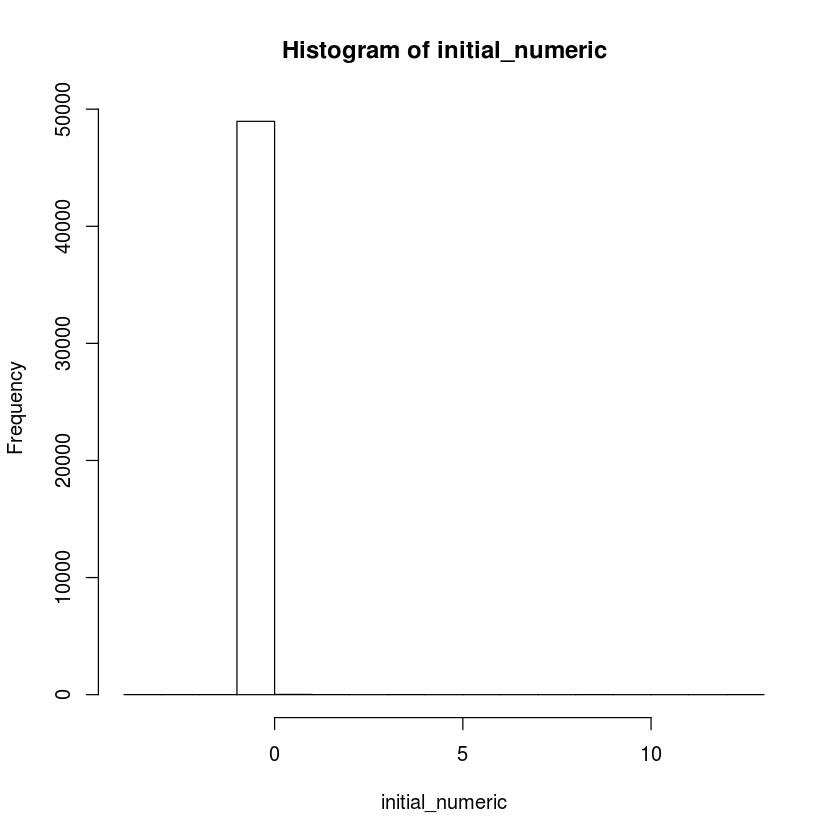

In [15]:
sum(is.na(initial_numeric_df))
hist(initial_numeric)

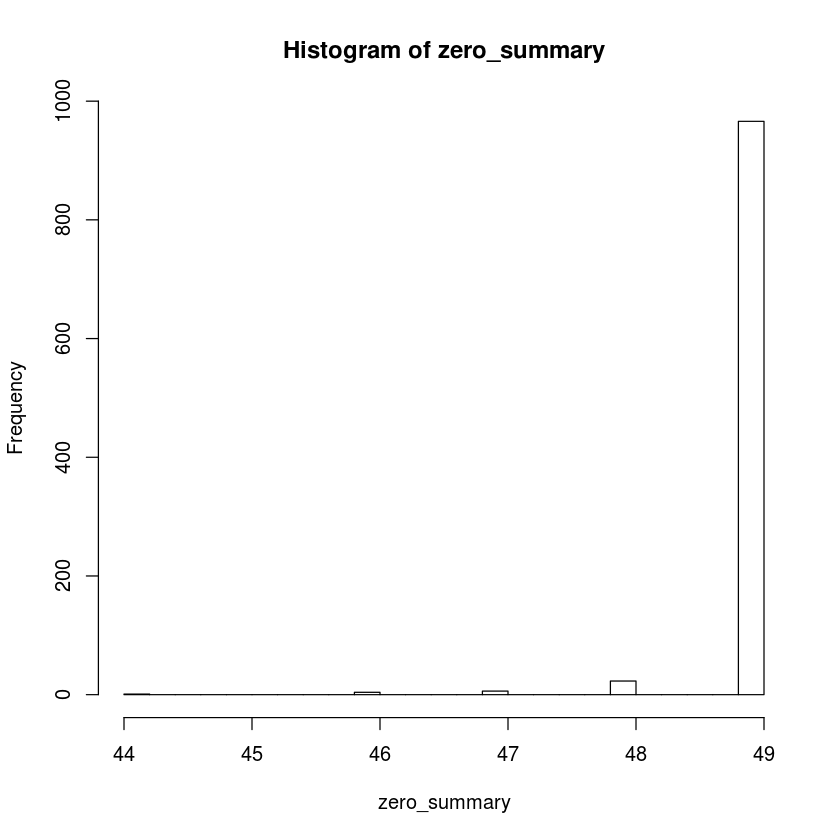

In [19]:
hist(zero_summary, breaks = 20)

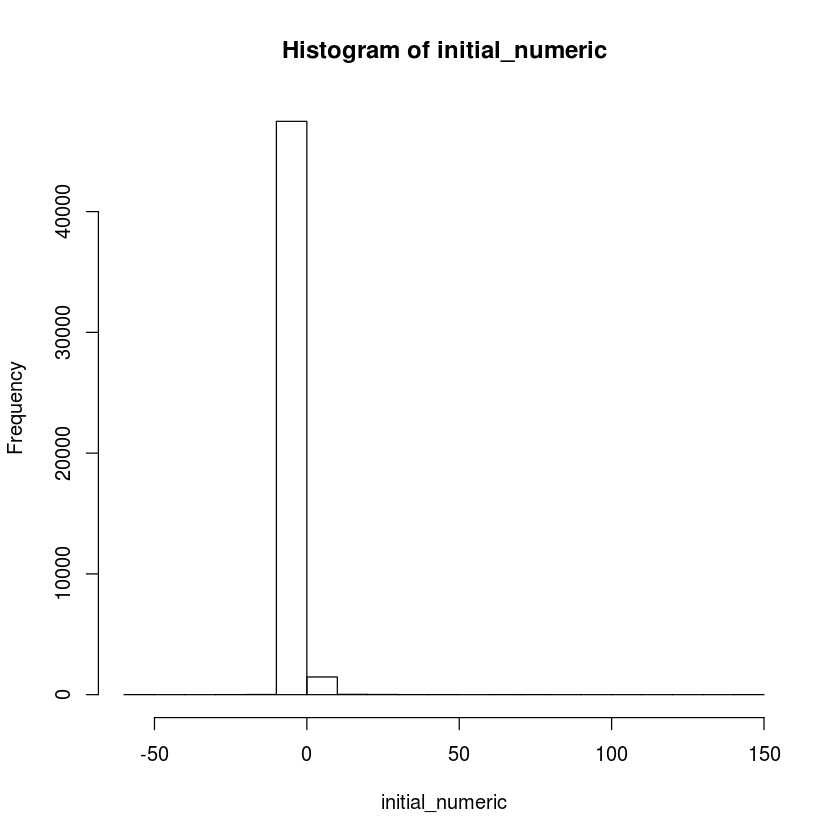

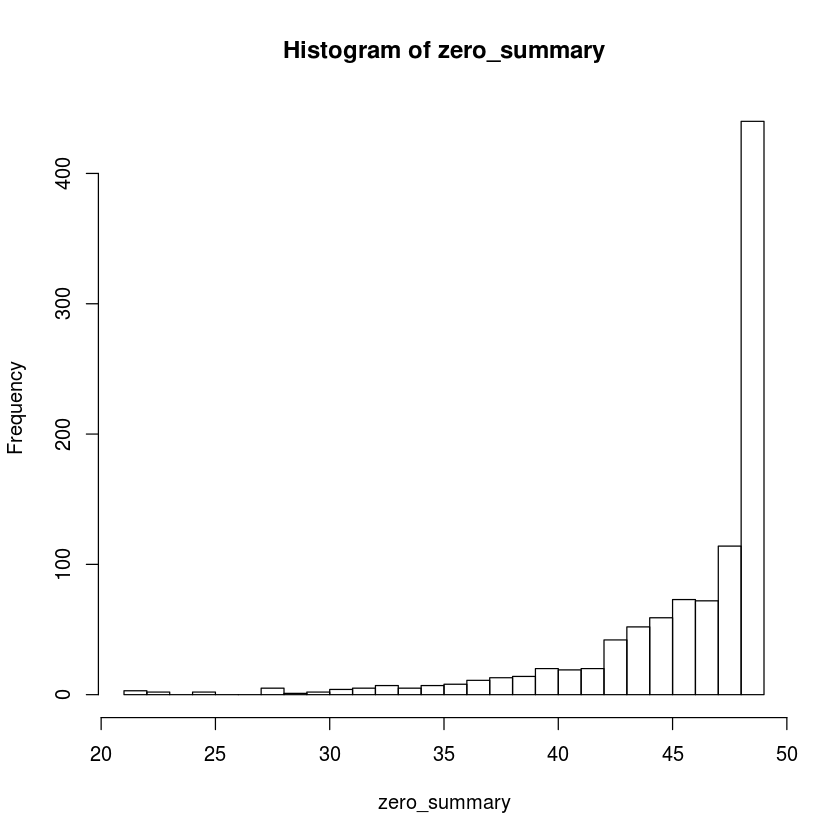

In [26]:
plot_est(multi_theta_est[[1]])

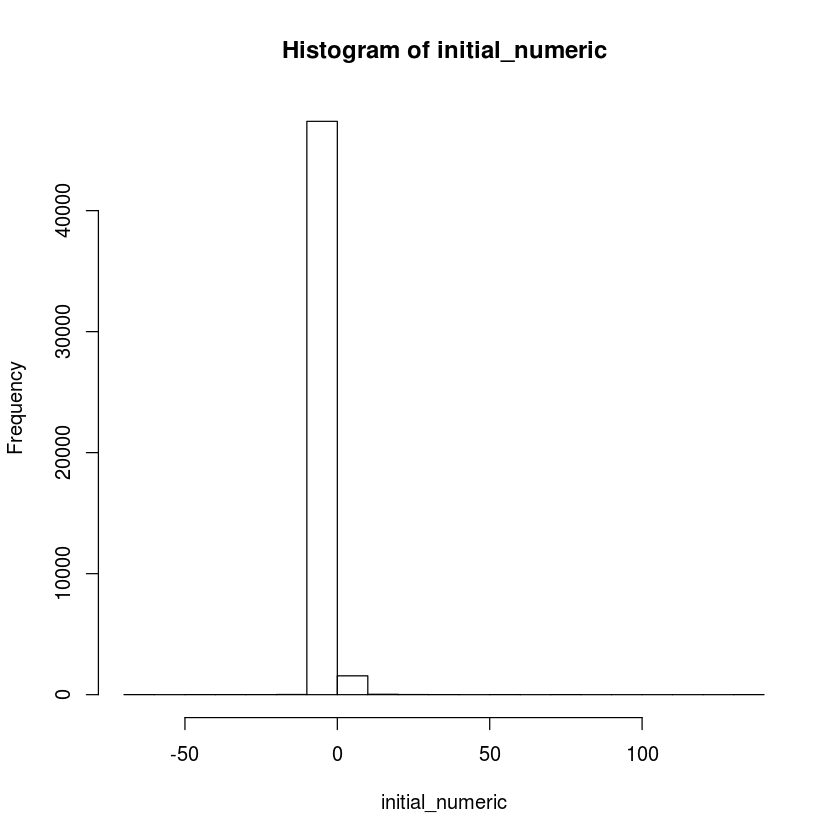

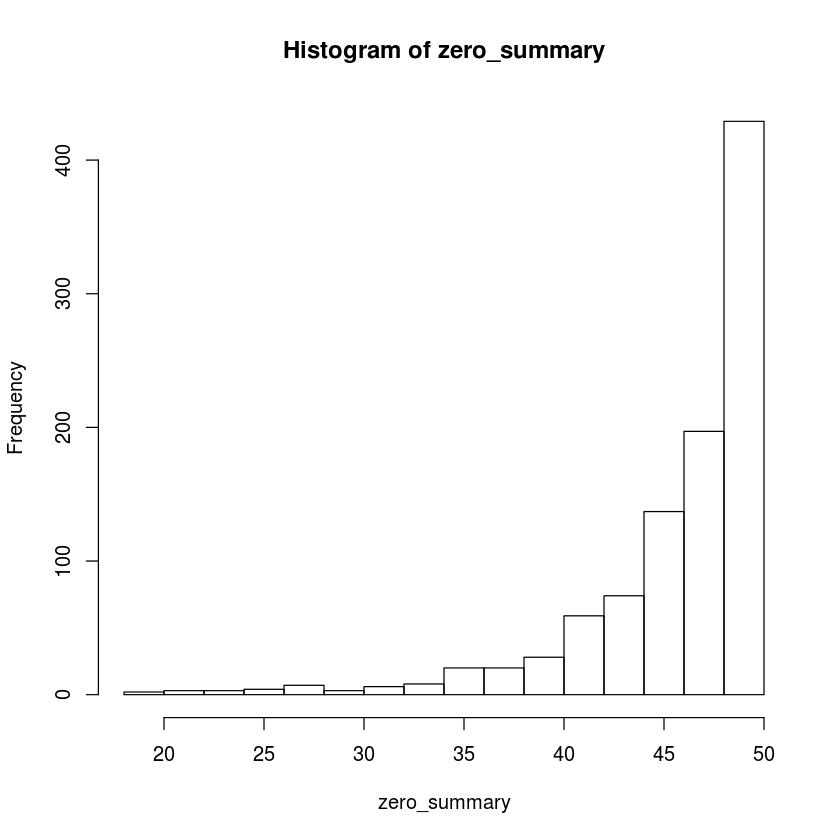

In [27]:
plot_est(multi_theta_est[[2]])

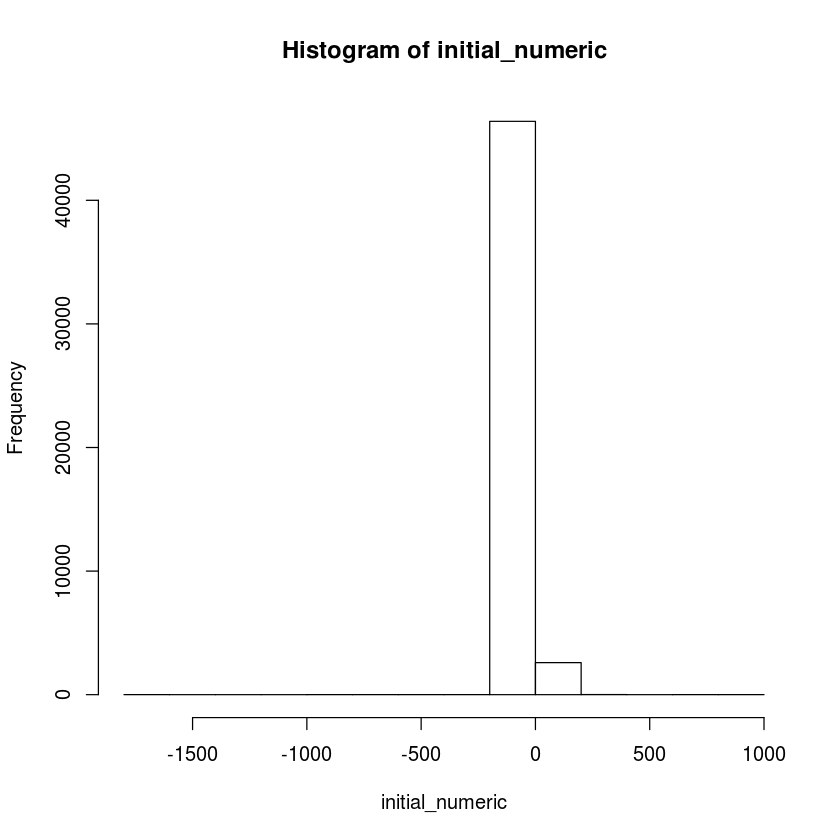

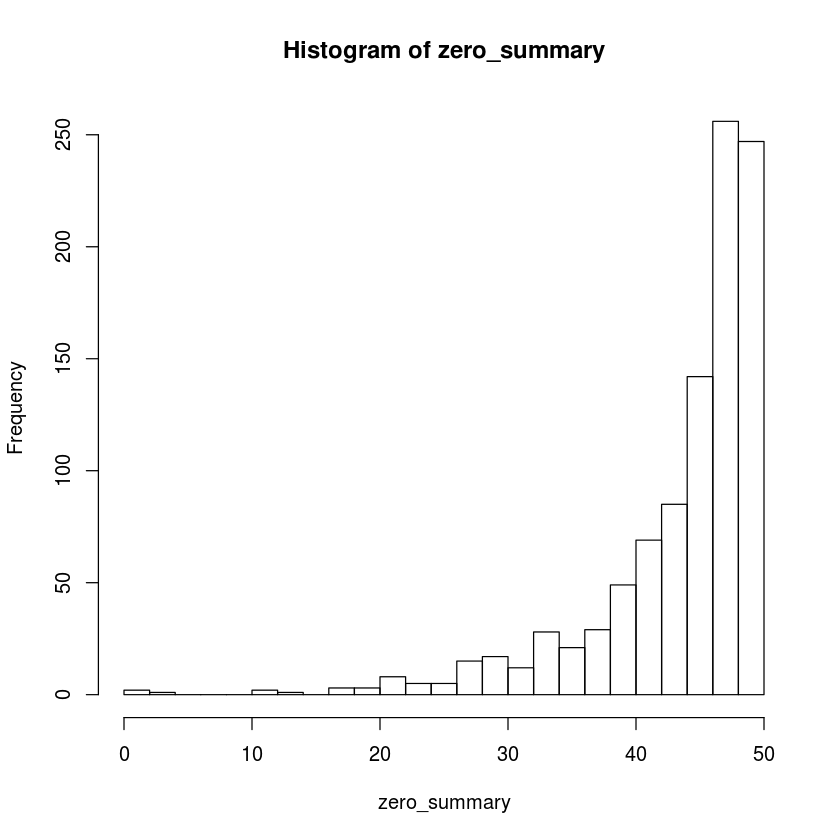

In [28]:
plot_est(multi_theta_est[[3]])

In [20]:
sum(zero_summary != 49)

[1] 34

In [ ]:
length(zero_summary)

In [ ]:
glasso <- function(X, Y, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 50, eps = 1e-3, verbose = FALSE){
	Bgt = Sys.time()
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = rep(0,P)
	for(t in 1:P){
		old_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
  if (verbose) {
    cat("Training error: ", old_objV1, '\n')	
  }
	
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("/ysm-gpfs/pi/zhao/from_louise/yh367/GTEX/codes/glasso.so") # change this to the abs path to optim.so
	}
	for(i in 1:maxiter){
		bgt = Sys.time()
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		edt = Sys.time()
		
		new_objV1 = rep(0,P)
		for(t in 1:P){
			new_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
		}
		if (verbose) {IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))}
		
        # mean objective
		if(mean(new_objV1) > mean(old_objV1)){
			break
		}
        
        # update criteria
		if (max(abs(new_objV1-old_objV1)) < eps) {
			break
		} else {
			old_objV1 = new_objV1
		}
	}
	Edt = Sys.time()
	cat("total training time: ", Edt-Bgt, "\n")
	list(est = theta, avg_train_err = mean(new_objV1), train_err=new_objV1)
}

In [6]:

bgt = Sys.time()


k = "1"
X_all = list()
Y_all = list()
for(t in 1:T_num){
    X_all_tmp = sub_id_map[[t]]
    X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
    Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
}
# initial values 
single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
for(t in 1:T_num){
    IRdisplay::display_html(paste0("Tissue ", t))
    tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0.5, nfolds = 5)
    single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
}

sig_norm = apply(single_initial_est, 1, function(x){sqrt(sum(x^2))})
sig_norm[sig_norm==0] = rep(min(sig_norm[sig_norm>0]), sum(sig_norm==0))/2
sig_norm = sig_norm/sum(sig_norm)
weights2 = 1/sig_norm; weights2 = weights2/sum(weights2);

tis_norm = apply(single_initial_est, 2, function(x){sum(abs(x))})
tis_norm[tis_norm==0] = rep(min(tis_norm[tis_norm>0]), sum(tis_norm==0))/2
tis_norm = tis_norm/sum(tis_norm)
weights1 = 1/tis_norm; weights1 = weights1/sum(weights1);

spsz = unlist(lapply(X_all,nrow))
initial_numeric = as.numeric(single_initial_est)
#remove(single_initial_est)
XY = grad_prep(X_all, Y_all)

XX_all = lapply(X_all, function(x){eigenMatMult(t(x), x)/nrow(x)})
tmp_res = rep(0, fold)
for(f in 1:fold){


    ans = glasso(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[f,1]/spsz, lambda2=multi_lam[f,2], theta=matrix(initial_numeric,M,P), verbose = if_verbose)
    tmp_res[f] = ans$avg_train_err
}
final.lam = multi_lam[which.min(tmp_res),]
ans = glasso(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=final.lam[1]/spsz, lambda2=final.lam[2], theta=matrix(initial_numeric,M,P), verbose = if_verbose)
#info = read.table(info_path, header=T, sep='\t')
#downstream_est = data.frame(info[,1:3], ans$est)
multi_all_res = multi_mse(ans$est, X_all, Y_all)
single_all_res = multi_mse(single_initial_est, X_all, Y_all)

#info = read.table(info_path, header=T, sep='\t')
info = genotype_info$bim
downstream_est = data.frame(info[1:1000, ], ans$est)
#downstream_est = data.frame(info, ans$est)
edt = Sys.time()
print(edt-bgt)

Tissue 1

Tissue 2

Tissue 3

Tissue 4

Tissue 5

Tissue 6

Tissue 7

Tissue 8

Tissue 9

Tissue 10

Tissue 11

Tissue 12

Tissue 13

Tissue 14

Tissue 15

Tissue 16

Tissue 17

Tissue 18

Tissue 19

Tissue 20

Tissue 21

Tissue 22

Tissue 23

Tissue 24

Tissue 25

Tissue 26

Tissue 27

Tissue 28

Tissue 29

Tissue 30

Tissue 31

Tissue 32

Tissue 33

Tissue 34

Tissue 35

Tissue 36

Tissue 37

Tissue 38

Tissue 39

Tissue 40

Tissue 41

Tissue 42

Tissue 43

Tissue 44

Tissue 45

Tissue 46

Tissue 47

Tissue 48

Tissue 49

Training error:  87.53052 80.30783 1.579152 11.96649 7.101965 75.51774 27.44291 18.80179 2.310168 0.4344715 0.6302446 1.7194 4.407714 4.058322 6.340478 0.7986082 1.201295 1.756662 0.7670091 117.3791 5.573785 221.1587 11.67614 3.01597 6.035344 93.78616 79.91211 6.601775 2.044606 28.23102 0.4963709 14.54012 9.816847 1.443434 251.2447 6.078707 0.5228069 11.80341 2.602573 8.893407 14.56334 6.354834 607.6912 78.53181 0.9771653 63.51137 2.607468 16.1589 289.2907 


ERROR: Error in mean((Y1[[t]] - X1[[t]] %*% theta[, t])^2): object 'Y1' not found


In [3]:
save(downstream_est, file = "test_est.RData")

In [4]:
dim(downstream_est)

[1] 1000   55

In [5]:
downstream_est[1:100, 1:50]

,chr,id,posg,pos,ref,alt,X1,X2,X3,X4,⋯,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44
,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,21,chr21_40464521_A_G_b38,0,40464521,G,A,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,21,chr21_40464616_T_C_b38,0,40464616,C,T,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,21,chr21_40464797_G_A_b38,0,40464797,A,G,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,21,chr21_40464826_T_C_b38,0,40464826,C,T,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,21,chr21_40464961_G_A_b38,0,40464961,A,G,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,21,chr21_40465271_T_C_b38,0,40465271,T,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
7,21,chr21_40465366_C_T_b38,0,40465366,T,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8,21,chr21_40466036_C_T_b38,0,40466036,T,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,21,chr21_40466218_C_A_b38,0,40466218,A,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


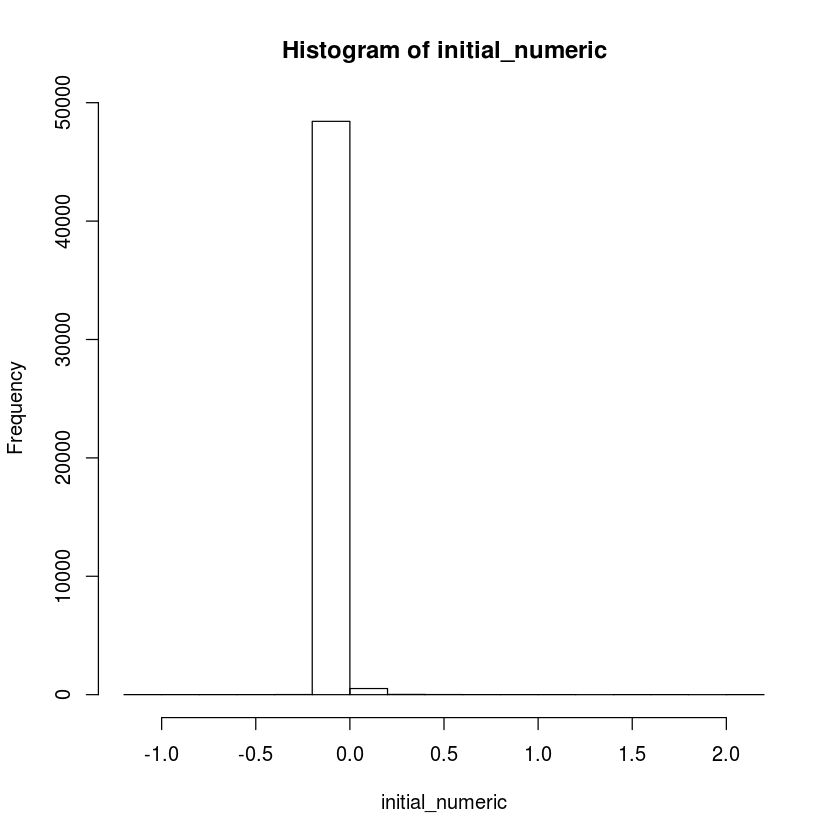

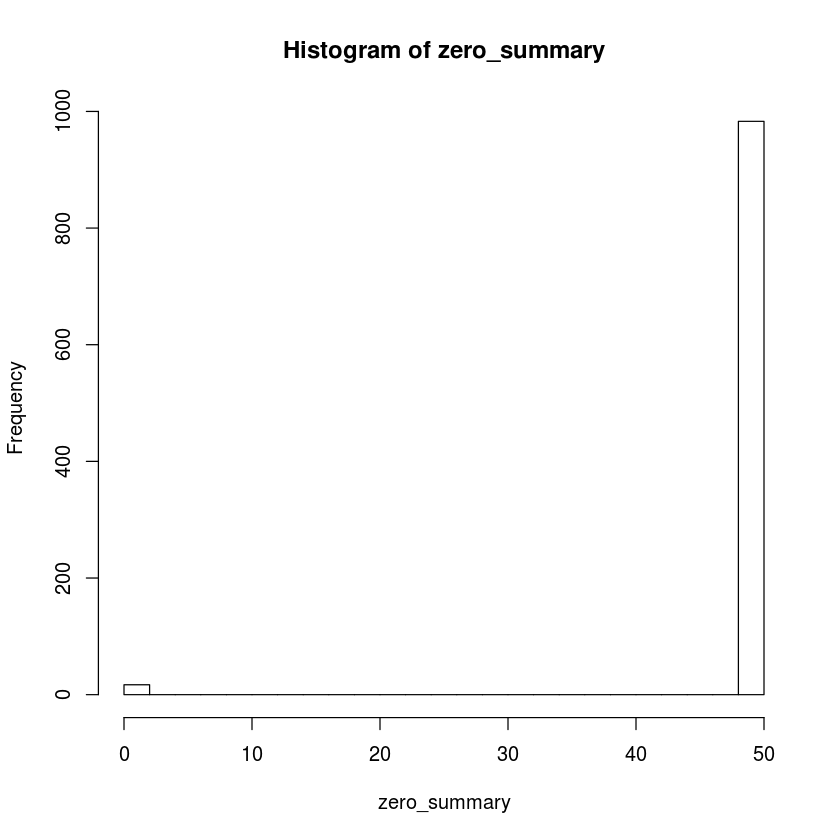

In [8]:
plot_est(t(downstream_est[,7:55]))

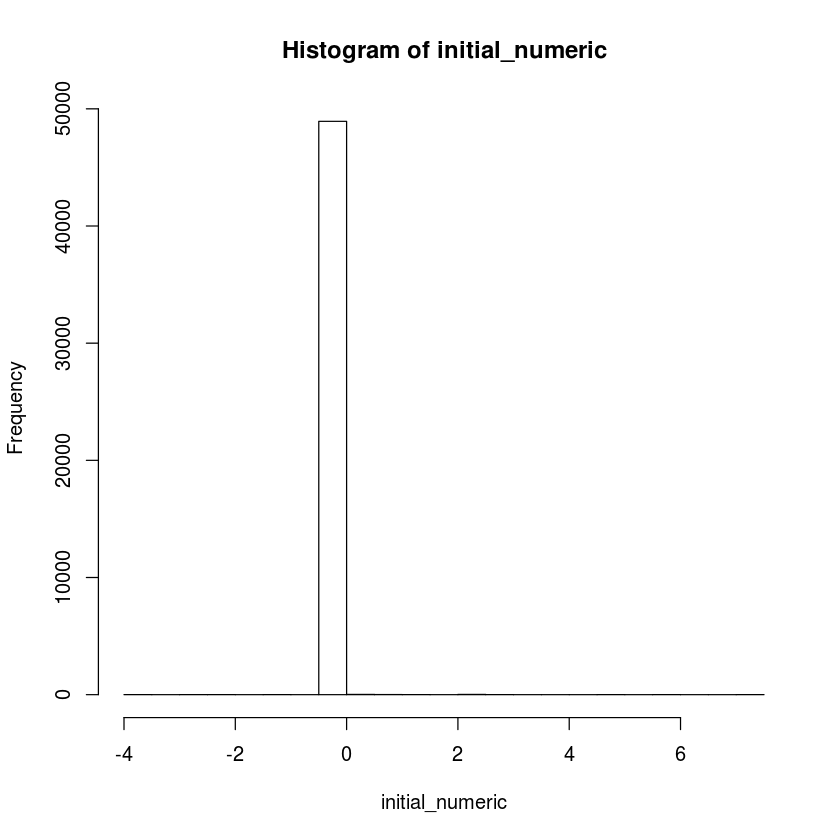

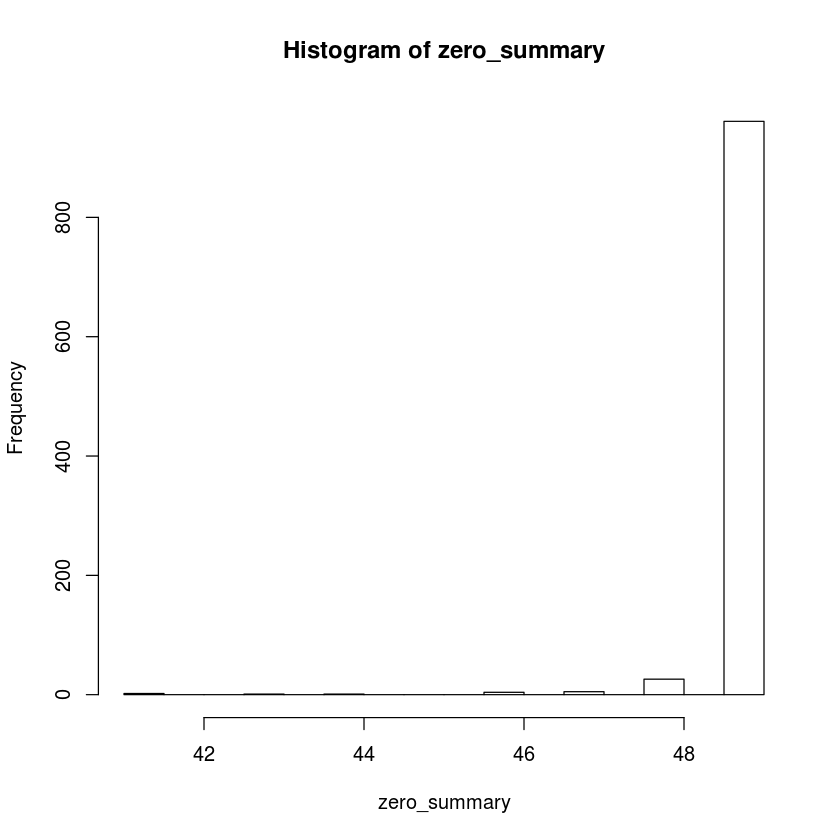

In [9]:
plot_est(initial_numeric)

In [2]:
save(single_res_test, single_lam, single_theta_est, multi_res_test, multi_lam, multi_theta_est, file = paste0('chr', chr, '.', k, '.', gene_id, ".RData"))
	#res_single = avg_perm(single_res_test)
	#res_multi = avg_perm(multi_res_test)
	#cat("Elastic net average testing error (all): ", apply(res_single, 2, mean), '\n')
	#cat("glasso averge testing error (all): ", apply(res_multi, 2, mean), '\n')
	#cat("Number of all zero tissues in elastic net is ", sum(is.na(res_single[,1])), '\n')
	#cat("Number of all zero tissues in glasso is ", sum(is.na(res_multi[,1])), '\n')
	#cat("Elastic net average testing error (non-zero): ", apply(res_single[!is.na(res_multi[,1]),], 2, mean), '\n')
	#cat("glasso averge testing error (non-zero): ", apply(res_multi[!is.na(res_multi[,1]),], 2, mean), '\n')

	## generate an estimate with whole data ##
	
	#write.table(downstream_est, paste0(gene_id, ".est"), quote=F, row.names=F, col.names=c("SNP", "REF.0.", "ALT.1.", Yt))
    write.table(downstream_est, paste0(gene_id, ".est"), quote=F, row.names=F, col.names=c(colnames(genotype_info$bim), Yt))



Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781


In [9]:
length(ans$est)

[1] 523663

In [7]:
sum(initial_numeric == 0)

[1] 523429

In [8]:
length(initial_numeric)

[1] 523663

In [ ]:
for (obj in ls()) { 
    message(obj)
    print(object.size(get(obj)), units='auto') 
}

In [3]:
length(XX_train)

[1] 49

In [4]:
dim(XX_train[[1]])

[1] 10687 10687

In [5]:
test_mtx <- as.big.matrix(XX_train[[1]])

In [6]:
print(object.size(XX_train[[1]]), units='auto')

871.4 Mb


In [7]:
test_mtx <- matrix(1.57, 10000, 10000 )

In [8]:
print(object.size(test_mtx), units = "auto")

762.9 Mb


In [ ]:
dim(test_mtx)

In [10]:
test_mtx[1:6, 1:6]

1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57


In [11]:
XX_train[[1]][1:6, 1:6]

0.11700682,0.11700682,-0.01664066,0.09849660,0.10877685,-0.04667148
0.11700682,0.11700682,-0.01664066,0.09849660,0.10877685,-0.04667148
-0.01664066,-0.01664066,0.21854696,0.19724280,-0.01430092,-0.09354227
0.09849660,0.09849660,0.19724280,0.30699923,0.09279519,-0.15061144
0.10877685,0.10877685,-0.01430092,0.09279519,0.10954468,-0.04445851
-0.04667148,-0.04667148,-0.09354227,-0.15061144,-0.04445851,0.48489715


In [5]:
#save(single_res_test, single_lam, single_theta_est, multi_res_test, multi_lam, multi_theta_est, res_tune, rec_lamv, file = paste0(output_dir, '/', gene_id, ".cv.evaluation.RData"))
save(single_res_test, single_lam, single_theta_est, multi_res_test, multi_lam, multi_theta_est, res_tune, file = paste0(output_dir, '/', gene_id, ".cv.evaluation.RData"))
                                  
	res_single = avg_perm(single_res_test)
	res_multi = avg_perm(multi_res_test)
	cat("Elastic net average testing error (all): ", apply(res_single, 2, mean), '\n')
	cat("glasso averge testing error (all): ", apply(res_multi, 2, mean), '\n')
	cat("Number of all zero tissues in elastic net is ", sum(is.na(res_single[,1])), '\n')
	cat("Number of all zero tissues in glasso is ", sum(is.na(res_multi[,1])), '\n')
	cat("Elastic net average testing error (non-zero): ", apply(res_single[!is.na(res_multi[,1]),], 2, mean), '\n')
	cat("glasso averge testing error (non-zero): ", apply(res_multi[!is.na(res_multi[,1]),], 2, mean), '\n')

  #------------ use tuning parameter chosen above to train model on entire dataset -------------#
	## generate an estimate with whole data ##
  cat('training a model on entire data with parameters chosen from cv\n')
	X_all = list()
	Y_all = list()
	for(t in 1:T_num){
		X_all_tmp = sub_id_map[[t]]
        X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
		#X_all[[t]] = apply(as.matrix(dose[X_all_tmp,-c(1)]),2,as.numeric)
		Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
	}
	# initial values 
	single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
	for(t in 1:T_num){
		tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0.5, nfolds = 5)
		single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
	}

	sig_norm = apply(single_initial_est, 1, function(x){sqrt(sum(x^2))})
	sig_norm[sig_norm==0] = rep(min(sig_norm[sig_norm>0]), sum(sig_norm==0))/2
	sig_norm = sig_norm/sum(sig_norm)
	weights2 = 1/sig_norm; weights2 = weights2/sum(weights2);

	tis_norm = apply(single_initial_est, 2, function(x){sum(abs(x))})
	tis_norm[tis_norm==0] = rep(min(tis_norm[tis_norm>0]), sum(tis_norm==0))/2
	tis_norm = tis_norm/sum(tis_norm)
	weights1 = 1/tis_norm; weights1 = weights1/sum(weights1);

	spsz = unlist(lapply(X_all,nrow))
	initial_numeric = as.numeric(single_initial_est)
	#remove(single_initial_est)
	XY = grad_prep(X_all, Y_all)
	XX_all = lapply(X_all, function(x){t(x)%*%x/nrow(x)})
	tmp_res = rep(0, fold)
	for (f in 1:fold){
		#ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[f,1]/spsz, lambda2=multi_lam[f,2], theta=matrix(initial_numeric,M,P))#, verbose = if_verbose)
		ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[f]/spsz, lambda2=multi_lam[f], theta=matrix(initial_numeric,M,P))#, verbose = if_verbose)
        tmp_res[f] = ans$avg_train_err
	}
	final.lam = multi_lam[which.min(tmp_res),]
	ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=final.lam[1]/spsz, lambda2=final.lam[2], theta=matrix(initial_numeric,M,P))#, verbose = if_verbose)
	info = read.table(info_path, header=T, sep='\t')
    downstream_est = data.frame(info[,1:3], ans$est)
	multi_all_res = multi_mse(ans$est, X_all, Y_all)
	single_all_res = multi_mse(single_initial_est, X_all, Y_all)
  cat('writing final estimates\n')
	write.table(downstream_est, paste0(output_dir, '/', gene_id, ".est"), quote = F, row.names = F, col.names = c("SNP", "REF.0.", "ALT.1.", Yt))

  cat('saving the prediction on all data for future analysis\n')
	save(multi_all_res, single_all_res, final.lam, ans, file = paste0(output_dir, '/', gene_id, ".prediction_on_all_data.RData"))
  cat('done!\n')
    

Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning mess

Elastic net average testing error (all):  NA 99.70318 1.093741 
glasso averge testing error (all):  NA 96.68083 1.008235 
Number of all zero tissues in elastic net is  47 
Number of all zero tissues in glasso is  49 
Elastic net average testing error (non-zero):  NaN NaN NaN 
glasso averge testing error (non-zero):  NaN NaN NaN 
training a model on entire data with parameters chosen from cv
Training error: 2306.63991985794


ERROR: Error in multi_lam[f, 1]: incorrect number of dimensions
